# Import the packages

In [2]:
# Importing necessary libraries

# Core Python packages and utilities
import os
import gc
import warnings
import numpy as np
from scipy.stats import norm

# Data handling and preprocessing
import pandas as pd
from pandas.errors import PerformanceWarning
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Time series analysis and modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from arch import arch_model
from prophet import Prophet

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from scipy.optimize import nnls
from xgboost import DMatrix
import xgboost as xgb
import lightgbm as lgb

# Neural networks and deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback
import optuna

# Visualization
import matplotlib.pyplot as plt

# Parallel computing
import pyopencl as cl

# Quality of life settings

In [2]:
# Suppress warnings (e.g., FutureWarnings, PerformanceWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=PerformanceWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency 30min will be used.")

# Parallel computing configuration for TensorFlow
num_of_threads = 8  # Set the number of threads manuallly according to your PC specifications
tf.config.threading.set_intra_op_parallelism_threads(num_of_threads)

# Checks which devices are available and sets the cuda gpu in path
platforms = cl.get_platforms()
for i, platform in enumerate(platforms):
    print(f"Platform {i}: {platform.name}")
    for j, device in enumerate(platform.get_devices()):
        if platform.name == "NVIDIA CUDA":
            gpu_platform_id = i
            gpu_device_id = j
        print(f"  Device {j}: {device.name}")
os.environ["LIGHTGBM_GPU_PLATFORM_ID"] = str(gpu_platform_id)  # Makes sure the Platform id that will be used is set correctly in the System Varibles
os.environ["LIGHTGBM_GPU_DEVICE_ID"] = str(gpu_platform_id)  # Makes sure the GPU id that will be used is set correctly in the System Varibles
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Platform 0: NVIDIA CUDA
  Device 0: NVIDIA GeForce GTX 1060
Platform 1: Intel(R) OpenCL HD Graphics
  Device 0: Intel(R) UHD Graphics 620


# Import the data

In [3]:
merged_df = pd.read_csv("merged_df_nas_filled.csv", parse_dates=['Datetime'])  # df merging four initial csvs with missing filled from previous preprocessing steps
merged_df.set_index('Datetime', inplace=True)
merged_df_2024 = merged_df[(merged_df.index >= '2023-09-30') & (merged_df.index < '2025-01-01')]  # we only look at the last 365 days

# User Defined Functions for quality of life reasons

In [436]:
def calculate_fft(series, n_top_seasonalities, threshold_pc=0.02):
    """
    Calculate significant positive frequencies and their amplitudes using Fast Fourier Transform (FFT),
    selecting the lower of 2% of the max amplitude or the top `n` frequencies.

    Parameters:
    - series (pd.Series): The input time series data.
    - n_top_seasonalities (int): The maximum number of significant frequencies to consider.
    - threshold_pc (float): Percentage (0 < threshold_pc <= 1) of the maximum amplitude to filter significant frequencies.

    Returns:
    - zip: A generator yielding (positive frequency, amplitude) for each significant frequency.
    """
    # Compute fast Fourier transform
    price_fft = np.fft.fft(series.dropna())

    # Get frequencies corresponding to FFT coefficients
    freqs = np.fft.fftfreq(len(price_fft), d=1/48)  # because half-hourly data

    # Calculate amplitudes
    amplitudes = np.abs(price_fft)

    # Calculate the threshold based on 2% of the max amplitude
    threshold = threshold_pc * np.max(amplitudes)

    # Filter positive frequencies with amplitudes above threshold
    positive_indices = np.where((amplitudes > threshold) & (freqs > 0))
    positive_freqs = freqs[positive_indices]
    positive_amplitudes = amplitudes[positive_indices]

    # Sort by amplitude and select the lower of `n_top_seasonalities` or all significant frequencies
    sorted_indices = np.argsort(positive_amplitudes)[::-1]
    selected_indices = sorted_indices[:min(n_top_seasonalities, len(sorted_indices))]

    # Select the top frequencies and amplitudes
    significant_freqs = positive_freqs[selected_indices]
    significant_amplitudes = positive_amplitudes[selected_indices]

    return zip(significant_freqs, significant_amplitudes)


def metrics(y_test, y_pred):
    """
    Calculate and display error metrics for model evaluation.

    This function computes standard error metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE),
    Root Mean Squared Error (RMSE), and R-squared (R2), to evaluate the accuracy of model predictions.

    Parameters:
    - y_test (Series or array-like): The true values for the target variable in the test set.
    - y_pred (Series or array-like): The predicted values for the target variable in the test set.

    Returns:
    - None
    """
    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print error metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    return rmse


# Memory reduction for our dataset by setting optimal dtypes
def reduce_mem_usage(df, verbose=True):
    """
    Reduces the memory usage of a pandas DataFrame by downcasting numeric columns 
    to the smallest possible dtype that can fit the range of values, and converting 
    other columns to 'category' type where applicable.

    Parameters:
    df (pd.DataFrame): The input DataFrame to optimize.
    verbose (bool): If True, prints the memory usage reduction.

    Returns:
    pd.DataFrame: The optimized DataFrame with reduced memory usage.

    Function Details:
    - Identifies numeric columns with data types like integers and floats.
    - For integer columns, downcasts to the smallest possible integer type 
      (e.g., int8, int16, int32, int64) that can accommodate the data's range.
    - For float columns, downcasts to the smallest possible float type 
      (e.g., float16, float32, float64) that can accommodate the data's range.
    - Converts non-numeric columns to 'category' type for memory efficiency.
    - Calculates and optionally prints the reduction in memory usage.

    Notes:
    - Ensures no data loss during type conversion by checking the range of values 
      before downcasting.
    - Particularly useful for large datasets where memory constraints are a concern.
    """
    numerics = ["int8", 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             df[col] = (df[col]).astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Plotting series, ACF, and PACF
def ACF_PACF(residuals):
    """
    Plots the Time Series, Auto-Correlation Function (ACF), and Partial Auto-Correlation Function (PACF)
    for a given set of residuals to analyze time series behavior.

    Parameters:
    residuals (pd.Series): A pandas Series containing the residuals or time series data.

    Returns:
    None: The function displays the plots but does not return any values.

    Function Details:
    - Creates a 3-row subplot layout for visual analysis.
    - The first plot shows the time series of the residuals to observe any patterns or trends over time.
    - The second plot displays the ACF (Auto-Correlation Function) to measure the correlation between 
      the time series and its lagged values.
    - The third plot displays the PACF (Partial Auto-Correlation Function) to measure the correlation 
      between the time series and its lagged values while controlling for the correlations of intervening lags.
    - The number of lags to display in ACF and PACF can be adjusted in the `lags` parameter.
    - Uses `tight_layout()` to optimize spacing between subplots for better visualization.
    """
    # Create the figure and axes
    fig, axes = plt.subplots(3, 1, figsize=(12, 16))

    # Plot the time series
    axes[0].plot(residuals.index, residuals, color='blue')
    axes[0].set_title('Time Series')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')

    # Plot ACF (Auto-Correlation Function)
    plot_acf(residuals, ax=axes[1], lags=100)  # Set the lags as per your requirement
    axes[1].set_title('ACF (Auto-Correlation Function)')

    # Plot PACF (Partial Auto-Correlation Function)
    plot_pacf(residuals, ax=axes[2], lags=100)  # Set the lags as per your requirement
    axes[2].set_title('PACF (Partial Auto-Correlation Function)')

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()
    

def train_test_split_index_univariate(data, test_size=48):
    """
    Splits a dataset into sequential training and testing sets.

    Parameters:
    data (pd.DataFrame or pd.Series): Dataset to split.
    test_size (int): Number of samples in the test set (default: 48).

    Returns:
    tuple: (train, test) where:
        - train: All rows except the last `test_size` rows.
        - test: Last `test_size` rows.

    Notes:
    - Preserves order, suitable for time-series data.
    """
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]
    return train, test


def train_test_split_index_multivariate(data, test_size=48):
    """
    Splits a dataset into sequential training and testing sets.

    Parameters:
    data (pd.DataFrame or pd.Series): Dataset to split.
    test_size (int): Number of samples in the test set (default: 48).

    Returns:
    tuple: (train, test) where:
        - train: All rows except the last `test_size` rows.
        - test: Last `test_size` rows.

    Notes:
    - Preserves order, suitable for time-series data.
    """
    data = data.iloc[2:-(test_size+1)]  # remove the missing because of lags and the predicted
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]
    return train, test


def Yeo_Johnson(df, target):
    df = df.copy()
    # Apply Yeo-Johnson Transformation
    pt = PowerTransformer(method='yeo-johnson')
    df.loc[:, target] = pt.fit_transform(df[[target]])
    df.loc[:, f'{target}_diff'] = df[target].diff()
    df = df.drop(df.index[0])  # Drops the first row based on its index, since we do .diff

    # Visualize original series and rolling standard deviation
    rolling_std = df.dropna()[f'{target}_diff'].rolling(window=48).std()
    rolling_mean = df.dropna()[f'{target}_diff'].rolling(window=48).mean()
    plt.figure(figsize=(15, 10))
    plt.plot(df.dropna()[f'{target}_diff'], label='Original Series', color='blue')
    plt.plot(rolling_std, label='Rolling Std Dev', color='red')
    plt.plot(rolling_mean, label='Rolling Mean', color='green')
    plt.title(f'{target} transformed as well as Rolling Mean and Standard Deviations')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, pt


def plot_results(test, test_original, test_predictions, model_name):
    plt.figure(figsize=(20, 10))
    plt.plot(test.index, test_original, label='Actual Data', color='blue')
    plt.plot(test.index, test_predictions, label=f'{model_name} Predictions', linestyle='dashed', color='red')
    plt.title(f'{model_name} Predictions vs Actual Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# User Defined Functions for Feature Engineering

In [ ]:
def extend_df_LSTM_univariate(df, num_rows):
    to_predict = ["Total_Load","Demand_Outturn",
                  "BSAD_Turn_Up","BSAD_Turn_Down",
                  "EPEX_Intraday_Volume",
                  "Biomass", "Fossil_Gas", "Fossil_Hard_Coal", "Hydro_Pumped_Storage", "Hydro_Run-of-River_and_Poundage", "Nuclear", "Solar", "Wind_Onshore", "Wind_Offshore"  # Energy generation which is cyclical, except Fossil Oil which is WN
                  ]  # Also don't predict Loss of Load Prob which is WN
    to_derive = ["BSAD_Total"]  # Calculate as the sum of BSAD_Turn_Up and BSAD_Turn_Down

    # Creating rows to append generated predictions
    # Generate a date range that starts after the last date in df, respecting the half hour datetime
    date_range_df_temp = pd.DataFrame({'value': [None] * num_rows}, index=pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=30), periods=num_rows, freq='30T'))

    # Concatenate without resetting the index, preserving the datetime index
    df_with_preds = pd.concat([df, date_range_df_temp])
    date_range_df_temp = date_range_df_temp.drop(columns=["value"])  # Remove the temporary column we created in order to introduce rows

    for col in to_predict:
        df_with_preds.loc[df_with_preds.index[-num_rows:], col] = univariate_LSTM(df[[col]], num_rows, num_rows*2, col, measuring=False)

    df_with_preds[to_derive[0]] = df_with_preds["BSAD_Turn_Up"] + df_with_preds["BSAD_Turn_Down"]  # calculate the BSAD toal wiht the two columns that make it up

    not_predicted_columns = set(df_with_preds.columns) - set(to_derive) - set(to_predict)  # Columns for which predictions are basically just their respective mean

    return df_with_preds, list(not_predicted_columns)


def feature_engineering(df):
    df_with_preds, not_predicted_columns = extend_df_LSTM_univariate(df, 48)  # takes in the df and appends new rows, fills with LSTM for select columns, 49 becaus of how we set up LSTM

    df_with_preds.drop(columns=["value"], inplace=True, errors="ignore")  # make sure the placeholder had been deleted

    # Variable that tracks the difference between total load and demand
    df_with_preds["Load-Demand"] = df_with_preds["Total_Load"] - df_with_preds["Demand_Outturn"]

    # Recalculate the LoLP using the Normal CDF (we only use the difference btw Total load and demand outturn, not entirely correct, but Loss of Load probability had a lot of missing values so we wanted to calculate something of our own). 
    # For instructions, we consulted:
    # approximation since we do not have some of the information
    # https://bscdocs.elexon.co.uk/category-3-documents/loss-of-load-probability-calculation-methodolgy-statement
    df_with_preds['LoLP'] = 1 - norm.cdf(df_with_preds["Load-Demand"], loc=0, scale=np.sqrt(700))
    # Calculate the LoLP lag 1 as proxy for prediction of not enough electricity for next day since the load and demand are super autocorellated
    df_with_preds['LoLP_lag1'] = df_with_preds['LoLP'].shift(1)


    # Feature engineering to create wind+solar variable, ignoring NaNs (if there is NaN in one of them, the sum is not NaN)
    df_with_preds["Wind_Solar"] = df_with_preds[["Solar", "Wind_Onshore", "Wind_Offshore"]].sum(axis=1, skipna=True)
    # Sum all columns except 'GMT Time', ignoring NaNs
    df_with_preds['Total_Generation'] = df_with_preds.sum(axis=1, skipna=True)


    # Total_Load = Total Generation + Exports - Imports - Stored Energy
    # So we create a column that is the difference between exports, imports and stored energy
    df_with_preds["Exports-Imports-Stored"] = df_with_preds["Total_Load"] - df_with_preds["Total_Generation"]
    df_with_preds["Generation-Demand"] = df_with_preds["Total_Generation"] - df_with_preds["Demand_Outturn"]
    
    Day_Ahead_Price_lag_48 = df_with_preds["Day_Ahead_Price"].shift(48)

    for col in df_with_preds:
        if df_with_preds[col].dtype == "object":
            if col != "value":
                df_with_preds[col] = pd.to_numeric(df_with_preds[col], errors='coerce')
    
    df_with_preds['Datetime'] = df_with_preds.index

    df_with_preds['day_of_week'] = df_with_preds['Datetime'].dt.dayofweek
    df_with_preds['is_weekend'] = (df_with_preds['Datetime'].dt.weekday >= 5).astype('int8')  # Monday (0) to Friday (4)

    df_with_preds['hour_of_day'] = df_with_preds['Datetime'].dt.hour
    df_with_preds['hour_of_day_half'] = df_with_preds['Datetime'].dt.hour + df_with_preds['Datetime'].dt.minute / 60

    df_with_preds['is_peak_hour'] = df_with_preds['hour_of_day'].isin([16, 17, 18, 19, 20]).astype('int8')
    df_with_preds['is_night'] = df_with_preds['hour_of_day'].isin([0, 1, 2, 3, 4, 5, 23]).astype('int8')

    # Create a boolean column 'close_price' for the last observation of the day
    df_with_preds['close_price'] = (df_with_preds['Datetime'].dt.time == pd.Timestamp('23:30').time()).astype('int8')
    # Create a new column for prev_day_close
    df_with_preds['prev_day_close'] = None
    # Assign the shifted close prices to the 'prev_day_close' column
    df_with_preds.loc[:, 'prev_day_close'] = df_with_preds.loc[df_with_preds['close_price'] == 1, "Intraday_Price"].shift()
    # Fill missing values in the 'prev_day_close' column with backward fill
    df_with_preds['prev_day_close'] = df_with_preds['prev_day_close'].fillna(method='bfill')
    # Create a boolean column 'open_price' for the first observation of the day
    df_with_preds['open_price'] = (df_with_preds['Datetime'].dt.time == pd.Timestamp('00:00').time()).astype('int8') * df_with_preds['prev_day_close']

    df_with_preds["System_Price_lag_1"] = df_with_preds["System_Price"].shift(1)
    df_with_preds["System_Price_lag_2"] = df_with_preds["System_Price"].shift(2)
    df_with_preds["NIV_Outturn_lag_1"] = df_with_preds["NIV_Outturn"].shift(1)
    df_with_preds["NIV_Outturn_lag_2"] = df_with_preds["NIV_Outturn"].shift(2)


    # seasonalities using the results from the fft
    freqs = []
    for freq, amp in calculate_fft(df_with_preds["System_Price"], 3, threshold_pc=0.02):  # Outputs same seasonalities for System Price and NIV_outturn
        freqs.append(freq)
    freqs = np.array(freqs)
    all_periods_in_days = 1 / freqs
    # Multiply each unique period by 24 to get values in hours
    unique_cycles_in_days = np.unique(all_periods_in_days.round(2))
    unique_cycles_in_hours = unique_cycles_in_days * 48  # because half hourly data

    # Format the results from scientific notation to decimal for readability
    formatted_cycles = [f"{value:.2f}" for value in np.sort(unique_cycles_in_days)]
    print("Unique cycles:", formatted_cycles, "in days")
    # Format the output to show in hours without scientific notation
    formatted_cycles_in_hours = [f"{value:.2f}" for value in np.sort(unique_cycles_in_hours)]
    print("Unique cycles:", formatted_cycles_in_hours, "in hours")

    for cycle in unique_cycles_in_hours:
        df_with_preds[f"hr_{cycle:.2f}h_sin"] = np.sin(2 * np.pi * df_with_preds['hour_of_day_half'] / cycle)
        df_with_preds[f"hr_{cycle:.2f}h_cos"] = np.cos(2 * np.pi * df_with_preds['hour_of_day_half'] / cycle)


    # Month, Quarter, and Seasons
    df_with_preds['year'] = df_with_preds['Datetime'].dt.year
    df_with_preds['month'] = df_with_preds['Datetime'].dt.month
    df_with_preds['quarter'] = df_with_preds['Datetime'].dt.quarter

    # Reset Datetime as the index
    df_with_preds = df_with_preds.set_index('Datetime')

    df_with_preds = df_with_preds.drop(columns=["prev_day_close"])
    df_with_preds = df_with_preds.drop(columns=[col for col in df_with_preds.columns if col.endswith("_diff")])

    cols_not_to_differentiate = ["year", "month", "quarter", "hour_of_day_half", "hour_of_day" ,"day_of_week" ,  # remove the time ones
                                "is_peak_hour", "is_night", "is_weekend",  # remove the boolean ones
                                "open_price", "close_price", "prev_day_close",  # remove the price ones
                                "LoLP_lag1", "System_Price_lag_1", "System_Price_lag_2", "Day_Ahead_Price_lag_48", "NIV_Outturn_lag_1", "NIV_Outturn_lag_2"]  # remove the lag ones
    cols_not_to_differentiate = cols_not_to_differentiate + not_predicted_columns  # We also do not do differentiation on the cols we did not predict

    for col in [cols for cols in df_with_preds.columns if not cols.endswith("sin") and not cols.endswith("cos")]:
        if col not in cols_not_to_differentiate:
            df_with_preds.loc[:,f"{col}_diff"] = df_with_preds[col].diff()
    
    return df_with_preds, Day_Ahead_Price_lag_48, not_predicted_columns

# User Defined Functions for ML

### Auto ARIMA Model

![alt text](ARIMA.png)

In [438]:
def statsforecast_arima(df, forecast_horizon):
    """
    Fit an AutoARIMA model to the time series data and forecast future values.

    This function uses AutoARIMA from the statsforecast package to automatically select the best ARIMA model.
    It performs both in-sample prediction and forecasts future values beyond the length of the data provided.

    Parameters:
    - df (Series): The input time series data. The index must be a DateTimeIndex.

    Returns:
    - DataFrame: A DataFrame containing the in-sample predictions and forecasted values over an extended range.
    """
    # Ensure the input is a pandas DataFrame with required columns
    df = pd.DataFrame({'unique_id': 1, 'ds': df.index, 'y': df.values})

    # Initialize the StatsForecast object with the AutoARIMA model
    sf = StatsForecast(models=[AutoARIMA()], freq='30min', n_jobs=-1)

    # Forecast future values
    forecast = sf.forecast(df=df, h=forecast_horizon, fitted=True)
    values=sf.forecast_fitted_values()
    values.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)
    result = pd.concat([values, forecast])
    return result["AutoARIMA"]

### Prophet Model

![alt text](Prophet.png)

In [19]:
def prophet_predictions(series, freq_amp, periods):
    """
    Generate predictions using Prophet with multiple seasonalities based on significant frequencies.

    Parameters:
    - series (pd.Series): The input time series data.
    - freq_amp (list of tuples): A list of (frequency, amplitude) pairs, where each frequency represents 
                                 a significant periodic component to be modeled as seasonality.

    Returns:
    - forecast (DataFrame): The forecasted values for the specified period, including trend and seasonal components.
    """
    # Prepare data for Prophet
    df = pd.DataFrame({'ds': series.index, 'y': series})
    model = Prophet()

    # Adding seasonalities based on significant frequencies
    for freq, amp in freq_amp:
        if freq != 0:  # Ignore the DC component
            period_in_days = 1 / freq
            seasonality_name = f"seasonal_freq_{freq:.4f}"
            fourier_order = 5 if period_in_days <= 1 else (10 if period_in_days <= 7 else 20)
            model.add_seasonality(name=seasonality_name, period=period_in_days, fourier_order=fourier_order)

    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq='30T')
    forecast = model.predict(future)

    return forecast.set_index('ds')

### Ensemble Model combining Prophet and Auto ARIMA

In [20]:
def ensemble_model(series, fft_threshold, periods, target="System_Price"):
    """
    Generate an ensemble forecast by combining Prophet and ARIMA models directly on a time series.

    Parameters:
    - series (pd.Series): The input time series data with DateTimeIndex.
    - fft_threshold (float): The threshold for filtering frequencies in the Fast Fourier Transform (FFT) for Prophet.

    Returns:
    - DataFrame: A DataFrame containing the original data, Prophet predictions, ARIMA residual forecasts,
      and the final combined forecast.
    """
    # Step 1: Calculate predictions with Prophet
    freq_amp_pairs = calculate_fft(series, fft_threshold)
    preds_prophet = prophet_predictions(series, freq_amp_pairs, periods)
    
    # Step 2: Calculate Residuals
    residuals = series - preds_prophet["yhat"]

    # Step 3: Fit ARIMA on the Residuals
    arima_forecast = statsforecast_arima(residuals.dropna(), periods)  # Ensure non-na data for ARIMA

    # Step 4: Combine the Predictions of Prophet and ARIMA
    combined_forecast = preds_prophet["yhat"].add(arima_forecast)  # Using fill_value to handle NaNs

    # Concatenate the original Series with the NaN Series
    updated_series = pd.concat([series, pd.Series([np.nan] * periods, index=pd.date_range(start=series.index[-1] + pd.Timedelta(minutes=30), periods=periods, freq='30T'))])

    # Prepare the result DataFrame
    results = pd.DataFrame({
        target: updated_series.values,
        'arima_residual_forecast': arima_forecast.values,
        'combined_forecast': combined_forecast.values
    })
    
    results[preds_prophet.columns] = preds_prophet

    return results

### Linear Regression (basic model for baseline)

![alt text](Linear-Regression-Formula.png)

In [28]:
def Linear_Regresson(df, test_size, target, to_drop):
    """
    Trains a meta-model using multiple base model predictions and evaluates its performance.

    Parameters:
    - X_meta_train (pd.DataFrame): Training feature set for the meta-model.
    - y_meta_train (pd.Series): Target variable for the training set.
    - y_meta_test (pd.Series): Target variable for the testing set.
    - X_meta_test (pd.DataFrame): Testing feature set for the meta-model.

    Returns:
    - meta_predictions (np.array): Predictions made by the meta-model on the testing set.
    - residuals (pd.Series): Residuals (differences between actual and predicted values) for the testing set.

    Function Details:
    1. **Equal Weighted Baseline**:
       - Calculates the average of all meta-features for the testing set and evaluates its performance as a baseline.

    2. **Linear Regression Meta-Model**:
       - Fits a linear regression model to the meta-features without an intercept (`fit_intercept=False`).
       - Outputs the coefficients for each feature.

    3. **Non-Negative Least Squares (NNLS)**:
       - Fits a NNLS model to enforce non-negative weights on the meta-features.
       - Outputs the NNLS-derived weights for each feature.

    4. **Predictions**:
       - Uses the linear regression meta-model to predict target values for the testing set.

    5. **Residuals and Evaluation**:
       - Computes residuals as the difference between actual and predicted values.
       - Evaluates the meta-model's performance using RMSE.

    6. **Visualization**:
       - Plots the actual vs. predicted values for the meta-model.
       - Highlights the meta-model's ability to forecast the target variable.
    """
    # Split into test and train
    train, test = train_test_split_index_multivariate(df, test_size)
    
    # Split into X and y
    y_train = train[target]
    y_test = test[target]
    X_train = train.drop(columns=[col for col in to_drop], errors='ignore')
    X_test = test.drop(columns=[col for col in to_drop], errors='ignore')


    # Linear regression with zero intercept
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Attach column names to coefficients
    lr_coeff_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr_model.coef_
    })

    print("\nLinear Regression Coefficients:")
    print(lr_coeff_df.sort_values(by='Coefficient', ascending=False))

    # Make predictions on the test set
    LinReg_predictions = lr_model.predict(X_test)

    # Calculate RMSE
    metrics(y_test, LinReg_predictions)

    # Plot Results
    plot_results(test, y_test, LinReg_predictions, "LinReg univariate")
    
    return LinReg_predictions

### XGBoost

![alt text](XGBoost.png)

#### Splitting the data and putting the dataset in the right dtype for gpu training

In [ ]:
def XGBoost_preparing_data(df_with_preds, pred_size, cols_to_drop, target):
   """
   Prepares data for training and testing an XGBoost model by cleaning, splitting, and converting the dataset.

   Parameters:
   - df_with_preds (pd.DataFrame): The input DataFrame with predictions for the next day.
   - pred_size (int): The size of the prediction/testing set.
   - cols_to_drop (list): List of columns to exclude from the feature set (e.g., target and irrelevant columns).

   Returns:
   - X_train (pd.DataFrame): Feature set for training.
   - X_test (pd.DataFrame): Feature set for testing.
   - y_train (pd.Series): Target values for training.
   - y_test (pd.Series): Target values for testing.
   - dtrain (DMatrix): XGBoost-compatible training data matrix.
   - dtest (DMatrix): XGBoost-compatible testing data matrix.
   - column_names (Index): Names of the feature columns used in the model.

   Function Details:
   1. **Column Dropping**:
      - Extends `cols_to_drop` with the target variable and its differenced version.
      - Removes these columns from the feature set to avoid data leakage.

   2. **Target-Specific Features**:
      - Handles specific targets ("NIV_Outturn" or "System_Price") by dynamically dropping columns.
      - Raises an exception for unsupported targets to enforce proper usage.

   3. **Train-Test Split**:
      - Splits the dataset into training and testing sets based on `pred_size`.
      - Ensures that the feature (`X`) and target (`y`) are aligned.

   4. **XGBoost DMatrix Conversion**:
      - Converts training and testing sets into `DMatrix` format for GPU optimization.

   Notes:
   - Ensure `target` is defined globally or passed to the function as a parameter.
   - The use of `answers[target]` for `y_test` requires `answers` to be precomputed and aligned with `df_with_preds`.
   """
   # We set the columns that we have predicted for the next day
   cols_to_drop = cols_to_drop + [target, f"{target}_diff"]

   # Define the split criteria
   test_start = '2023-10-01'  # Test set starts on Oct 1st
   val_start = '2023-09-03'  # Validation set starts on Sept 3rd

   # Test set: Data from Oct 1st (49 half-hourly entries)
   test_set = df_with_preds.iloc[-49:]
   # Validation set: Data from Sept 3rd to Sept 30th
   val_set = df_with_preds.loc[val_start:test_start].iloc[:-pred_size]  # Exclude test data from val

   # Training set: All rows before the validation set and all rows after the validation but excluding the test set
   train_set = pd.concat([
      df_with_preds.iloc[:-29*pred_size-1],  # Rows before validation
      df_with_preds.iloc[-28*pred_size-1:-(pred_size+1)]  # Rows after validation but before test
   ])
   # Separate features (X) and target (y)
   X_train, y_train = train_set.drop(columns=[col for col in cols_to_drop], errors='ignore'), train_set[target]
   X_val, y_val = val_set.drop(columns=[col for col in cols_to_drop], errors='ignore'), val_set[target]
   X_test, y_test = test_set.drop(columns=[col for col in cols_to_drop], errors='ignore'), pd.Series([0] * 49)  # Since we don't have the y_test, we just put the series as placeholder


   # Ensure the data is converted to DMatrix for GPU compatibility (optional but improves GPU utilization)
   dtrain = DMatrix(X_train, label=y_train)
   dval = DMatrix(X_val, label=y_val)
   dtest = DMatrix(X_test, label=y_test)  

   column_names = X_train.columns
 
   return X_train, X_test, X_val, y_val, y_train, y_test, dtrain, dval, dtest, column_names


### Basic XGBoost

In [402]:
from xgboost import XGBRegressor
def basic_XGBoost(df, DAP_lag48, target):
    df = df.copy()
    # We set the columns that we have predicted for the next day
    columns = ['Total_Load', "Demand_Outturn", "Load-Demand", 'LoLP', 'LoLP_lag1', "Intraday_Price", "Wind_Solar"]
    # Target are the residuals from the prophet on sp
    target = target

    # Remove some of the cols in the X that are basically the variable we're trying to predict
    X = df[columns]
    y = df[target]

    # Train/test split
    X_train = X[:-49]
    X_test = X[-48:-1]
    y_train = y[:-49]

    # Train an XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    DAP_lag48 = DAP_lag48.dropna()
    final_preds = 0.75*y_pred + 0.55*DAP_lag48[:-48]
    
    return final_preds

#### Optimizing the hyperparameters

![alt text](bayesian.png)

In [380]:
def XGBoost_optimization(dtrain, dval, y_val, column_names):
    """
    Optimizes an XGBoost model using Optuna for hyperparameter tuning and trains a final model with the best parameters.

    Parameters:
    - dtrain (DMatrix): XGBoost-compatible training data matrix.
    - dval (DMatrix): XGBoost-compatible valing data matrix.
    - column_names (Index): Feature names used for the model.

    Returns:
    - final_model (Booster): The trained XGBoost model with the best hyperparameters.

    Function Details:
    1. **Objective Function**:
       - Defines a custom function for Optuna optimization.
       - Optimizes the following hyperparameters:
         - `learning_rate`: Controls the step size of gradient descent.
         - `subsample`: Fraction of data used in each iteration.
         - `max_depth`: Maximum depth of decision trees.
         - `min_child_weight`: Minimum sum of weights for child nodes.
         - `colsample_bytree`: Fraction of features used per tree.
         - `gamma`: Minimum loss reduction to make a split.
       - Uses `xgb.train` to train models with the suggested parameters and calculates RMSE on the val set.

    2. **Hyperparameter Optimization**:
       - Creates an Optuna study and minimizes the RMSE metric.
       - Conducts 50 trials to search for the best hyperparameters.

    3. **Final Model Training**:
       - Trains the final XGBoost model using the best parameters found during optimization.
       - Trains with 1000 boosting rounds and no early stopping.

    4. **Feature Importances**:
       - Computes feature importances using the final model's `get_score` method.
       - Outputs a sorted DataFrame of features and their importances.
    """
    def objective(trial):
        param = {
            'tree_method': "hist", 
            'device': "gpu",
            'objective': "reg:squarederror",
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.006, 0.02),
            'subsample': trial.suggest_uniform('subsample', 0.3, 0.9),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.6),
            'gamma': trial.suggest_uniform('gamma', 0, 5),
        }

        # Train the model
        evals = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            param, 
            dtrain, 
            num_boost_round=1000, 
            evals=evals, 
            early_stopping_rounds=50, 
            verbose_eval=False
        )
        
        # Predict on the val set
        preds = model.predict(dval)
        rmse = mean_squared_error(y_val, preds, squared=False)
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    print("Best hyperparameters:", study.best_params)

    final_model = xgb.train(
        study.best_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train')],
        verbose_eval=False
    )
    """
    # Calculate feature importances
    feature_importances = pd.DataFrame({
        'Feature': column_names,
        'Importance': [final_model.get_score(importance_type='weight').get(f, 0) for f in column_names]
    }).sort_values(by='Importance', ascending=False)
    
    print("Feature importances:\n", feature_importances.to_string())
    """
    return final_model

#### Training XGBoost predictions on the whole at once

In [371]:
def XGBoost_optimized_predict(final_model, dtrain, dtest, dval, y_train, y_val):
    """
    Uses the optimized XGBoost model to make predictions, evaluate performance, and visualize results.

    Parameters:
    - final_model (Booster): The trained XGBoost model.
    - dtrain (DMatrix): XGBoost-compatible training data matrix.
    - dtest (DMatrix): XGBoost-compatible testing data matrix.
    - y_train (pd.Series): True target values for the training set.
    - y_val (pd.Series): True target values for the validation set.

    Returns:
    - y_pred (np.array): Predictions for the testing set.
    - y_preds_in_sample (np.array): Predictions for the training set.
    - residuals (pd.Series): Residuals (differences between actual and predicted values) for the training set.

    Function Details:
    1. **In-Sample and Out-of-Sample Predictions**:
       - Predicts target values for both training (`dtrain`) and testing (`dtest`) sets.
       - Calculates residuals for the training set as the difference between actual and predicted values.

    2. **Model Evaluation**:
       - Evaluates performance on the training set using the `metrics` function.

    3. **Final Predictions**:
       - The predicted values for the testing set are directly returned as `final_preds`.

    4. **Visualization**:
       - Plots the actual vs. predicted values for the val set.
       - Includes a dashed line for predictions to distinguish from actual values.
    """
    # Make predictions on the test set
    y_preds_in_sample = final_model.predict(dtrain)
    y_pred = final_model.predict(dtest)
    y_pred_val = final_model.predict(dval)

    # Calculate residuals for the training set
    residuals = y_train - y_preds_in_sample

    # Evaluate model performance
    metrics(y_train, y_preds_in_sample)

    # Plot the results
    plot_results(y_val, y_val, y_pred_val, "XGB")
    return y_pred, y_preds_in_sample, residuals

#### Training XGBoost predictions sequentially, updating the lag 1 and 2 parameters at every step

In [47]:
def XGBoost_optimized_sequential_predictions(final_model, dtrain, dval, X_test, X_val, y_test, y_train, y_val, len_pred, target):
    """
    Generates sequential predictions using an optimized XGBoost model by updating input features dynamically.

    Parameters:
    - final_model (Booster): The trained XGBoost model.
    - dtrain (DMatrix): XGBoost-compatible training data matrix.
    - X_test (pd.DataFrame): Feature set for testing.
    - y_test (pd.Series): True target values for the testing set.
    - y_train (pd.Series): True target values for the training set.
    - len_pred (int): Number of time steps to predict sequentially.

    Returns:
    - xgb_seq_in_sample_preds (np.array): In-sample predictions for the training set.
    - sequential_preds (pd.Series): Sequential predictions for the testing set.
    - residuals (pd.Series): Residuals for the training set.

    Function Details:
    1. **Sequential Predictions**:
       - Initializes an empty list to store predictions.
       - Iteratively predicts the next time step by dynamically updating lagged features (`{target}_lag_1` and `{target}_lag_2`).

    2. **Feature Updates**:
       - For each prediction, updates `X_test_seq`:
         - `{target}_lag_2` is set to the previous value of `{target}_lag_1`.
         - `{target}_lag_1` is set to the new prediction.

    3. **In-Sample Predictions**:
       - Generates predictions for the training set using `dtrain`.

    4. **Residuals and Metrics**:
       - Calculates residuals for the training set.
       - Evaluates model performance on the testing set using the sequential predictions.

    5. **Visualization**:
       - Plots actual vs. sequential predictions for the testing set.
       - Highlights the sequential prediction behavior with a dashed line.
    """
    # Create an empty list to store sequential predictions
    sequential_preds = []

    # Make a copy of the test data to modify dynamically
    X_test_seq = X_test.copy()

    # Predict sequentially for the next len_pred time steps
    for i in range(len_pred):  # Assuming you want to predict the next len_pred half-hourly prices
        # Convert the i-th row of X_test_seq into a DMatrix
        dmatrix_row = xgb.DMatrix(X_test_seq.iloc[[i]])  # DMatrix requires a 2D input
        
        # Make a prediction for the current time step
        pred = final_model.predict(dmatrix_row)[0]  # Extract the single prediction
        sequential_preds.append(pred)
        
        # Update lag_1 and System_Price_lag_2 with the new prediction
        if f'{target}_lag_2' in X_test_seq.columns and f'{target}_lag_1' in X_test_seq.columns:
            if i + 1 < len(X_test_seq):  # Ensure no out-of-bounds error
                # Update System_Price_lag_2 with the previous value of System_Price_lag_1
                X_test_seq.iloc[i + 1, X_test_seq.columns.get_loc(f'{target}_lag_2')] = X_test_seq.iloc[i, X_test_seq.columns.get_loc(f'{target}_lag_1')]
                # Update System_Price_lag_1 with the new prediction
                X_test_seq.iloc[i + 1, X_test_seq.columns.get_loc(f'{target}_lag_1')] = pred


    # Convert predictions to a pandas Series for further evaluation
    xgb_seq_in_sample_preds = final_model.predict(dtrain)
    xgb_seq_val_preds = final_model.predict(dval)
    sequential_preds = pd.Series(sequential_preds, index=X_test.index)
    
    residuals = y_train - xgb_seq_in_sample_preds
    
    y_val.index = pd.date_range(start='2024-09-03 00:00:00', 
                                   end='2024-09-03 23:30:00', 
                                   freq='30T')
    
    xgb_seq_val_preds = pd.Series(data=xgb_seq_val_preds, index=pd.date_range(start='2024-09-03 00:00:00', 
                                   end='2024-09-03 23:30:00', 
                                   freq='30T'))

    # Evaluate model performance
    metrics(y_val, xgb_seq_val_preds)

    # Plot the results
    plt.figure(figsize=(20, 10))
    plt.plot(y_val, label=f'Actual {target}')
    plt.plot(xgb_seq_val_preds, label='Sequential Predictions', linestyle='dashed')
    plt.title('Electricity Price Forecasting with Sequential Predictions (XGB)')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.show()
    return xgb_seq_in_sample_preds, sequential_preds, residuals

### LGBM

![alt text](LGBM.png)

#### Optimizing lgbm hyperparameters

In [10]:
def LGBM_optimization(X_train, X_test, y_train, y_test):
    """
    Optimizes and trains a LightGBM model using Optuna for hyperparameter tuning.

    Parameters:
    - X_train (pd.DataFrame): Training feature set.
    - X_test (pd.DataFrame): Testing feature set.
    - y_train (pd.Series): Target values for the training set.
    - y_test (pd.Series): Target values for the testing set.

    Returns:
    - final_model (Booster): The trained LightGBM model using the best hyperparameters.

    Function Details:
    1. **Objective Function**:
       - Defines a function for Optuna to optimize hyperparameters:
         - `learning_rate`: Controls the gradient descent step size.
         - `num_leaves`: Maximum number of leaves in a tree.
         - `max_depth`: Limits tree depth.
         - `colsample_bytree`: Fraction of features to sample for each tree.
         - `subsample`: Fraction of rows to sample for each iteration.
         - `max_bin`: Maximum number of bins for feature discretization.
       - Trains LightGBM with the suggested parameters and evaluates RMSE on the validation set.
       - Frees memory after each iteration.

    2. **Optuna Study**:
       - Creates a study to minimize RMSE.
       - Runs a specified number of trials (`n_trials=10`) to find the best hyperparameters.

    3. **Final Model Training**:
       - Uses the best hyperparameters to train a final LightGBM model.
       - Trains with 500 boosting rounds using both training and validation data.

    4. **GPU Acceleration**:
       - Configures LightGBM to utilize GPU resources for faster training.
       - Requires `gpu_platform_id` and `gpu_device_id` to be defined.
    """
    # Define the objective function
    def objective(trial):
        # Suggest hyperparameters for LightGBM
        param = {
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 256),
            'max_depth': trial.suggest_int('max_depth', -1, 16),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.6),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'subsample_freq': 1,
            'max_bin': trial.suggest_int('max_bin', 63, 255),
            'seed': 42,
            'device': 'gpu',
            'gpu_platform_id': gpu_platform_id, 
            'gpu_device_id': gpu_device_id,
            'verbose': -1
        }
        
        # Prepare datasets
        train_data = lgb.Dataset(X_train, label=y_train, params={"device": "gpu"})
        val_data = lgb.Dataset(X_test, label=y_test, params={"device": "gpu"})
        
        # Train the model
        gbm = lgb.train(
            param,
            train_data,
            valid_sets=[train_data, val_data],
            num_boost_round=500
        )
        
        # Predict on the validation set
        preds = gbm.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        
        # Clean up memory
        del train_data, val_data, gbm
        gc.collect()
        
        return rmse

    # Create an Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10, show_progress_bar=False)

    # Display the best hyperparameters
    print("Best hyperparameters:", study.best_params)
    print("Best RMSE:", study.best_value)
    
    # Train final model with best hyperparameters
    best_params = study.best_params
    best_params.update({
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'seed': 42,
        'device': 'gpu',
        'gpu_platform_id': gpu_platform_id,
        'gpu_device_id': gpu_device_id
    })
    train_data = lgb.Dataset(X_train, label=y_train, params={"device": "gpu"})
    val_data = lgb.Dataset(X_test, label=y_test, params={"device": "gpu"})

    final_model = lgb.train(
        best_params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=500
    )
    
    return final_model

#### LGBM predictions

In [57]:
def LGBM_optimized_predictions(final_model, X_train, X_val, X_test, y_val, y_train):
    """
    Generates predictions using the optimized LightGBM model, evaluates performance, and visualizes results.

    Parameters:
    - final_model (Booster): The trained LightGBM model.
    - X_train (pd.DataFrame): Feature set for training.
    - X_test (pd.DataFrame): Feature set for testing.
    - y_val (pd.Series): True target values for the val set.
    - y_train (pd.Series): True target values for the training set.

    Returns:
    - lgbm_in_sample_preds (np.array): Predictions on the training set.
    - final_predictions (np.array): Predictions on the testing set.
    - residuals (pd.Series): Residuals (differences between actual and predicted values) for the training set.

    Function Details:
    1. **In-Sample Predictions**:
       - Predicts target values for the training set (`X_train`) to calculate residuals.

    2. **Out-of-Sample Predictions**:
       - Predicts target values for the testing set (`X_test`) for evaluation.

    3. **Residuals**:
       - Residuals are computed as the difference between actual and predicted values on the training set.

    4. **Evaluation**:
       - Computes the RMSE for the testing set using the `mean_squared_error` function.
       - Prints the final RMSE as a performance metric.

    5. **Visualization**:
       - Uses the `plot_results` function to visualize actual vs. predicted values for the testing set.
    """
    # Predictions with the final model
    lgbm_in_sample_preds = final_model.predict(X_train)
    final_predictions = final_model.predict(X_test)
    val_predictions = final_model.predict(X_val)
    
    residuals = y_train - lgbm_in_sample_preds

    # Evaluate the final model
    final_rmse = mean_squared_error(y_val, val_predictions, squared=False)
    print("Final RMSE:", final_rmse)

    # Plot the results
    plot_results(y_val, y_val, val_predictions, "LGBM")
    return lgbm_in_sample_preds, final_predictions, residuals

### LSTM

![alt text](LSTM.png)

#### LSTM Helper Functions

In [ ]:
def create_univariate_dataset(data, time_step):
    """
    Prepares time series data for univariate LSTM modeling by creating sequences of fixed length.
    
    Parameters:
    - data (array-like): The time series data.
    - time_step (int): The number of time steps to include in each input sequence.

    Returns:
    - X (np.array): An array of sequences, each of shape (time_step, 1).
    - y (np.array): An array of target values corresponding to the next time step after each sequence.

    Details:
    - Loops through the data to extract `time_step` sequences for input (X).
    - For each sequence, the value at the next time step becomes the target (y).
    - Reshapes each sequence to ensure compatibility with LSTM input requirements.
    """
    X, y = [], []
    for i in range(len(data) - time_step):
        row = [[a] for a in data[i:i + time_step]]  # Sequence of `time_step` length
        X.append(row)  
        label = data[i + time_step]  # Target is the next time step
        y.append(label)   
    return np.array(X), np.array(y)


def make_future_predictions_univariate(model, data, n_future_steps, time_step):
    """
    Generates future predictions using a trained LSTM model.
    
    Parameters:
    - model: The trained LSTM model.
    - data (array-like): The input time series data used to make predictions.
    - n_future_steps (int): The number of future steps to predict.
    - time_step (int): The length of the input sequence required by the LSTM model.

    Returns:
    - future_preds (np.array): An array of predicted values for the next `n_future_steps`.

    Details:
    - Initializes the input sequence with the last `time_step` points from the data.
    - Iteratively predicts one step ahead, appends the prediction to the results, 
      and updates the input sequence with the new prediction.
    - Reshapes each prediction to ensure compatibility with the LSTM input format.
    """
    future_preds = []
    input_seq = data[-time_step:].reshape(1, time_step, 1)  # Last `time_step` data points as input
    for _ in range(n_future_steps):
        pred = model.predict(input_seq)[0, 0]  # Predict the next step
        future_preds.append(pred)
        # Update input_seq with the new prediction (reshape pred to match dimensions)
        pred_reshaped = np.array([[[pred]]])  # Shape (1, 1, 1)
        input_seq = np.append(input_seq[:, 1:, :], pred_reshaped, axis=1)
    return np.array(future_preds)




#### Univariate LSTM

In [ ]:
def univariate_LSTM(df, n_future_steps, time_step, target, measuring=False):
   """
   Builds, trains, and predicts with a univariate LSTM model for time-series forecasting.

   Parameters:
   - df (pd.DataFrame): DataFrame containing the time-series data.
   - n_future_steps (int): Number of future time steps to predict.
   - time_step (int): Length of the input sequence for the LSTM.

   Returns:
   - future_preds (np.array): Predicted values for the next `n_future_steps` in the original scale.
   - in_sample_preds (np.array): Predictions on the input data, including both training and test periods.

   Function Steps:
   1. **Normalization**:
      - Scales the target variable using `StandardScaler` for LSTM training.
      - Ensures values are normalized to improve model convergence.

   2. **Dataset Preparation**:
      - Converts the scaled data into sequences (`X`) of length `time_step` and corresponding targets (`y`).

   3. **LSTM Model Architecture**:
      - Builds an LSTM model with:
      - An input layer matching the sequence length (`time_step`) and one feature.
      - One LSTM layer with 96 units.
      - Two dense layers: one hidden layer (12 units with ReLU activation) and one output layer (1 unit with linear activation).
      - Prints a summary of the model for debugging.

   4. **Model Compilation and Training**:
      - Compiles the model with:
      - Adam optimizer (learning rate: 0.001).
      - Mean Squared Error (MSE) as the loss function.
      - Root Mean Squared Error (RMSE) as the evaluation metric.
      - Trains the model for 5 epochs with a batch size of 96 on the entire dataset.

   5. **Future Predictions**:
      - Uses the trained model to predict `n_future_steps` beyond the input data using `make_future_predictions_univariate`.
      - Predicts in-sample values for evaluation (training and test).

   6. **Inverse Transformation**:
      - Converts both future predictions and in-sample predictions back to the original scale using the inverse transformation of the scaler.
   """
   df = df.copy()

   # Normalize the target variable using StandardScaler
   target_scaler = StandardScaler()
   target_scaled = target_scaler.fit_transform(df[[target]])

   # prepare the dataset, by transforming the data into the right shape for prediction
   X, y = create_univariate_dataset(target_scaled, time_step)

   # Step 1: Build the LSTM Model
   lstm_model = Sequential()
   lstm_model.add(Input(shape=(time_step, 1)))  # Input layer
   lstm_model.add(LSTM(96, return_sequences=False)) # LSTM layer
   lstm_model.add(Dense(12, 'relu'))
   lstm_model.add(Dense(1, 'linear'))  # Output layer

   # Compile the LSTM model
   lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

   # Step 2: Train the LSTM Model
   lstm_model.fit(X, y, epochs=5, batch_size=96, verbose=0)  # Train on the entire dataset
   
   future_preds_scaled = make_future_predictions_univariate(lstm_model, target_scaled, n_future_steps, time_step)  # Predict the next n_future_steps
   
   future_preds = inverse_transform_preds(future_preds_scaled, target_scaler)  # Inverse transform the predictions to original scale

   if measuring == True:  # If we're doing the testing, then we also print some stuff out
      print(lstm_model.summary())  # visualize the model
      in_sample_preds_scaled = lstm_model.predict(X.reshape(X.shape[0], X.shape[1], 1))  # Inverse transform the predictions to original scale
      in_sample_preds = inverse_transform_preds(in_sample_preds_scaled, target_scaler)  # includes both train and test
      return future_preds, in_sample_preds  # also return the in sample prediction for performance measuring
   return future_preds

#### Transforming the data into the right shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def make_future_predictions_multivariate(model, data, exog_future, n_future_steps, time_step):
    """
    Generates future predictions using a trained LSTM model with future exogenous data.

    Parameters:
    - model: The trained LSTM model.
    - data (array-like): The input time series data (target variable), shape [time_steps, 1].
    - exog_future (array-like): Future exogenous variables, shape [n_future_steps, num_features].
    - n_future_steps (int): The number of future steps to predict.
    - time_step (int): The length of the input sequence required by the LSTM model.

    Returns:
    - future_preds (np.array): Predicted target values for the next `n_future_steps`.
    """
    future_preds = []

    # Initialize input sequence with the last `time_step` rows of `data`
    input_seq = data[-time_step:].reshape(1, time_step, 1)
    
    for i in range(n_future_steps):
        # Predict the next target value
        pred = model.predict(input_seq)[0, 0]  # Predict for the target variable
        future_preds.append(pred)

        # Update the input sequence
        # Combine prediction (target) with future exogenous data for the next time step
        future_exog = exog_future[i].reshape(1, 1, -1)  # Exogenous variables for the next step
        pred_with_exog = np.concatenate((pred.reshape(1, 1, 1), future_exog), axis=2)
        
        # Update input_seq: Remove the oldest step and append the new prediction and exogenous features
        input_seq = np.append(input_seq[:, 1:, :], pred_with_exog, axis=1)
    return np.array(future_preds)
 
def create_dataset_with_exog(data, exog_data, time_step=1):
    """
    Creates a dataset for time series modeling, including exogenous variables.

    Parameters:
    - data (np.array): The main time series data (e.g., the target variable), assumed to be a 2D array.
    - exog_data (np.array): Exogenous variables (features other than the target), assumed to be a 2D array.
    - time_step (int): The number of time steps in each input sequence.

    Returns:
    - X (np.array): Input sequences for the target variable, of shape [samples, time_step].
    - exog_X (np.array): Input sequences for exogenous variables, of shape [samples, time_step, exog_features].
    - y (np.array): Target values for the next time step, of shape [samples].

    Function Details:
    1. **Input Sequences (`X`)**:
       - Extracts sequences of length `time_step` from the target variable (`data`).
       - Each sequence represents the target's past `time_step` values.

    2. **Exogenous Sequences (`exog_X`)**:
       - Extracts sequences of length `time_step` from the exogenous data (`exog_data`).
       - Includes all features in the exogenous dataset.

    3. **Target Values (`y`)**:
       - Sets the target as the value immediately following each input sequence (`data[i + time_step, 0]`).
    """
    X, exog_X, y = [], [], []
    for i in range(len(data) - time_step):
        # Correctly align sequences and target
        X.append(data[i:(i + time_step), 0])  # Input sequence
        exog_X.append(exog_data[i:(i + time_step), :])  # Exogenous sequence
        y.append(data[i + time_step, 0])  # Target is the next step
    return np.array(X), np.array(exog_X), np.array(y)


def inverse_transform_preds(array, target_scaler):
    """
    Reverses the scaling applied to predictions to restore them to the original scale.
    
    Parameters:
    - array (np.array): The scaled predictions.
    - target_scaler: The scaler object used for scaling the target variable.
    Returns:
    - final_preds (np.array): The predictions in the original scale.

    Details:
    - Reshapes the scaled predictions into a 2D array to use the scaler's `inverse_transform` method.
    - Flattens the resulting array back to 1D after the inverse transformation.
    - Removes the first element from the predictions due to a mismatch during alignment.
    """
    final_preds = target_scaler.inverse_transform(array.reshape(-1, 1))
    final_preds = final_preds.flatten()
    final_preds = final_preds[1:]  # Shift the array by removing the first element, as there is an error in matching.
    return final_preds

def LSTM_prepare_data(df_with_preds, time_step, test_size, cols_to_drop, target):
   """
   Prepares data for training and testing an LSTM model with exogenous variables, including scaling and sequence creation.

   Parameters:
   - df_with_preds (pd.DataFrame): The input DataFrame containing the target variable and exogenous variables.
   - time_step (int): The number of time steps in each input sequence.
   - test_size (int): The number of rows to use for the test set.
   - cols_to_drop (list): List of columns to drop from the dataset.

   Returns:
   - target_scaler (StandardScaler): Fitted scaler for the target variable.
   - X_train (np.array): Training input sequences for the target variable.
   - X_test (np.array): Testing input sequences for the target variable.
   - exog_X_train (np.array): Training input sequences for exogenous variables.
   - exog_X_test (np.array): Testing input sequences for exogenous variables.
   - y_train (np.array): Training target sequences.
   - y_test (np.array): Testing target sequences.
   - index (pd.Index): Index of the original DataFrame.

   Function Details:
   1. **Data Cleaning**:
      - Drops specified columns (`cols_to_drop`) from the DataFrame.
      - Removes the first row, which may contain null values due to lag features.

   2. **Train/Test Split**:
      - Splits the dataset into training and testing sets based on `test_size`.

   3. **Scaling**:
      - Normalizes the target variable using `MinMax`.
      - Normalizes exogenous variables separately using another `MinMax`.

   4. **Sequence Creation**:
      - Creates input sequences of length `time_step` for both the target variable and exogenous variables.
      - Aligns each sequence with the corresponding target value.

   5. **Dataset Splitting**:
      - Splits the sequences back into training and testing sets after sequence creation.

   6. **Reshaping for LSTM**:
      - Reshapes the target input sequences to be compatible with LSTM input format: `[samples, time steps, features]`.
   """
   # Assume df_with_preds is your DataFrame with target as target and other columns as exogenous variables.
   df = df_with_preds.copy()

   if cols_to_drop:
      cols_to_drop = [col for col in cols_to_drop if col != "NIV_Outturn"]
      cols_to_drop = [col for col in cols_to_drop if col != "System_Price"]
      df = df.drop(columns=cols_to_drop, errors="ignore")

   df = df.iloc[2:]  # Drop the first 2 rows (too many nulls)

   # Split the dataset into training and test sets BEFORE scaling
   train_data = df.iloc[:-test_size]
   test_data = df.iloc[-test_size:]

   # Separate target and features for train and test
   y_train_raw = train_data[[target]].values
   y_test_raw = test_data[[target]].values

   X_train_raw = train_data.drop(columns=[target]).values
   X_test_raw = test_data.drop(columns=[target]).values

   # Normalize the target (target) and the exogenous features using StandardScaler
   target_scaler = MinMaxScaler()
   # Fit and transform the target variable (y_train_raw)
   y_train_scaled = target_scaler.fit_transform(y_train_raw)
   # Transform the test target variable (y_test_raw)
   y_test_scaled = target_scaler.transform(y_test_raw)


   exog_scaler = MinMaxScaler()
   # Fit and transform the exogenous variables (X_train_raw)
   X_train_scaled = exog_scaler.fit_transform(X_train_raw)
   # Transform the test exogenous variables (X_test_raw)
   X_test_scaled = exog_scaler.transform(X_test_raw)

   # Concatenate train and test scaled data
   X_full_scaled = np.vstack((X_train_scaled, X_test_scaled))
   y_full_scaled = np.vstack((y_train_scaled, y_test_scaled))

   # Generate the dataset
   X_full, exog_X_full, y_full = create_dataset_with_exog(y_full_scaled, X_full_scaled, time_step)

   # Determine split index (total samples in the train set after sequence creation)
   split_index = len(X_train_scaled) - time_step

   # Split the dataset back into train and test sets
   X_train, X_test = X_full[:split_index], X_full[split_index:]
   exog_X_train, exog_X_test = exog_X_full[:split_index], exog_X_full[split_index:]
   y_train, y_test = y_full[:split_index], y_full[split_index:]


   # Reshape LSTM input to be [samples, time steps, features]
   X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
   
   X_train_combined = np.concatenate([X_train, exog_X_train], axis=2)
   X_test_combined = np.concatenate([X_test, exog_X_test], axis=2)
   
   index = df.index


   # Step 3: Build and Train the LSTM Model
   # Ensure the model runs on GPU
   lstm_model = Sequential()
   # Add the Input layer
   lstm_model.add(Input(shape=(time_step, 1 + len(X_train.columns))))
   # Add LSTM layer
   lstm_model.add(LSTM(96, return_sequences=True))
   lstm_model.add(LSTM(96, return_sequences=False))
   # Add Dense layer
   lstm_model.add(Dense(18, activation="relu"))
   lstm_model.add(Dense(1, activation="linear"))

   # Compile the LSTM model
   lstm_model.compile(optimizer='adam', loss='mean_squared_error')

   # Train the LSTM model
   lstm_model.fit(X_train_combined, y_train, epochs=3, batch_size=96, verbose=2)

   # Step 4: Make Predictions with LSTM and Calculate Residuals
   # Predict on training and test sets
   y_train_pred = lstm_model.predict(X_train_combined)   

   # Make future predictions
   n_future_steps = len(X_test_scaled) + 1  # Predict for all test steps
   future_preds = make_future_predictions_multivariate(
      model=lstm_model,
      data=y_train_scaled,
      exog_future=X_test_scaled,
      n_future_steps=n_future_steps,
      time_step=time_step
   )

   # Inverse transform the predictions to original scale
   final_train_preds = inverse_transform_preds(y_train_pred, target_scaler)
   final_test_preds = inverse_transform_preds(future_preds, target_scaler)
   y_train_original = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
   
   # Calculate residuals
   train_residuals = y_train_original[1:] - final_train_preds

   # Step 5: Evaluate the Model
   # Calculate RMSE
   rmse = np.sqrt(mean_squared_error(y_train_original[1:], final_train_preds))
   print(f"Test RMSE: {rmse:.2f}")

   # Plot the results
   plt.figure(figsize=(20, 10))
   plt.plot(index[:-49][time_step+17470:], y_train_original[17469:-1], label=f'Actual {target}')
   plt.plot(index[:-49][time_step+17470:], final_train_preds[17469:], label='LSTM', linestyle='dashed')
   plt.title(f'{target} Forecasting (LSTM)')
   plt.xlabel('Date')
   plt.ylabel(target)
   plt.legend()
   plt.show()
   
   return final_train_preds, final_test_preds, train_residuals


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    Input,
    Dropout,
    BatchNormalization,
    MultiHeadAttention,
    GlobalAveragePooling1D,
    LayerNormalization,
    Layer,
    Bidirectional
)
import tensorflow.keras.backend as K

@register_keras_serializable()
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, dense_dim, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.dense_dim = dense_dim
        self.dropout_rate = dropout_rate

        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.dense_proj = tf.keras.Sequential([
            Dense(dense_dim, activation="relu"),
            Dense(key_dim),
        ])
        self.dropout = Dropout(dropout_rate)
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()

    def call(self, inputs, training=None):
        # Self-attention
        attn_output = self.attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward
        proj_output = self.dense_proj(out1)
        proj_output = self.dropout(proj_output, training=training)

        # Add and normalize
        return self.layernorm2(out1 + proj_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], input_shape[-1]),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
        )
        self.b = self.add_weight(
            name="b",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
        self.u = self.add_weight(
            name="u",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
        )
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Compute the score
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Compute attention weights
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        # Compute the context vector
        context_vector = tf.reduce_sum(attention_weights[:, :, tf.newaxis] * inputs, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, input_dim)
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        return base_config

@register_keras_serializable()
class PositionalEncoding(Layer):
    def __init__(self, sequence_length, model_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.model_dim = model_dim if model_dim % 2 == 0 else model_dim + 1  # Ensure even dimension

    def build(self, input_shape):
        position = np.arange(self.sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.model_dim, 2) * -(np.log(10000.0) / self.model_dim))
        pos_encoding = np.zeros((self.sequence_length, self.model_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)

        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        super(PositionalEncoding, self).build(input_shape)

    def call(self, inputs):
        # Inputs: (batch_size, sequence_length, model_dim)
        # Add positional encoding to input
        seq_len = tf.shape(inputs)[1]
        feature_dim = tf.shape(inputs)[2]
        # If feature_dim < self.model_dim, slice pos_encoding
        pos_enc = self.pos_encoding[:, :feature_dim]
        pos_enc = tf.expand_dims(pos_enc, 0)  # (1, sequence_length, feature_dim)
        pos_enc = pos_enc[:, :seq_len, :]  # in case input seq length < self.sequence_length
        return inputs + pos_enc

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "model_dim": self.model_dim,
        })
        return config

# User-defined parameters
target = "System_Price"
time_step = 48
val_size = 48 * 30
test_size = 48
cols_to_drop = [
    'Hydro_Run-of-River_and_Poundage_missing',
    'Total_Load_missing',
    'Fossil_Oil',
    'Day_Ahead_Price',
    'BM_Offer_Acceptances',
    'Wind_Offshore_missing',
    'Fossil_Oil_missing',
    'Day_Ahead_Price_missing',
    'Fossil_Hard_Coal_missing',
    'System_Price_missing',
    'Fossil_Gas_missing',
    'NIV_Outturn_missing',
    'BM_Bid_Acceptances_missing',
    'Solar_missing',
    'Intraday_Price',
    'Loss_of_Load_Prob',
    'Intraday_Price_missing',
    'Hydro_Pumped_Storage_missing',
    'BSAD_Turn_Down_missing',
    'BM_Offer_Acceptances_missing',
    'BSAD_Turn_Up_missing',
    'Loss_of_Load_Prob_missing',
    'NIV_Outturn',
    'BSAD_Total_missing',
    'EPEX_Intraday_Volume_missing',
    'BM_Bid_Acceptances',
    'Wind_Onshore_missing',
    'value',
    'Demand_Outturn_missing',
    'System_Price',
    'Biomass_missing',
    'Nuclear_missing',
]

# Load DataFrame
df = pd.read_csv("trying333.csv")
df.drop(columns=["Unnamed: 0", "\tUnnamed: 0"], errors="ignore", inplace=True)
df.set_index("Datetime", inplace=True)
df.index = pd.to_datetime(df.index)
df.loc["2024-10-01", "System_Price"] = df.loc["2024-09-30"]["Day_Ahead_Price"].values  # placeholder set with DAP lag 48

# Drop unwanted columns
if cols_to_drop:
    if target == "NIV_Outturn":
        cols_to_drop = [col for col in cols_to_drop if col not in ["NIV_Outturn"]]
    else:
        cols_to_drop = [col for col in cols_to_drop if col not in ["System_Price"]]
    df = df.drop(columns=cols_to_drop, errors="ignore")

df = df.iloc[2:]  # Drop first 2 rows

# Split data indices
split_index_val = len(df) - test_size - val_size
split_index_test = len(df) - test_size

if split_index_val <= time_step or split_index_val <= 0:
    raise ValueError("Not enough data for training and validation sets with the given time_step and val_size.")

# Split the data
train_data = df.iloc[:split_index_val]
val_data = df.iloc[split_index_val:split_index_test]
test_exog_data = df.iloc[split_index_test:].drop(columns=[target])

# Separate targets and features
y_train_raw = train_data[[target]].values
y_val_raw = val_data[[target]].values

X_train_raw = train_data.drop(columns=[target]).values
X_val_raw = val_data.drop(columns=[target]).values
X_test_exog_raw = test_exog_data.values

# Scaling
scaler_y = MinMaxScaler()
scaler_X = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_val_scaled = scaler_y.transform(y_val_raw)

X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_val_scaled = scaler_X.transform(X_val_raw)
X_test_exog_scaled = scaler_X.transform(X_test_exog_raw)

def create_dataset_with_exog(Y, X_exog, time_step):
    # Single-step prediction: predict just the next value after the input window
    X, exog_X, Y_single = [], [], []
    for i in range(len(Y) - time_step):
        X.append(Y[i:(i + time_step), 0])
        exog_X.append(X_exog[i:(i + time_step), :])
        Y_single.append(Y[i + time_step, 0])  # single next step
    return np.array(X), np.array(exog_X), np.array(Y_single)

# Create single-step dataset
X_train, exog_X_train, y_train = create_dataset_with_exog(y_train_scaled, X_train_scaled, time_step)
X_val, exog_X_val, y_val = create_dataset_with_exog(y_val_scaled, X_val_scaled, time_step)

# Combine target and exogenous features
X_train_combined = np.concatenate([X_train.reshape(X_train.shape[0], time_step, 1), exog_X_train], axis=2)
X_val_combined = np.concatenate([X_val.reshape(X_val.shape[0], time_step, 1), exog_X_val], axis=2)

# Build the model (one-step output)
input_layer = Input(shape=(time_step, X_train_combined.shape[2]))
input_with_positional = PositionalEncoding(sequence_length=time_step, model_dim=X_train_combined.shape[2])(input_layer)

cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_with_positional)
cnn_layer = MaxPooling1D(pool_size=4)(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)

lstm_layer = Bidirectional(LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid',
                                dropout=0.1, kernel_regularizer=l2(0.001)))(cnn_layer)
lstm_layer = LayerNormalization()(lstm_layer)

transformer_out = TransformerEncoder(num_heads=4, key_dim=128, dense_dim=256)(lstm_layer)
attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(transformer_out, transformer_out)
pooled_output = GlobalAveragePooling1D()(attention_out)

dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(pooled_output)
dense_out = Dropout(0.1)(dense_out)

final_output = Dense(1, activation='linear')(dense_out)

lstm_model = Model(inputs=input_layer, outputs=final_output)
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model on single-step prediction
lstm_model.fit(
    X_train_combined, y_train,
    validation_data=(X_val_combined, y_val),
    epochs=5,
    batch_size=96,
    verbose=2,
    callbacks=[checkpoint_callback, reduce_lr, early_stopping]
)

###############################################################################
# Iterative Forecasting Code (Real Implementation)
###############################################################################
# Let's assume we want to predict the next 48 steps into the future.
n_future_steps = 48

# Start from the last known sequence in the validation set as our base.
# This represents the last window we have real data for.
last_known_sequence = X_val_combined[-1:].copy()  # Shape: (1, time_step, features)

predictions = []
for i in range(n_future_steps):
    # Predict the next step (scaled)
    next_pred_scaled = lstm_model.predict(last_known_sequence, verbose=0)  # Shape: (1,1)

    # Inverse transform to original scale
    next_pred = scaler_y.inverse_transform(next_pred_scaled.reshape(-1,1))[0,0]
    predictions.append(next_pred)

    # Get the exogenous features for the next step from test (or future) data
    # Make sure you have at least `n_future_steps` rows in X_test_exog_scaled
    exog_next_step = X_test_exog_scaled[i].reshape(1,1,-1) 

    # Re-scale the predicted value to append back into the model's input domain
    next_pred_scaled_value = scaler_y.transform(np.array([[next_pred]]))  # shape (1,1)

    # Construct the next input step (predicted target + future exogenous)
    next_input = np.concatenate([next_pred_scaled_value.reshape(1,1,1), exog_next_step], axis=2)

    # Update the sequence: remove the oldest time step and add the new predicted time step
    last_known_sequence = np.append(last_known_sequence[:,1:,:], next_input, axis=1)

# 'predictions' now contains the iteratively predicted values for the next 48 steps.
###############################################################################

# Evaluate predictions as needed (e.g., plotting).
print("Future predictions:", predictions)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.07348, saving model to best_model.keras
168/168 - 27s - 159ms/step - loss: 0.1483 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 2/5

Epoch 2: val_loss improved from 0.07348 to 0.02464, saving model to best_model.keras
168/168 - 17s - 103ms/step - loss: 0.0388 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 3/5

Epoch 3: val_loss improved from 0.02464 to 0.01425, saving model to best_model.keras
168/168 - 20s - 119ms/step - loss: 0.0199 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 4/5

Epoch 4: val_loss did not improve from 0.01425
168/168 - 17s - 101ms/step - loss: 0.0142 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 5/5

Epoch 5: val_loss improved from 0.01425 to 0.00890, saving model to best_model.keras
168/168 - 16s - 94ms/step - loss: 0.0117 - val_loss: 0.0089 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
Future predictions: [59.26529, 59.94446, 67.121544, 56.105415, 53.68667, 57.884

c:\Users\ruben\anaconda3\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Next Timestep Prediction: [[ -1.1889582 -45.64612    74.91606    50.79279    66.05948    61.76918
   59.87936    88.52409   108.806915   20.956396   10.988843   30.365347
   91.02631    73.317825   50.696896   49.829166   66.00646    97.76698
   23.497986  -15.187582   14.083579    9.990138   22.664953  -23.101984
   34.528564   19.765123   74.196465   31.537128   32.22944    62.063103
   96.114555   46.3567     68.608864   -9.974984   23.534628   67.55402
    7.6044745  39.78443    -9.446786   -3.5867064 -10.483692   12.332923
   19.049034    9.075244   27.1868      3.7410243  16.55812     4.192819 ]]
503/503 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Overall Val RMSE: 581.0629027902354


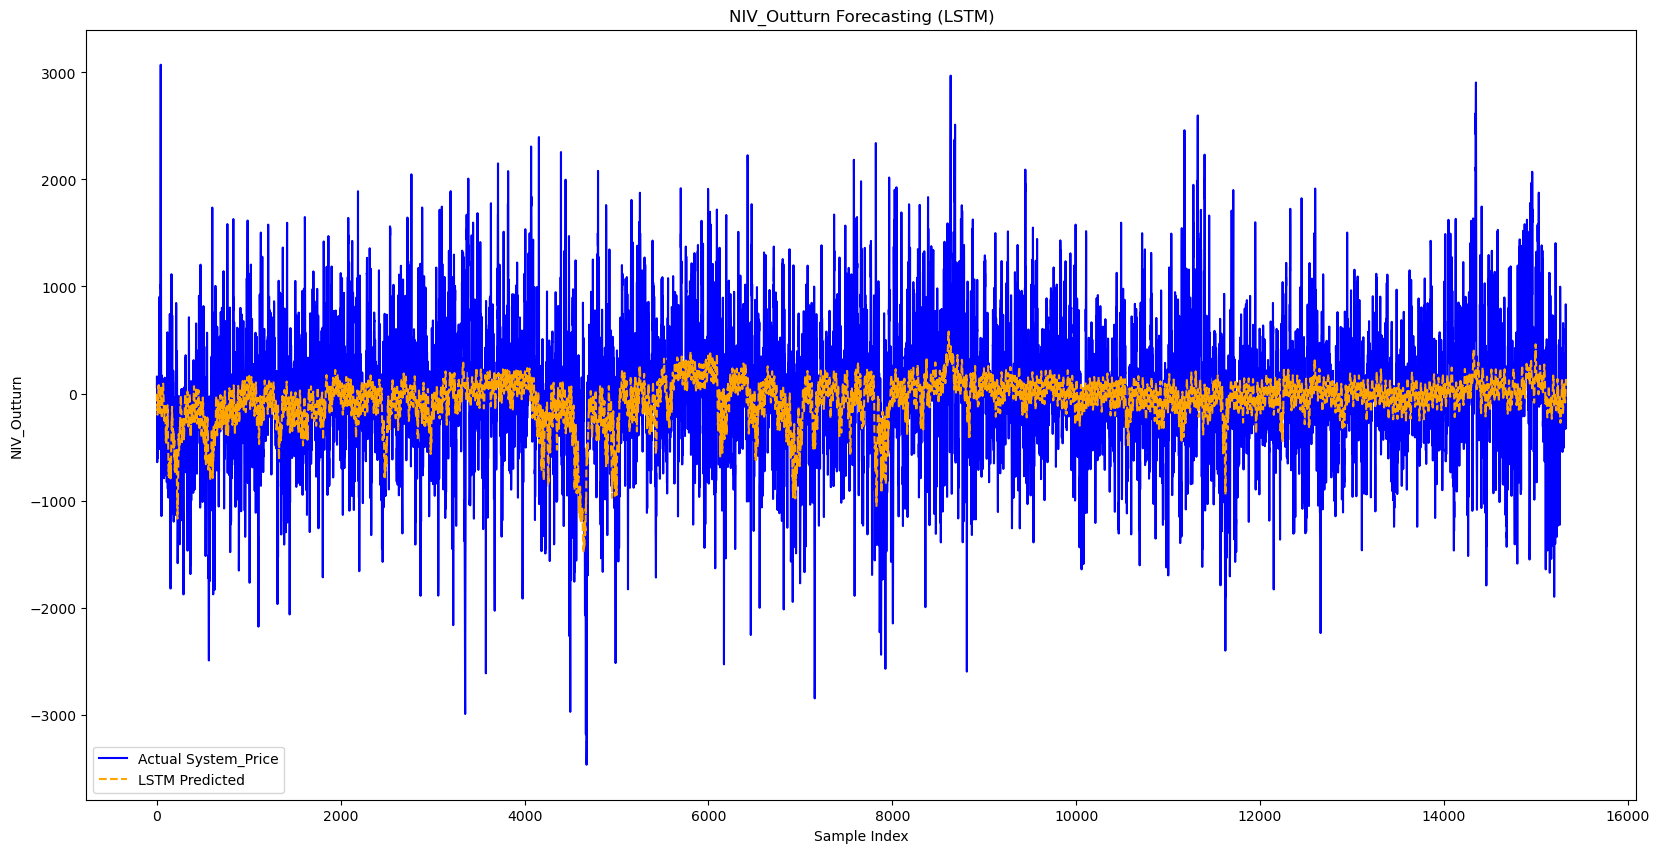

Future Predictions: [ -1.1889582 -45.64612    74.91606    50.79279    66.05948    61.76918
  59.87936    88.52409   108.806915   20.956396   10.988843   30.365347
  91.02631    73.317825   50.696896   49.829166   66.00646    97.76698
  23.497986  -15.187582   14.083579    9.990138   22.664953  -23.101984
  34.528564   19.765123   74.196465   31.537128   32.22944    62.063103
  96.114555   46.3567     68.608864   -9.974984   23.534628   67.55402
   7.6044745  39.78443    -9.446786   -3.5867064 -10.483692   12.332923
  19.049034    9.075244   27.1868      3.7410243  16.55812     4.192819 ]


In [ ]:
# Load the best model
lstm_model_best_val = load_model('best_model.keras', custom_objects={'Attention': Attention,
        "TransformerEncoder": TransformerEncoder,
        "PositionalEncoding": PositionalEncoding,
    })
# Assuming 'lstm_model_best_val' is your trained model
# 'last_val_targets' is the scaled array of the last `time_step` known target values
# 'test_exog_scaled' contains the exogenous variables for the test set

# Ensure the last targets and exogenous inputs are properly shaped
last_val_targets = y_val_scaled[-time_step:].reshape(1, time_step, 1)  # Shape: (1, time_step, 1)
test_exog_scaled = X_test_exog_scaled.reshape(test_size, X_test_exog_scaled.shape[1])  # Shape: (test_size, num_features)

# Step 1: Prepare the last `time_step` target values and their corresponding exogenous features
last_target_values = y_val_scaled[-time_step:].reshape(1, time_step, 1)  # Shape: (1, 48, 1)
last_exog_features = X_val_scaled[-time_step:]  # Shape: (48, num_features)

# Combine the last target values with their exogenous features
last_combined_features = np.concatenate(
    [last_target_values, last_exog_features.reshape(1, time_step, -1)], axis=2
)  # Shape: (1, 48, num_features + 1)

# Step 2: Prepare the exogenous features for the next timestep
future_exog_features = X_test_exog_scaled[0].reshape(1, 1, -1)  # Shape: (1, 1, num_features)

# Add a dummy target feature to future_exog_features
dummy_target = np.zeros((future_exog_features.shape[0], future_exog_features.shape[1], 1))
future_exog_features_with_target = np.concatenate([dummy_target, future_exog_features], axis=2)

# Concatenate the last `time_step` from `last_combined_features` with the future exogenous features
input_sequence = np.concatenate(
    [last_combined_features[:, -time_step + 1:, :], future_exog_features_with_target], axis=1
)

# Truncate to the model's expected input length (48 time steps)
input_sequence = input_sequence[:, -time_step:, :]  # Keep the last 48 time steps



# Step 4: Predict the next timestep
next_prediction = lstm_model.predict(input_sequence)  # Shape: (1, 48)

# Step 5: Inverse transform the prediction to the original scale
next_prediction_original = scaler_y.inverse_transform(next_prediction)

print("Next Timestep Prediction:", next_prediction_original)

# Convert future predictions back to original scale
future_preds_scaled = np.array(next_prediction_original).reshape(-1, 1)

y_train_pred = lstm_model.predict(X_train_combined) 
y_val_pred = lstm_model.predict(X_val_combined)   

# Inverse transform the predictions to original scale
final_train_preds = scaler_y.inverse_transform(y_train_pred)
y_train_original = scaler_y.inverse_transform(y_train)
y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
y_val_original = scaler_y.inverse_transform(y_val)

# Calculate residuals
train_residuals = y_train_original - final_train_preds

# Calculate RMSE as a single number
rmse = np.sqrt(np.mean((y_val_original - y_val_pred_original)**2))

# Print RMSE
print("Overall Val RMSE:", rmse)

# Example index for the length of the dataset used for the plot
index = np.array(df.index)

# Example plot adjustment for multi-step forecast
shorten = 750  # Assuming 750 is a valid index based on your dataset
plt.figure(figsize=(20, 10))
plt.plot(y_train_original[shorten:, 0], label='Actual System_Price', color='blue')  # Plotting only the first step as example
plt.plot(final_train_preds[shorten:, 0], label='LSTM Predicted', linestyle='dashed', color='orange')  # Same here for consistency
plt.title(f'{target} Forecasting (LSTM)')
plt.xlabel('Sample Index')
plt.ylabel(target)
plt.legend()
plt.show()

In [10]:
print("last_combined_features shape:", last_combined_features.shape)
print("future_exog_features shape:", future_exog_features.shape)

last_combined_features shape: (1, 48, 65)
future_exog_features shape: (1, 1, 64)


#### Run the LSTM and make predictions

In [ ]:
def LSTM_predictions(time_step, X_train, X_test, y_train, y_test, target_scaler, index, target):
   """
   Trains an LSTM model for time series forecasting, makes predictions, and evaluates performance.

   Parameters:
   - time_step (int): Number of time steps in each input sequence.
   - X_train (np.array): Training input data for the LSTM.
   - X_test (np.array): Testing input data for the LSTM.
   - y_train (np.array): Training target data for the LSTM.
   - y_test (np.array): Testing target data for the LSTM.
   - target_scaler (StandardScaler): Scaler used to normalize the target variable.
   - index (pd.Index): Index of the original DataFrame, used for plotting.

   Returns:
   - final_train_preds (np.array): Predictions on the training set (original scale).
   - final_test_preds (np.array): Predictions on the testing set (original scale).
   - train_residuals (np.array): Residuals for the training set.
   - test_residuals (np.array): Residuals for the testing set.

   Function Details:
   1. **Inverse Transformation Helper**:
      - `inverse_transform_preds` restores scaled predictions to their original scale and shifts them for alignment.

   2. **LSTM Model Construction**:
      - Two stacked LSTM layers with 96 units each.
      - Two Dense layers for output refinement.
      - Compiled with Adam optimizer and Mean Squared Error loss.

   3. **Training**:
      - Trains the model using the training data (`X_train`, `y_train`) for 3 epochs with a batch size of 96.
      - Batch size ensures efficient GPU utilization.

   4. **Predictions**:
      - Generates predictions for both training and testing sets.
      - Inverse transforms the predictions and target values to their original scale.

   5. **Residual Calculation**:
      - Computes residuals as the difference between actual and predicted values for both training and testing sets.

   6. **Evaluation**:
      - Calculates RMSE for testing and training sets as a performance metric.
      - Outputs RMSE to assess the model's accuracy.

   7. **Visualization**:
      - Plots actual vs. predicted values for the testing set.
      - Plots residual analysis for the training set over time.
   """


### Meta Model

#### Preparing the data for the Meta Model

In [ ]:
def Prepare_data_Metamodel(df_with_preds, final_train_preds, lgbm_in_sample_preds, xgb_seq_in_sample_preds, Day_Ahead_Price_lag_48, LSTM_final_test_preds, LGBM_final_predictions, XGB_sequential_preds, target): 
    """
    Prepares meta-features for training and testing a meta-model by combining predictions from base models.

    Parameters:
    - final_train_preds (np.array): LSTM predictions on the training set.
    - lgbm_in_sample_preds (np.array): LGBM predictions on the training set.
    - xgb_seq_in_sample_preds (np.array): XGBoost sequential predictions on the training set.
    - Day_Ahead_Price_lag_48 (pd.Series): Lagged day-ahead prices (48 steps).
    - LSTM_final_test_preds (np.array): LSTM predictions on the testing set.
    - LGBM_final_predictions (np.array): LGBM predictions on the testing set.
    - XGB_sequential_preds (np.array): XGBoost sequential predictions on the testing set.

    Returns:
    - X_meta_train (pd.DataFrame): Meta-feature training set.
    - X_meta_test (pd.DataFrame): Meta-feature testing set.
    - y_meta_train (pd.Series): Target variable for the training set.
    - y_meta_test (pd.Series): Target variable for the testing set.

    Function Details:
    1. **Aligning Variable Lengths**:
       - Ensures all input variables have the same length by trimming them to match the shortest input length.
       - This is necessary to avoid dimension mismatches when creating the meta-feature DataFrames.

    2. **Meta-Feature Creation**:
       - Combines predictions from base models (LSTM, LGBM, XGBoost) and lagged variables into meta-feature DataFrames:
         - `meta_features_train`: For training, combines aligned in-sample predictions.
         - `meta_features_test`: For testing, combines out-of-sample predictions.

    3. **Feature Selection**:
       - Selects appropriate features for the meta-model based on the target variable:
         - If `target` is `"System_Price"`, uses LSTM, LGBM, XGB, and DAP_lag48 as features.
         - If `target` is `"NIV_Outturn"`, excludes `DAP_lag48` as a feature.

    4. **Train-Test Splitting**:
       - Splits the meta-feature DataFrames into `X_meta_train`, `X_meta_test` (features) and `y_meta_train`, `y_meta_test` (target).
    """
    # Function to trim variables to the same length
    def align_lengths(*args):
        """
        Aligns the lengths of multiple variables by trimming all to the shortest length.
        Args:
        - args: Multiple lists, Series, or arrays to align.

        Returns:
        - A list of trimmed variables with the same length.
        """
        min_length = min(len(arg) for arg in args)  # Find the shortest length
        return [arg[-min_length:] for arg in args]  # Trim all variables to the shortest length

    # Align train variables
    aligned_train_vars = align_lengths(
        final_train_preds, lgbm_in_sample_preds, xgb_seq_in_sample_preds, Day_Ahead_Price_lag_48, df_with_preds[target].dropna()
    )
    # Unpack aligned variables
    final_train_preds_aligned, lgbm_in_sample_preds_aligned, xgb_seq_in_sample_preds_aligned, DAP_lag48_aligned, system_price_aligned = aligned_train_vars

    # Create train DataFrame
    meta_features_train = pd.DataFrame({
        'LSTM': pd.Series(final_train_preds_aligned).reset_index(drop=True),
        'LGBM': pd.Series(lgbm_in_sample_preds_aligned).reset_index(drop=True),
        'XGB': pd.Series(xgb_seq_in_sample_preds_aligned),
        'DAP_lag48': pd.Series(DAP_lag48_aligned).reset_index(drop=True),
        target: pd.Series(system_price_aligned).reset_index(drop=True)
    })

    # Combine predictions into a DataFrame
    meta_features_test = pd.DataFrame({
        'LSTM': LSTM_final_test_preds,
        'LGBM': LGBM_final_predictions,
        'XGB': XGB_sequential_preds,
        'DAP_lag48': Day_Ahead_Price_lag_48.tail(48),
        target: pd.Series([0] * 48)  # placeholder
    })

    if target == "System_Price":
        features = ['LSTM', 'LGBM', 'XGB', 'DAP_lag48']
    elif target == "NIV_Outturn":
        features = ['LSTM', 'LGBM', 'XGB']
    else:
        raise KeyboardInterrupt
    # Split features and target for training
    X_meta_train = meta_features_train[features]
    X_meta_test = meta_features_test[features]

    y_meta_train = meta_features_train[target]
    y_meta_test = meta_features_test[target]
    
    return X_meta_train, X_meta_test, y_meta_train, y_meta_test

#### Creating predictions with the meta model

In [ ]:
def Metamodel_predictions(X_meta_train, y_meta_train, y_meta_test, X_meta_test, target):
    """
    Trains a meta-model using multiple base model predictions and evaluates its performance.

    Parameters:
    - X_meta_train (pd.DataFrame): Training feature set for the meta-model.
    - y_meta_train (pd.Series): Target variable for the training set.
    - y_meta_test (pd.Series): Target variable for the testing set.
    - X_meta_test (pd.DataFrame): Testing feature set for the meta-model.

    Returns:
    - meta_predictions (np.array): Predictions made by the meta-model on the testing set.
    - residuals (pd.Series): Residuals (differences between actual and predicted values) for the testing set.

    Function Details:
    1. **Equal Weighted Baseline**:
       - Calculates the average of all meta-features for the testing set and evaluates its performance as a baseline.

    2. **Linear Regression Meta-Model**:
       - Fits a linear regression model to the meta-features without an intercept (`fit_intercept=False`).
       - Outputs the coefficients for each feature.

    3. **Non-Negative Least Squares (NNLS)**:
       - Fits a NNLS model to enforce non-negative weights on the meta-features.
       - Outputs the NNLS-derived weights for each feature.

    4. **Predictions**:
       - Uses the linear regression meta-model to predict target values for the testing set.

    5. **Residuals and Evaluation**:
       - Computes residuals as the difference between actual and predicted values.
       - Evaluates the meta-model's performance using RMSE.

    6. **Visualization**:
       - Plots the actual vs. predicted values for the meta-model.
       - Highlights the meta-model's ability to forecast the target variable.
    """
    print("Equal weighted:")
    metrics(y_meta_test, X_meta_test.mean(axis=1))

    # Create dummy data
    X = X_meta_train
    y = y_meta_train

    X = X.drop(columns=["LGBM"])

    # Linear regression with zero intercept
    lr_model = LinearRegression(fit_intercept=False)
    lr_model.fit(X, y)
    # Attach column names to coefficients
    lr_coeff_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lr_model.coef_
    })
    print("\nLinear Regression Coefficients:")
    print(lr_coeff_df)

    # Non-Negative Least Squares
    nnls_weights, _ = nnls(X, y)

    # Attach column names to coefficients
    nnls_coeff_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': nnls_weights
    })
    print("\nNon-Negative Weights (NNLS):")
    print(nnls_coeff_df)

    # Make predictions on the test set
    meta_predictions = lr_model.predict(X)
    residuals = X[target] - meta_predictions

    # Calculate RMSE
    metrics(y_meta_test, meta_predictions)

    # Plot the results
    plt.figure(figsize=(20, 10))
    plt.plot(y_meta_test.reset_index(drop=True), label=f'Actual {target}', color='blue')
    plt.plot(meta_predictions, label='Meta-Model Predictions', linestyle='dashed', color='orange')
    plt.title(f'{target} Forecasting with Meta-Model')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.show()
    return meta_predictions, residuals


# Employing the Models

# At the beginning, we started with basic, single variate models

### These are the univariate models we trialed when trying to predict non white noise features

In [ ]:
# As as example, you can run them with System Price, which has autoregressive prective power, if you run NIV for example, it will just predict mean
target = "Demand_Outturn"

# ARIMA

ARIMA needs stationarity in the mean and variance, and thus we need to apply some transformations

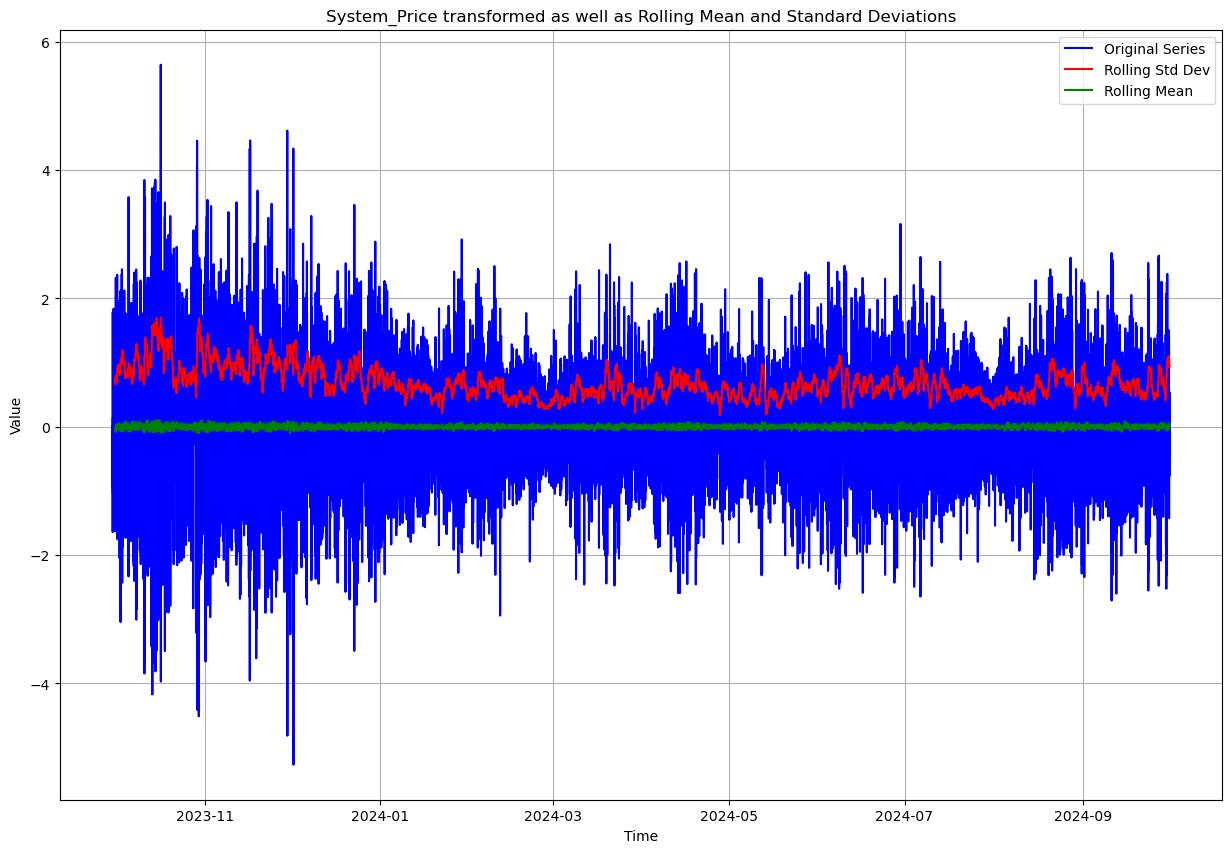

Test RMSE: 39.29


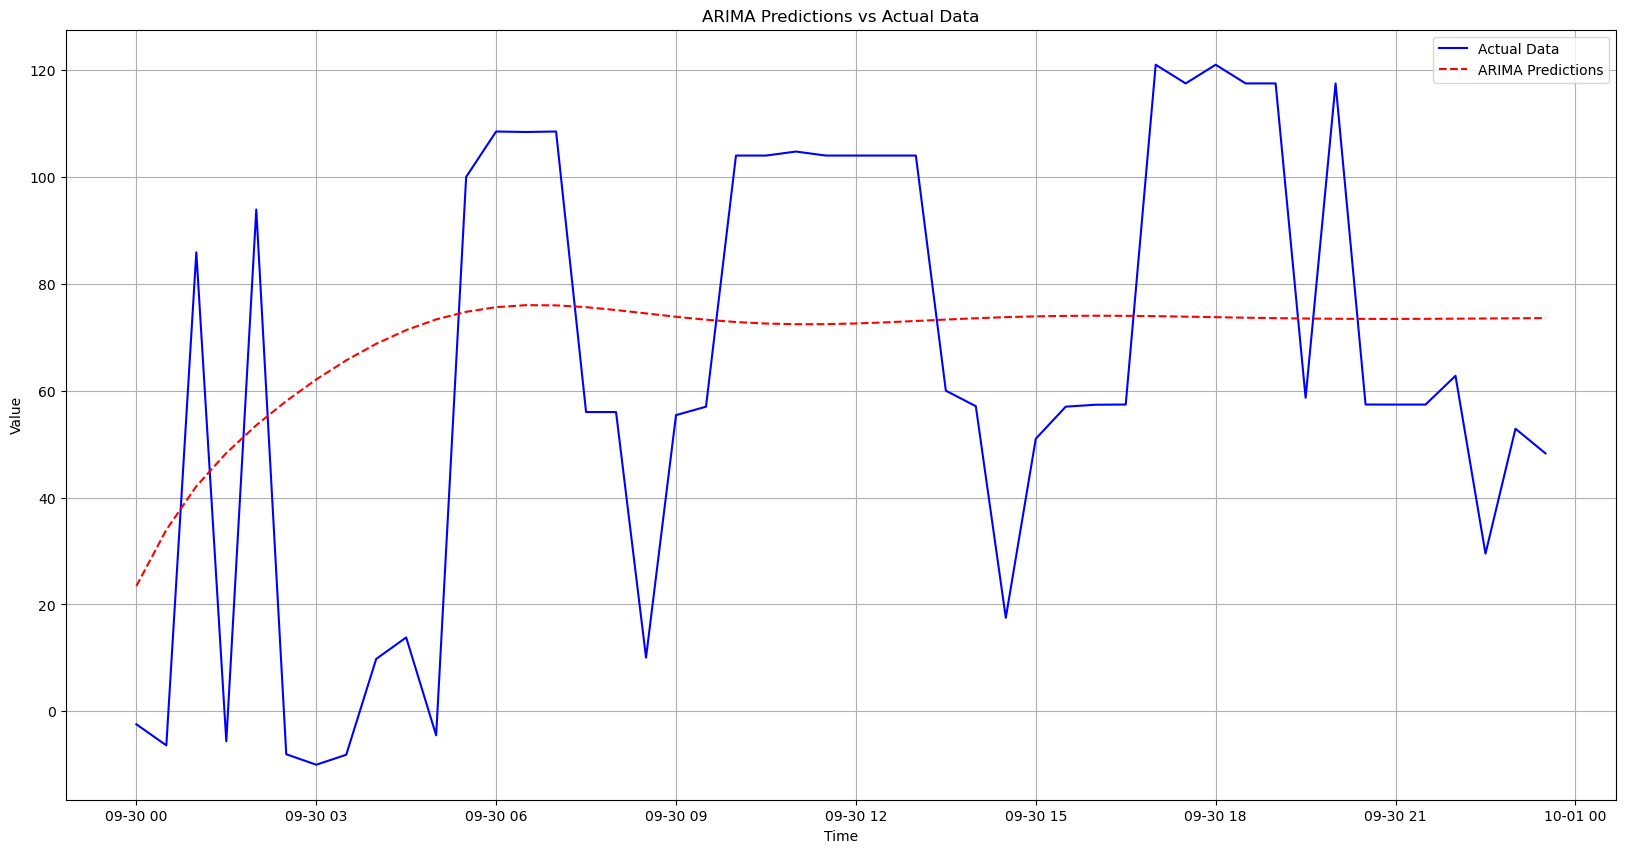

In [ ]:
# Apply the Yeo-Johnson transformation
transformed_df, pt = Yeo_Johnson(merged_df_2024, target)

# Train-test split
test_size = 48  # Number of observations to predict, in order to simulate predicting oct 1st, we predict sept 30th
train, test = train_test_split_index_univariate(transformed_df, test_size)  # test is last day, train is the rest

# Train and Forecast with ARIMA
arima_preds = statsforecast_arima(train[f'{target}_diff'], len(test))

# Inverse Transform Predictions
# Split the in-sample (fitted) and out-of-sample (forecasted) predictions
arima_fitted = arima_preds.iloc[:len(train)]  # In-sample predictions
arima_forecast = arima_preds.iloc[len(train):]  # Forecasted values

# Reverse differencing for the test period
arima_forecast_cumsum = np.cumsum(arima_forecast.values) + train[target].iloc[-1]

# Inverse Yeo-Johnson transformation
arima_inverse_transformed = pt.inverse_transform(pd.DataFrame({target: arima_forecast_cumsum})).flatten()

# Compare with Original Test Data
test_original = pt.inverse_transform(pd.DataFrame({target: test[target]})).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_original, arima_inverse_transformed))
print(f"Test RMSE: {rmse:.2f}")

plot_results(test, test_original, arima_inverse_transformed, "ARIMA")

It did not prove to have useful predictions, it does not fit the shape and stagnates after a while

# Prophet

20:23:55 - cmdstanpy - INFO - Chain [1] start processing
20:24:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 37.544239701692554
Mean Squared Error (MSE): 1863.9087893132917
Root Mean Squared Error (RMSE): 43.173009963555835
R-squared (R2): -0.0472073323971427


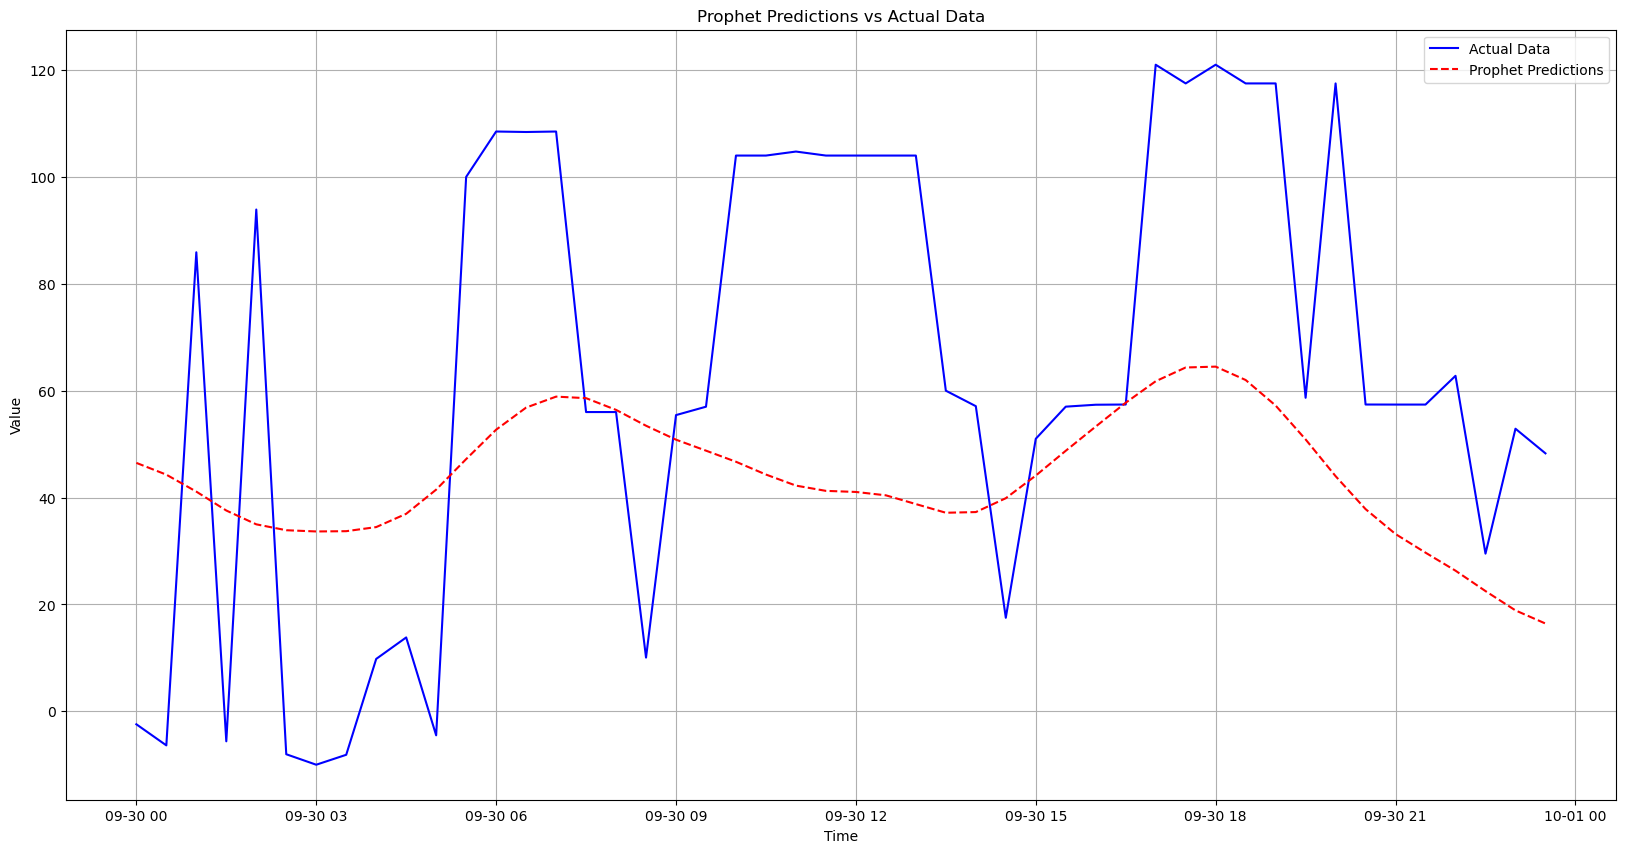

In [ ]:
# Redo the train test split in order to have untransformed data
train, test = train_test_split_index_univariate(merged_df_2024, test_size)
# Calculate predictions with Prophet
prophet_preds = prophet_predictions(train[target], calculate_fft(train[target], 12), len(test))
prophet_preds = prophet_preds["yhat"]  # extract only the predictions
# Merging the predictions of prophet to merged df
prophet_preds.index.name = 'Datetime'

# Split the in-sample (fitted) and out-of-sample (forecasted) predictions
prophet_fitted = prophet_preds.iloc[:len(train)]  # In-sample predictions
prophet_forecast = prophet_preds.iloc[len(train):]  # Forecasted values

# Score the model
metrics(test[target], prophet_forecast)

# Plot Results
plot_results(test, test[target], prophet_forecast, "Prophet")

Tries to fit the shape of the data but the score is still pretty bad. Even worse than ARIMA. THe data is thus more Autoregressive than seasonal

# Prophet + ARIMA

20:24:23 - cmdstanpy - INFO - Chain [1] start processing
20:24:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 36.42935885664458
Mean Squared Error (MSE): 1801.3067550428307
Root Mean Squared Error (RMSE): 42.4418043330256
R-squared (R2): -0.012035381019008584


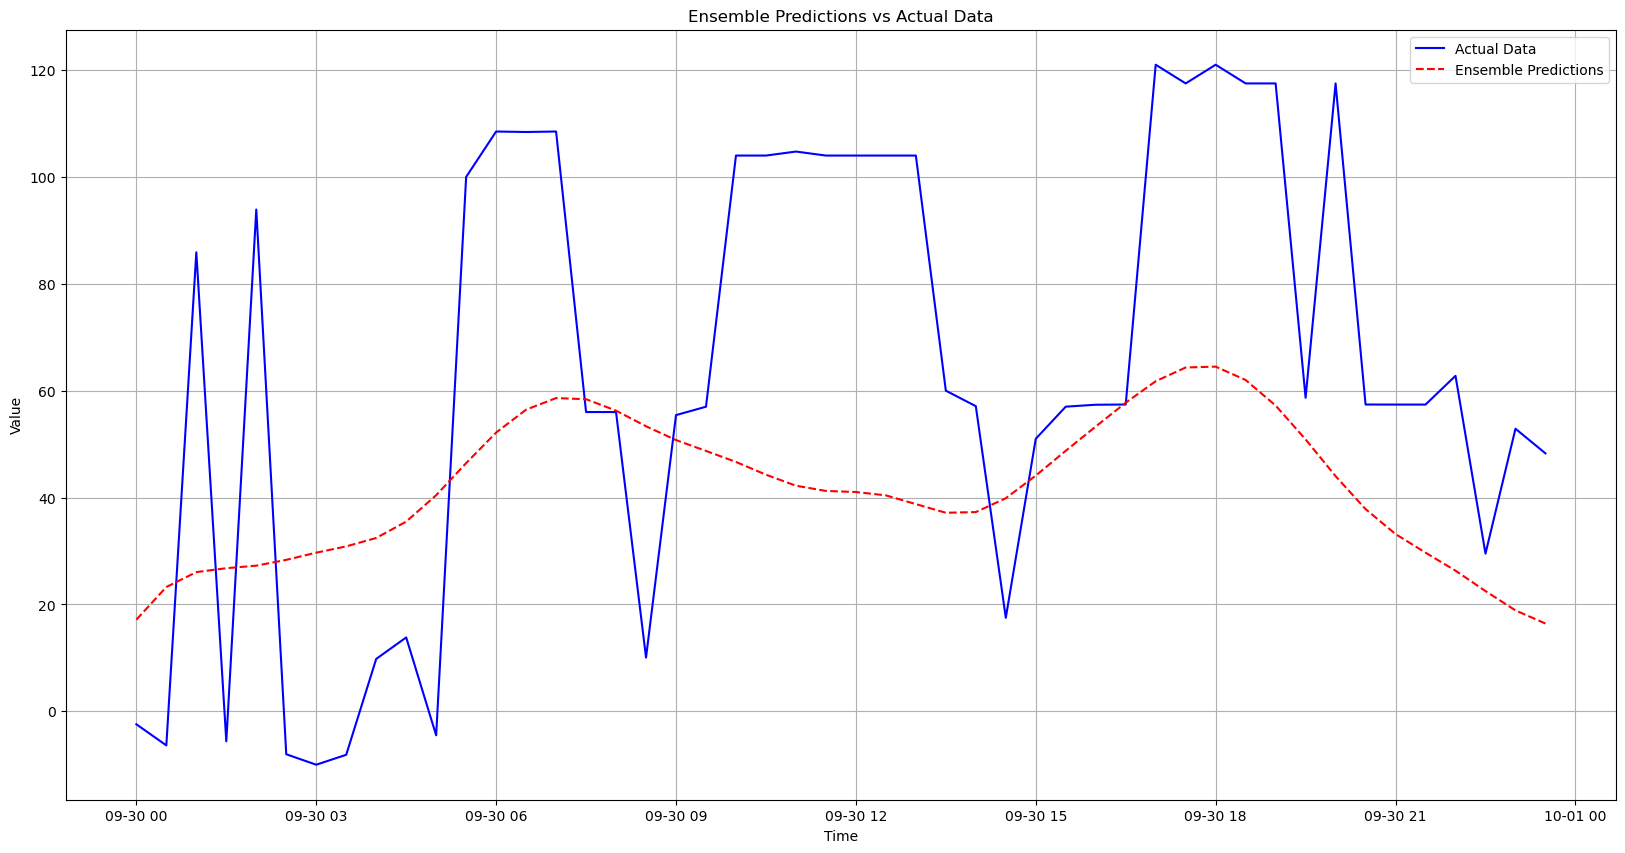

In [ ]:
# Calculate predictions with Prophet
train, test = train_test_split_index_univariate(merged_df_2024, test_size)
# Calculate predictions with the Ensemble
ensemble_preds = ensemble_model(train[target], 12, len(test), target)
ensemble_preds = ensemble_preds["combined_forecast"]  # extract only the predictions
# Merging the predictions of prophet to merged df
ensemble_preds.index.name = 'Datetime'

# Split the in-sample (fitted) and out-of-sample (forecasted) predictions
ensemble_fitted = ensemble_preds.iloc[:len(train)]  # In-sample predictions
ensemble_forecast = ensemble_preds.iloc[len(train):]  # Forecasted values

# Score the model
metrics(test[target], ensemble_forecast)

# Plot Results
plot_results(test, test[target], ensemble_forecast, "Ensemble")

We try to combine the power of both, and while it betters the Prophet predictions, it is still too basic

# Univariate LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 96)             │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 12)             │         1,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,429 (454.80 KB)

 Trainable params: 38,809 (151.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,620 (303.21 KB)

None
3695/3695 ━━━━━━━━━━━━━━━━━━━━ 87s 23ms/step


Mean Absolute Error (MAE): 28.59392016768456
Mean Squared Error (MSE): 1352.7807097027357
Root Mean Squared Error (RMSE): 36.780167341962105
R-squared (R2): 0.23996180153856128


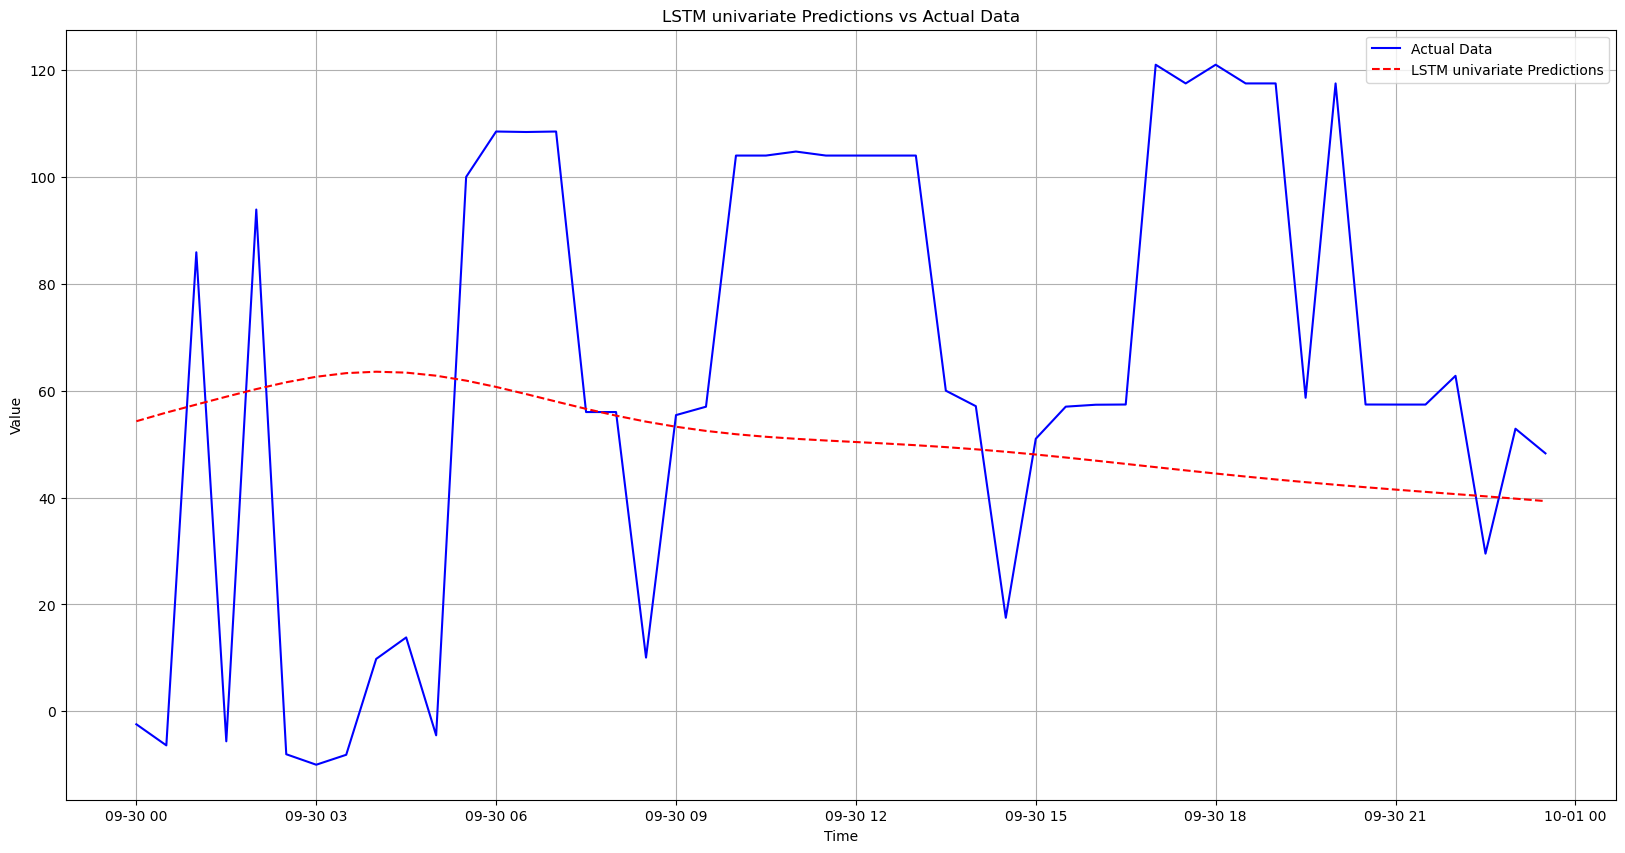

In [38]:
# Calculate predictions with LSTM
time_step = 96
test_size = 48
n_future_steps = test_size + 1  # due to how we set up our lstm

LSTM_future_preds, LSTM_in_sample_preds = univariate_LSTM(merged_df[[target]], n_future_steps, time_step, target, measuring=True)

train, test = train_test_split_index_univariate(merged_df_2024, test_size)

# Score the model
print("\n")
metrics(test[target], LSTM_in_sample_preds[-len(test):])

# Plot Results
plot_results(test, test[target], LSTM_future_preds, "LSTM univariate")

# Multivariate Models

### Adding Features and filling in the X for t+1 to t+48

In [21]:
df_with_preds, Day_Ahead_Price_lag_48, not_predicted_columns = feature_engineering(merged_df_2024)  # Fill in t+1 to t+48 and add lagged values for the cols we can't predict
df_with_preds = reduce_mem_usage(df_with_preds, verbose=True)  # reduce memory usage so there is more memory for computing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

In [ ]:
#df_with_preds = pd.read_csv("trying333.csv", index_col="Datetime")
##df_with_preds.drop(columns=["value", "Unnamed: 0"], inplace=True, errors="ignore")
#df_with_preds.index = pd.to_datetime(df_with_preds.index)

# First, we start with NIV Outturn

In [415]:
target = "NIV_Outturn"

# Linear Regression

In [416]:
not_predicted_columns = ['Hydro_Run-of-River_and_Poundage_missing',
 'Total_Load_missing',
 'Fossil_Oil',
 'Day_Ahead_Price',
 'BM_Offer_Acceptances',
 'Wind_Offshore_missing',
 'Fossil_Oil_missing',
 'Day_Ahead_Price_missing',
 'Fossil_Hard_Coal_missing',
 'System_Price_missing',
 'Fossil_Gas_missing',
 'NIV_Outturn_missing',
 'BM_Bid_Acceptances_missing',
 'Solar_missing',
 'Intraday_Price',
 'Loss_of_Load_Prob',
 'Intraday_Price_missing',
 'Hydro_Pumped_Storage_missing',
 'BSAD_Turn_Down_missing',
 'BM_Offer_Acceptances_missing',
 'BSAD_Turn_Up_missing',
 'Loss_of_Load_Prob_missing',
 'NIV_Outturn',
 'BSAD_Total_missing',
 'EPEX_Intraday_Volume_missing',
 'BM_Bid_Acceptances',
 'Wind_Onshore_missing',
 'value',
 'Demand_Outturn_missing',
 'System_Price',
 'Biomass_missing',
 'Nuclear_missing']


Linear Regression Coefficients:
                                 Feature   Coefficient
34                      hr_17616.00h_sin  1.890674e+06
16                                  LoLP  2.084455e+04
33                         hr_48.00h_cos  1.796762e+03
32                         hr_48.00h_sin  8.530737e+02
31                         hr_24.00h_cos  5.253176e+02
28                           close_price  6.828779e+01
27                              is_night  4.506436e+01
47                       BSAD_Total_diff  3.544915e+01
5                           BSAD_Turn_Up  3.375227e+01
6                         BSAD_Turn_Down  3.374489e+01
26                          is_peak_hour  1.467508e+01
58           Exports-Imports-Stored_diff  8.943238e+00
37                                 month  7.615805e+00
57                 Total_Generation_diff  5.832339e+00
49                    Wind_Offshore_diff  4.502221e+00
48                     Wind_Onshore_diff  4.470042e+00
53                            So

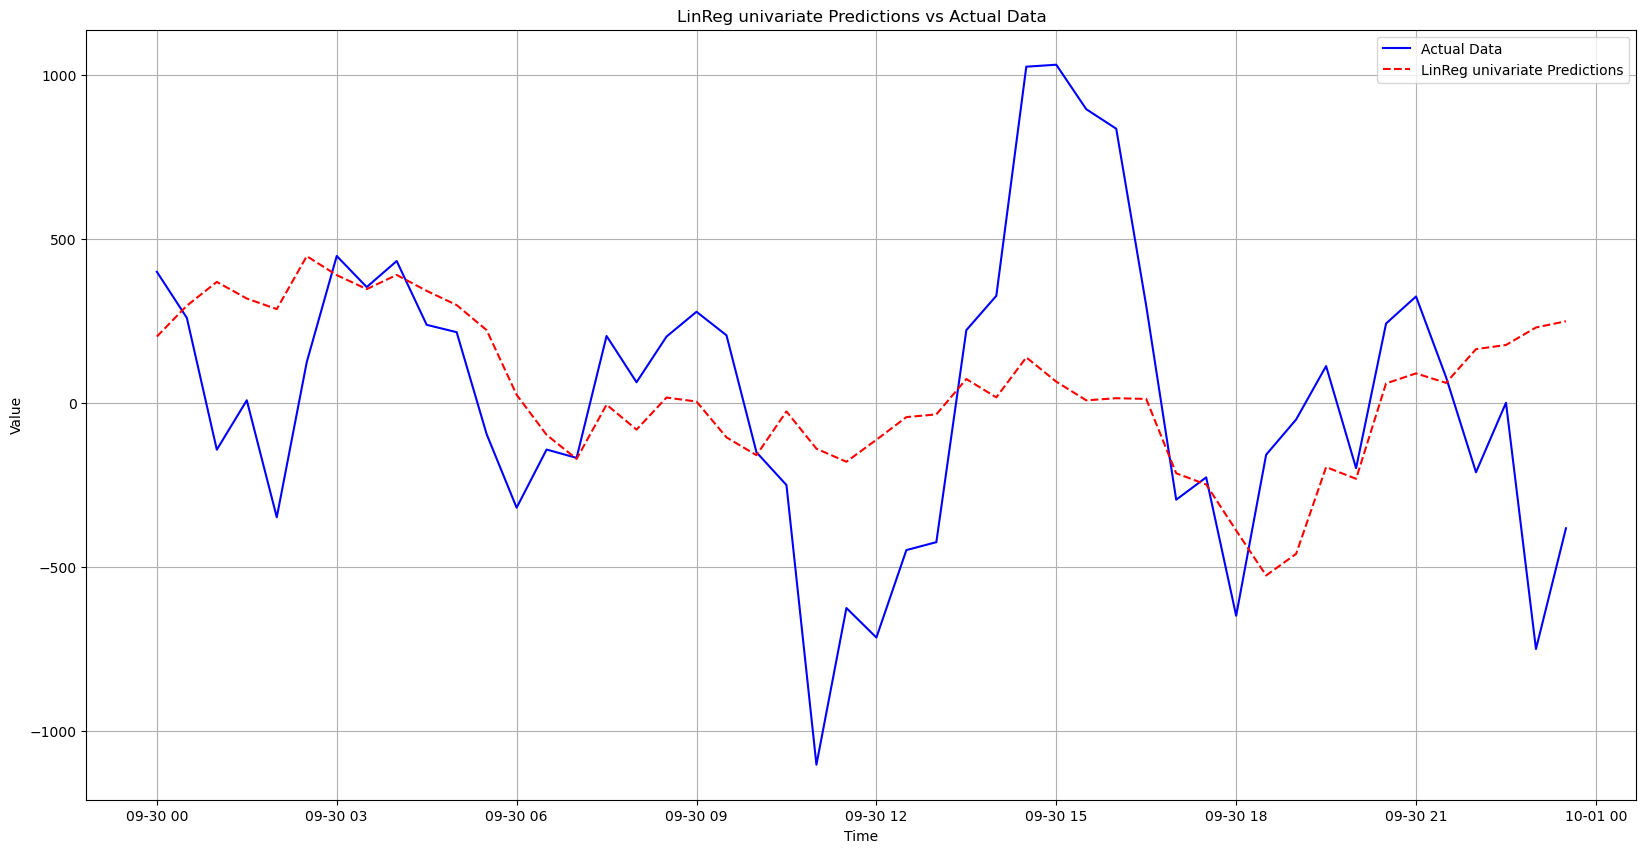

In [417]:
linreg_drop = not_predicted_columns + ["System_Price_lag_1", "System_Price_lag_2", "NIV_Outturn_lag_1", "NIV_Outturn_lag_2"]
LinReg_predictions = Linear_Regresson(df_with_preds, 48, target, linreg_drop)

In [418]:
LinReg_predictions

array([ 202.72896414,  296.6825594 ,  369.20415511,  318.52957605,
        286.32039044,  447.65963374,  389.85987884,  347.30229673,
        390.44624405,  341.90714226,  298.64956213,  222.20675271,
         25.28503414,  -96.92225457, -170.2259342 ,   -4.89313577,
        -80.83466305,   16.87386198,    4.60148003, -104.52607725,
       -158.71781998,  -25.47204178, -139.05045628, -178.79802383,
       -111.83229552,  -42.76178539,  -34.43499883,   73.23180963,
         17.35678423,  139.27166068,   65.2381781 ,    8.33999544,
         14.80749827,   12.60019654, -213.9627447 , -248.07816926,
       -388.2066811 , -525.32255972, -459.4225371 , -195.12104332,
       -230.79583876,   60.00913674,   90.38754618,   61.56512659,
        164.33085633,  176.96000993,  230.34794943,  249.35114845])

This gives us an RMSE score of 738.18 on the calculator, still some work to do

# XGBoost 

### We first prepare the data, so that it is in the right format

In [419]:
pred_length = 48
to_drop_NIV = not_predicted_columns + ["Loss_of_Load_Prob", "Loss_of_Load_Prob_diff", "open_price", "close_price", "Fossil_Oil", "Fossil_Oil_diff"]
X_train, X_test, X_val, y_val, y_train, y_test, dtrain, dval, dtest, column_names = XGBoost_preparing_data(df_with_preds, pred_length, to_drop_NIV, target)

### Run the XGBoost

[I 2024-12-05 14:08:04,553] A new study created in memory with name: no-name-38cde00b-ae4d-4a66-9da9-4a741766dca6
[I 2024-12-05 14:08:21,542] Trial 0 finished with value: 235.34178371310261 and parameters: {'learning_rate': 0.00659044102996629, 'subsample': 0.7326927059084078, 'max_depth': 7, 'min_child_weight': 0.10099127044175614, 'colsample_bytree': 0.4051433379973869, 'gamma': 0.4313561812942762}. Best is trial 0 with value: 235.34178371310261.
[I 2024-12-05 14:08:35,685] Trial 1 finished with value: 250.3397996224771 and parameters: {'learning_rate': 0.006480392563716329, 'subsample': 0.30345537167367487, 'max_depth': 7, 'min_child_weight': 0.5831654975510763, 'colsample_bytree': 0.4857134725453638, 'gamma': 2.7528703650497595}. Best is trial 0 with value: 235.34178371310261.
[I 2024-12-05 14:08:38,655] Trial 2 finished with value: 278.59996187885906 and parameters: {'learning_rate': 0.010446474379603951, 'subsample': 0.8218635451162104, 'max_depth': 3, 'min_child_weight': 0.06877

Best hyperparameters: {'learning_rate': 0.010015030001518174, 'subsample': 0.6684586048312627, 'max_depth': 9, 'min_child_weight': 0.00386688854711834, 'colsample_bytree': 0.40802853805116657, 'gamma': 2.2530041225161486}
Mean Absolute Error (MAE): 111.96442956020641
Mean Squared Error (MSE): 21144.225195068007
Root Mean Squared Error (RMSE): 145.41054017872298
R-squared (R2): 0.9449602168870117


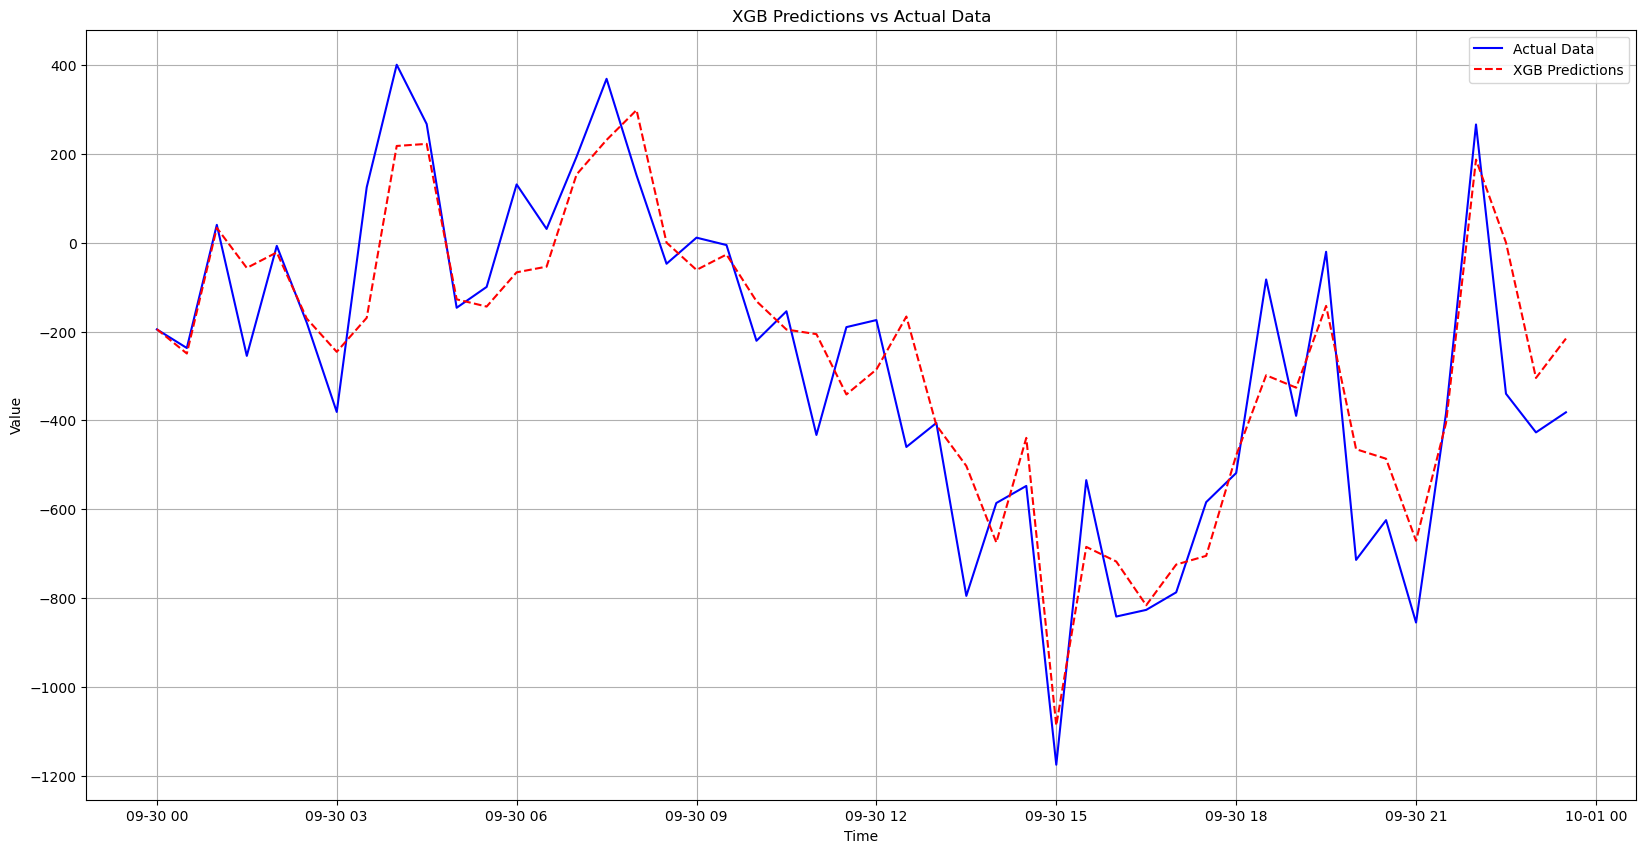

In [ ]:
XGB_final_model = XGBoost_optimization(dtrain, dval, y_val, column_names)
XGB_y_pred, XGB_y_preds_in_sample, XGB_residuals = XGBoost_optimized_predict(XGB_final_model, dtrain, dtest, dval, y_train, y_val)

In [421]:
XGB_y_pred

array([-162.8267   , -146.28427  , -167.58817  , -165.67068  ,
       -181.80252  , -155.92218  , -118.16612  ,  -73.71503  ,
        -26.575834 ,   -4.2069874,  -19.635471 ,  -74.45232  ,
       -105.690735 , -114.63344  ,  -84.26083  ,  -96.781906 ,
        -89.18903  , -107.70018  ,  -90.27849  , -104.93076  ,
        -99.74134  , -121.176765 , -115.846344 , -121.382706 ,
       -164.4612   , -129.69513  , -141.62656  , -116.59527  ,
        -97.70167  , -124.66531  , -143.9759   , -150.97156  ,
       -150.9741   , -186.13779  , -160.14435  , -137.67126  ,
        -89.384926 ,  -82.37189  ,  -61.40698  ,  -58.41962  ,
       -114.989075 , -119.40126  , -118.729675 , -104.839584 ,
       -131.03775  , -115.47031  , -117.034225 , -121.06575  ,
       -146.55043  ], dtype=float32)

This gives us a score of 582.94 on the excel calculator 

In [499]:
pd.Series(XGB_y_pred).to_csv("NIV_submission.csv")

### We try to make sequential predictions for XGBoost, updating each row with each prediction

Mean Absolute Error (MAE): 112.82937963655839
Mean Squared Error (MSE): 20367.801110727258
Root Mean Squared Error (RMSE): 142.71580539914723
R-squared (R2): 0.8375442378603335


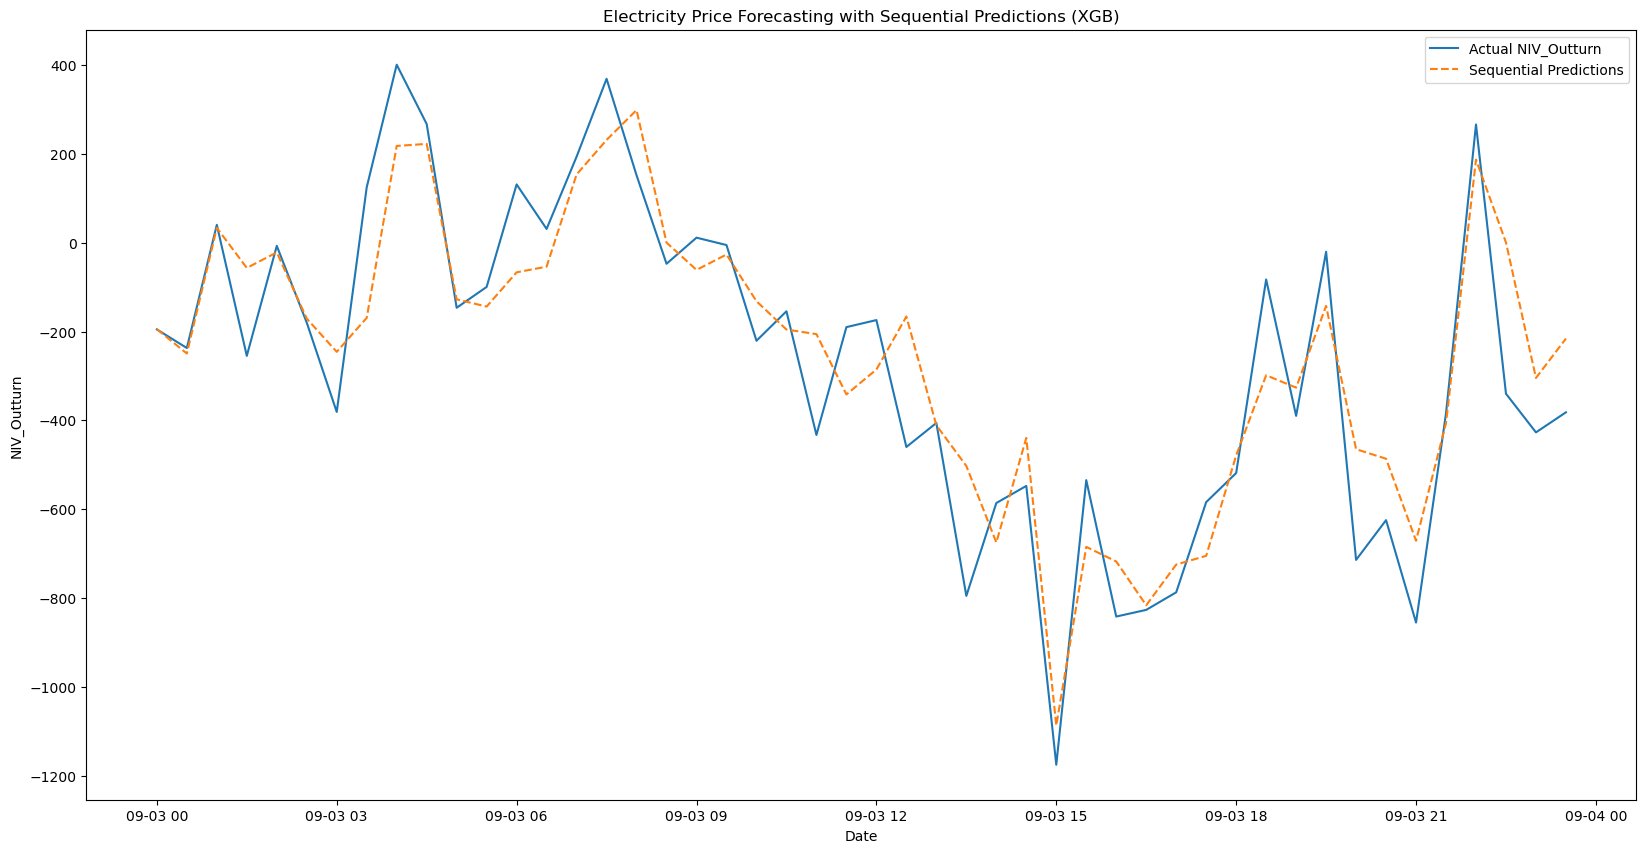

In [422]:
XGB_seq_in_sample_preds, XGB_sequential_preds, XGB_seq_residuals = XGBoost_optimized_sequential_predictions(XGB_final_model, dtrain, dval, X_test, X_val, y_test, y_train, y_val, 49, target)

In [423]:
XGB_sequential_preds.values

array([-162.8267   , -147.75032  , -114.91885  , -112.65595  ,
       -118.06638  , -102.52477  ,  -65.7317   ,  -18.07642  ,
         27.944613 ,   44.830227 ,   34.503113 ,    3.96462  ,
        -16.027971 ,  -35.227074 ,  -21.484285 ,  -32.775238 ,
        -25.96683  ,  -60.667797 ,  -41.95357  ,  -42.928665 ,
        -32.467    ,  -42.775898 ,  -35.65502  ,  -44.349632 ,
        -76.37839  ,  -56.49977  ,  -75.42205  ,  -51.390854 ,
        -39.613205 ,  -47.46321  ,  -78.42244  ,  -99.14504  ,
        -82.36597  , -143.77612  , -132.89975  , -101.61039  ,
        -61.574104 ,  -55.05641  ,  -33.278206 ,  -13.090321 ,
        -63.776657 ,  -70.35879  ,  -55.31862  ,  -27.187876 ,
        -34.88777  ,  -17.486635 ,   -5.8402233,    8.386583 ,
        -63.945927 ], dtype=float32)

This gives us a score of 614.72 on the excel calculator, worse. lets try something new

# LGBM

[I 2024-12-05 00:39:45,297] A new study created in memory with name: no-name-4da6f78b-6796-47f1-9880-5b30390b06a7
[I 2024-12-05 00:40:21,099] Trial 0 finished with value: 281.27696079578783 and parameters: {'learning_rate': 0.007488016639669303, 'num_leaves': 137, 'max_depth': 8, 'colsample_bytree': 0.5409633260860737, 'subsample': 0.7586613204716914, 'max_bin': 141}. Best is trial 0 with value: 281.27696079578783.
[I 2024-12-05 00:40:39,086] Trial 1 finished with value: 76.64953041152934 and parameters: {'learning_rate': 0.0022055842103887702, 'num_leaves': 57, 'max_depth': 15, 'colsample_bytree': 0.16722562436580643, 'subsample': 0.6809354289235681, 'max_bin': 143}. Best is trial 1 with value: 76.64953041152934.
[I 2024-12-05 00:41:08,593] Trial 2 finished with value: 65.34727051373179 and parameters: {'learning_rate': 0.0020436202540408195, 'num_leaves': 94, 'max_depth': 11, 'colsample_bytree': 0.16231380377703794, 'subsample': 0.6558735847995684, 'max_bin': 99}. Best is trial 2 wit

Best hyperparameters: {'learning_rate': 0.001169201288332921, 'num_leaves': 139, 'max_depth': 9, 'colsample_bytree': 0.24966681383545933, 'subsample': 0.6171593204715861, 'max_bin': 89}
Best RMSE: 63.392233172308444
Final RMSE: 37.238628752779874


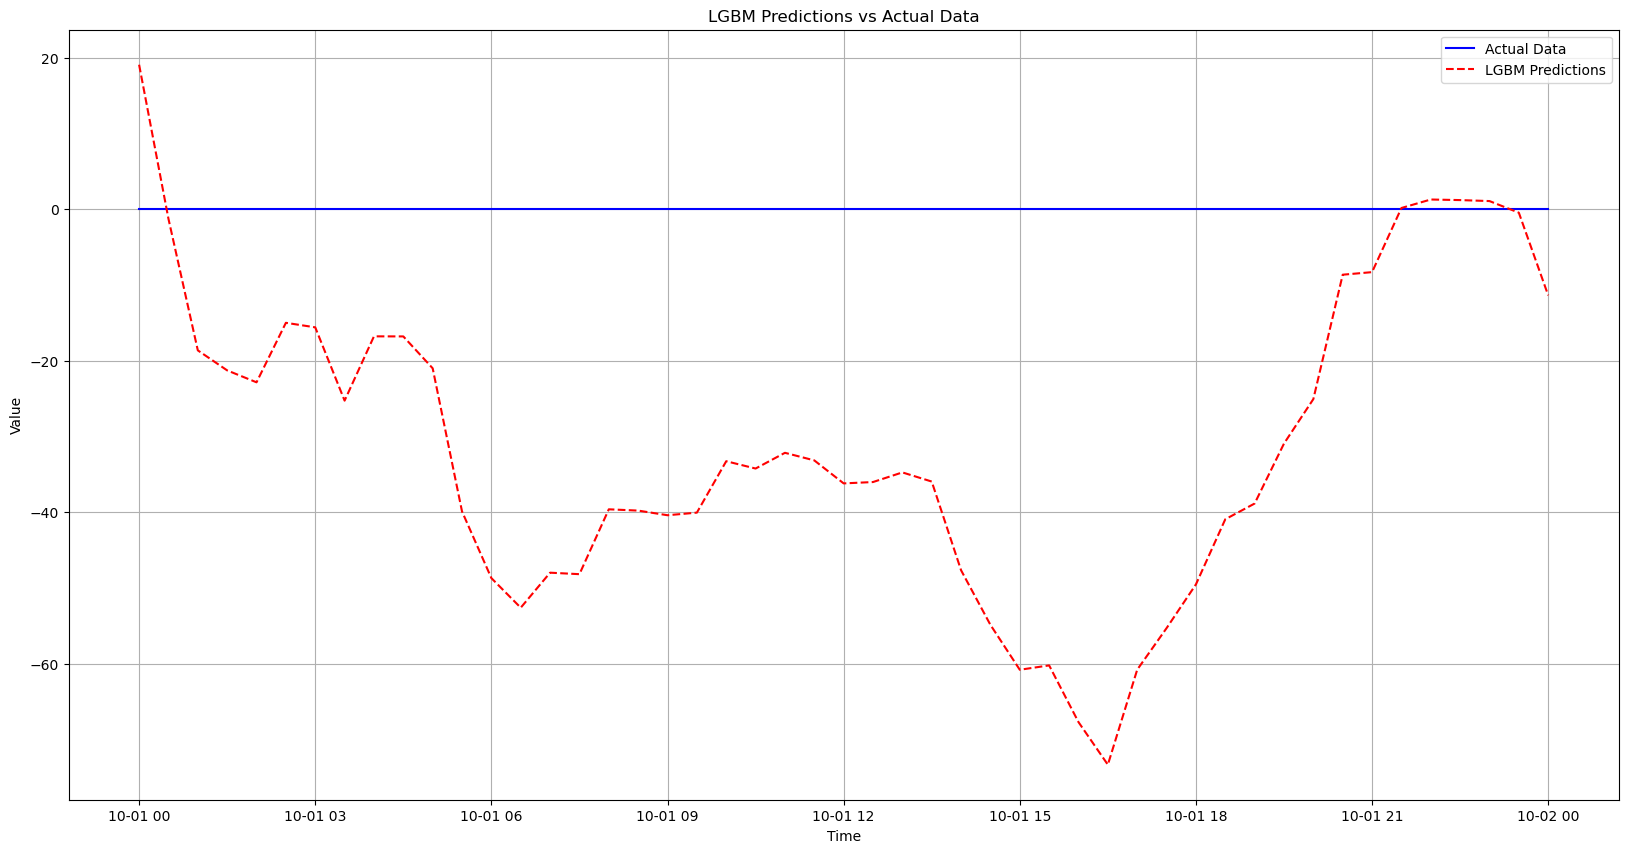

In [ ]:
LGBM_final_model = LGBM_optimization(X_train, X_test, y_train, y_test)
LGBM_in_sample_preds, LGBM_final_predictions, LGBM_residuals = LGBM_optimized_predictions(LGBM_final_model, X_train, X_val, X_test, y_val, y_train)

In [59]:
LGBM_final_predictions

array([ 19.07695473,  -1.27479087, -18.64556354, -21.29084408,
       -22.86409528, -15.00587024, -15.60443887, -25.28520313,
       -16.79413702, -16.8040005 , -21.01200228, -39.91625621,
       -48.7234492 , -52.62858675, -48.00486691, -48.2021304 ,
       -39.63576739, -39.80489628, -40.41831205, -40.07446179,
       -33.28386529, -34.25168012, -32.17355848, -33.17553346,
       -36.21349393, -36.03467948, -34.76274781, -35.9699608 ,
       -47.68539073, -54.89725914, -60.82560461, -60.24926023,
       -67.74047736, -73.36570934, -60.81466052, -55.32893738,
       -49.55118626, -40.95096958, -38.87305792, -30.95336049,
       -25.08111356,  -8.65280734,  -8.31481474,   0.15593732,
         1.27693655,   1.20053426,   1.07069742,  -0.46552372,
       -11.37980832])

This gives us a score on the calculator of 622.28, also worse. Still can be better 

# LSTM

In [ ]:
df_with_preds = pd.read_csv("trying333.csv", index_col="Datetime")
df_with_preds.drop(columns=["value", "Unnamed: 0"], inplace=True, errors="ignore")
df_with_preds.index = pd.to_datetime(df_with_preds.index)
df_with_preds = df_with_preds.drop(columns=["Loss_of_Load_Prob", "Fossil_Oil"])
# Filter rows for 2024-10-01
df_with_preds.loc["2024-10-01", "System_Price"] = df_with_preds.loc["2024-09-30"]["Day_Ahead_Price"].values
target = "System_Price"
time_step = 96
pred_length = 48 + 1  # Due to the way the LSTM function is set up
target_scaler, X_train, X_test, exog_X_train, exog_X_test, y_train, y_test, index = LSTM_prepare_data(df_with_preds, time_step, pred_length, [], target)  # [f"{target}_lag_1", f"{target}_lag_2", f"{target}_diff"]
LSTM_final_train_preds, LSTM_final_test_preds, LSTM_train_residuals = LSTM_predictions(time_step, X_train, X_test, y_train, y_test, target_scaler, index, target)

In [10]:
# Filter rows for 2024-10-01
df_with_preds.loc["2024-10-01", "System_Price"] = df_with_preds.loc["2024-09-30"]["Day_Ahead_Price"].values
target = "System_Price"

In [13]:
time_step = 96
pred_length = 48 + 1  # Due to the way the LSTM function is set up
target_scaler, X_train, X_test, exog_X_train, exog_X_test, y_train, y_test, index = LSTM_prepare_data(df_with_preds, time_step, pred_length, [], target)  # [f"{target}_lag_1", f"{target}_lag_2", f"{target}_diff"]
LSTM_final_train_preds, LSTM_final_test_preds, LSTM_train_residuals = LSTM_predictions(time_step, X_train, X_test, y_train, y_test, target_scaler, index, target)

Epoch 1/3


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 95 and 1 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,95], [1,384].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 95), dtype=float32)
  • states=('tf.Tensor(shape=(None, 96), dtype=float32)', 'tf.Tensor(shape=(None, 96), dtype=float32)')
  • training=True

In [74]:
LSTM_final_test_preds

array([39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828,
       39.65828, 39.65828, 39.65828, 39.65828, 39.65828, 39.65828],
      dtype=float32)

This gives us a score of really bad

# Meta Model

#### We dont end up using this

In [ ]:
X_meta_train, X_meta_test, y_meta_train, y_meta_test = Prepare_data_Metamodel(LSTM_final_train_preds, LGBM_in_sample_preds, XGB_seq_in_sample_preds, Day_Ahead_Price_lag_48, LSTM_final_test_preds, LGBM_final_predictions, XGB_sequential_preds, target)
meta_predictions, residuals = Metamodel_predictions(X_meta_train, y_meta_train, y_meta_test, X_meta_test, target)

# Residual Analysis

In [443]:
actual = df_with_preds["NIV_Outturn"][:-97]
predicted = pd.Series(XGB_y_preds_in_sample, index=actual.index)

actual = actual[:-1000]
predicted = predicted[:-1000]

In [428]:
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

# 3. Residual Analysis
def residual_analysis(actual, predicted):
    residuals = actual - predicted

    # Residual Histogram
    fig_hist = px.histogram(residuals, nbins=30, title='Histogram of Residuals', labels={'value': 'Residuals'})
    fig_hist.show()

    # Residuals vs. Actual
    fig_scatter = px.scatter(x=actual, y=residuals, title='Residuals vs Actual',
                             labels={'x': 'Actual', 'y': 'Residuals'})
    fig_scatter.add_hline(y=0, line_dash="dash", line_color="red")
    fig_scatter.show()
residual_analysis(actual, predicted)

## **Scatter Plot of Predicted vs Actual**

In [429]:
def scatter_predicted_vs_actual(actual, predicted):
    fig = px.scatter(x=actual, y=predicted, title='Predicted vs Actual',
                     labels={'x': 'Actual', 'y': 'Predicted'})
    fig.add_shape(type='line', x0=min(actual), x1=max(actual), y0=min(actual), y1=max(actual),
                  line=dict(color='red', dash='dash'))
    fig.show()
scatter_predicted_vs_actual(actual, predicted)

## **Cumulative Error Plot**

In [430]:
def cumulative_error_plot(actual, predicted):
    residuals = actual - predicted
    cumulative_error = np.cumsum(residuals)
    fig = px.line(x=range(len(cumulative_error)), y=cumulative_error,
                  title='Cumulative Error Plot', labels={'x': 'Index', 'y': 'Cumulative Error'})
    fig.show()
cumulative_error_plot(actual, predicted)

## **QQ Plot of Residuals**

In [431]:
def qq_plot_residuals(actual, predicted):
    """
    Generates a QQ Plot for the residuals of actual vs. predicted values.
    
    Parameters:
    - actual: pd.Series or np.array of actual values
    - predicted: pd.Series or np.array of predicted values
    
    Returns:
    - Displays the QQ plot.
    """
    residuals = actual - predicted
    
    # Create the QQ Plot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Residual Quantiles")
    plt.grid(True)
    plt.show()

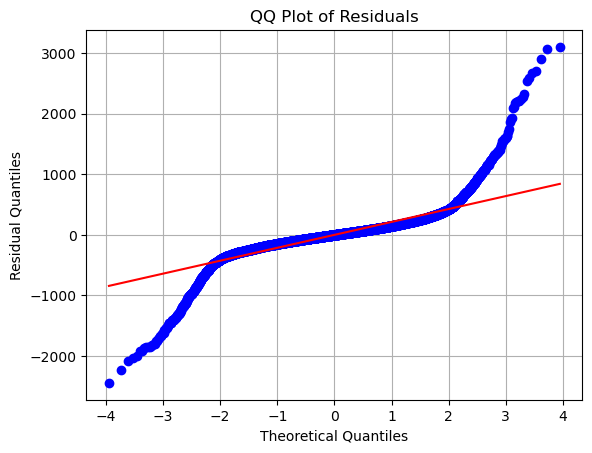

In [432]:
qq_plot_residuals(actual, predicted)

### ACF PACF on the resduals

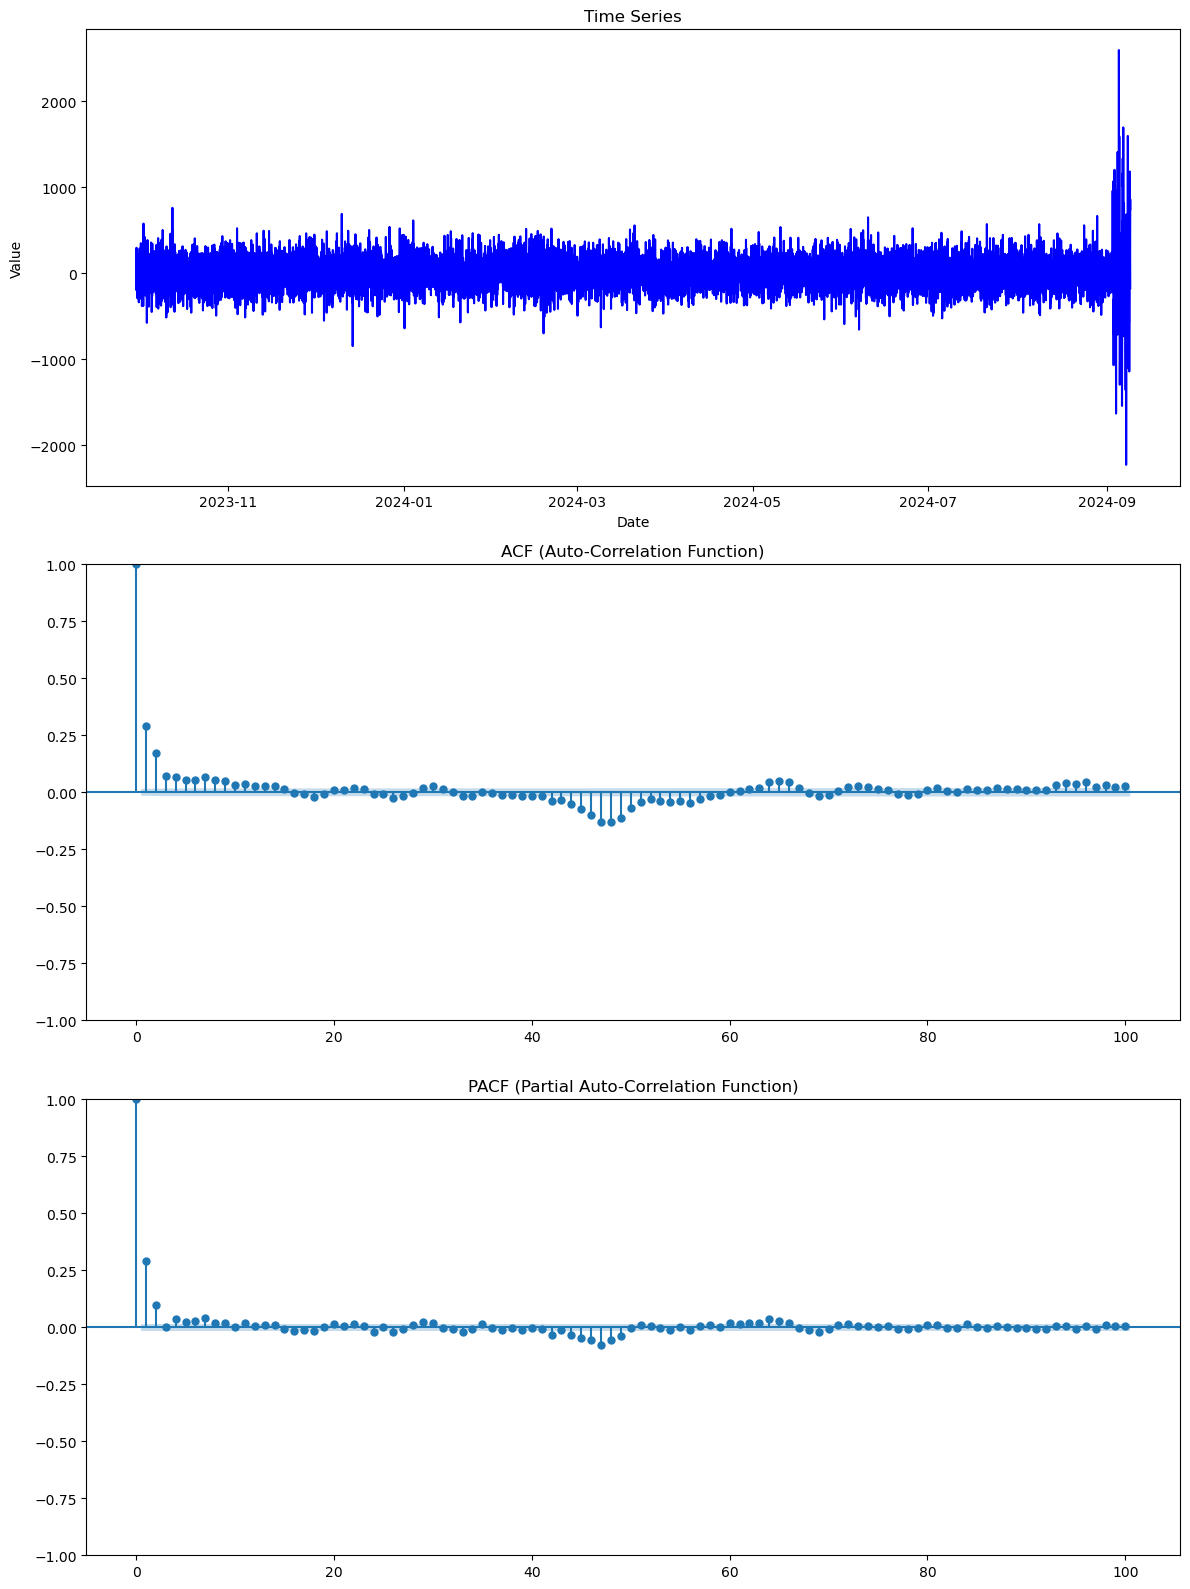

In [444]:
residuals = actual - predicted
ACF_PACF(residuals)

In [439]:
# Perform the Ljung-Box test
print(acorr_ljungbox(residuals, lags=[20*48], return_df=True))

len_preds = 48
arima_preds = statsforecast_arima(residuals, len_preds)
# Score the model
metrics(residuals, arima_preds[:-len_preds])

#

          lb_stat  lb_pvalue
960  43988.949749        0.0
Mean Absolute Error (MAE): 140.45934904317681
Mean Squared Error (MSE): 38586.29526413507
Root Mean Squared Error (RMSE): 196.43394631309292
R-squared (R2): 0.3342860846015677


196.43394631309292

The R-squared on the seen data is bad, as such, using ARIMA to predict residuals will not be useful for the future values
This means that our prediction of the mean ends here

### ACF PACF for the residuals squared

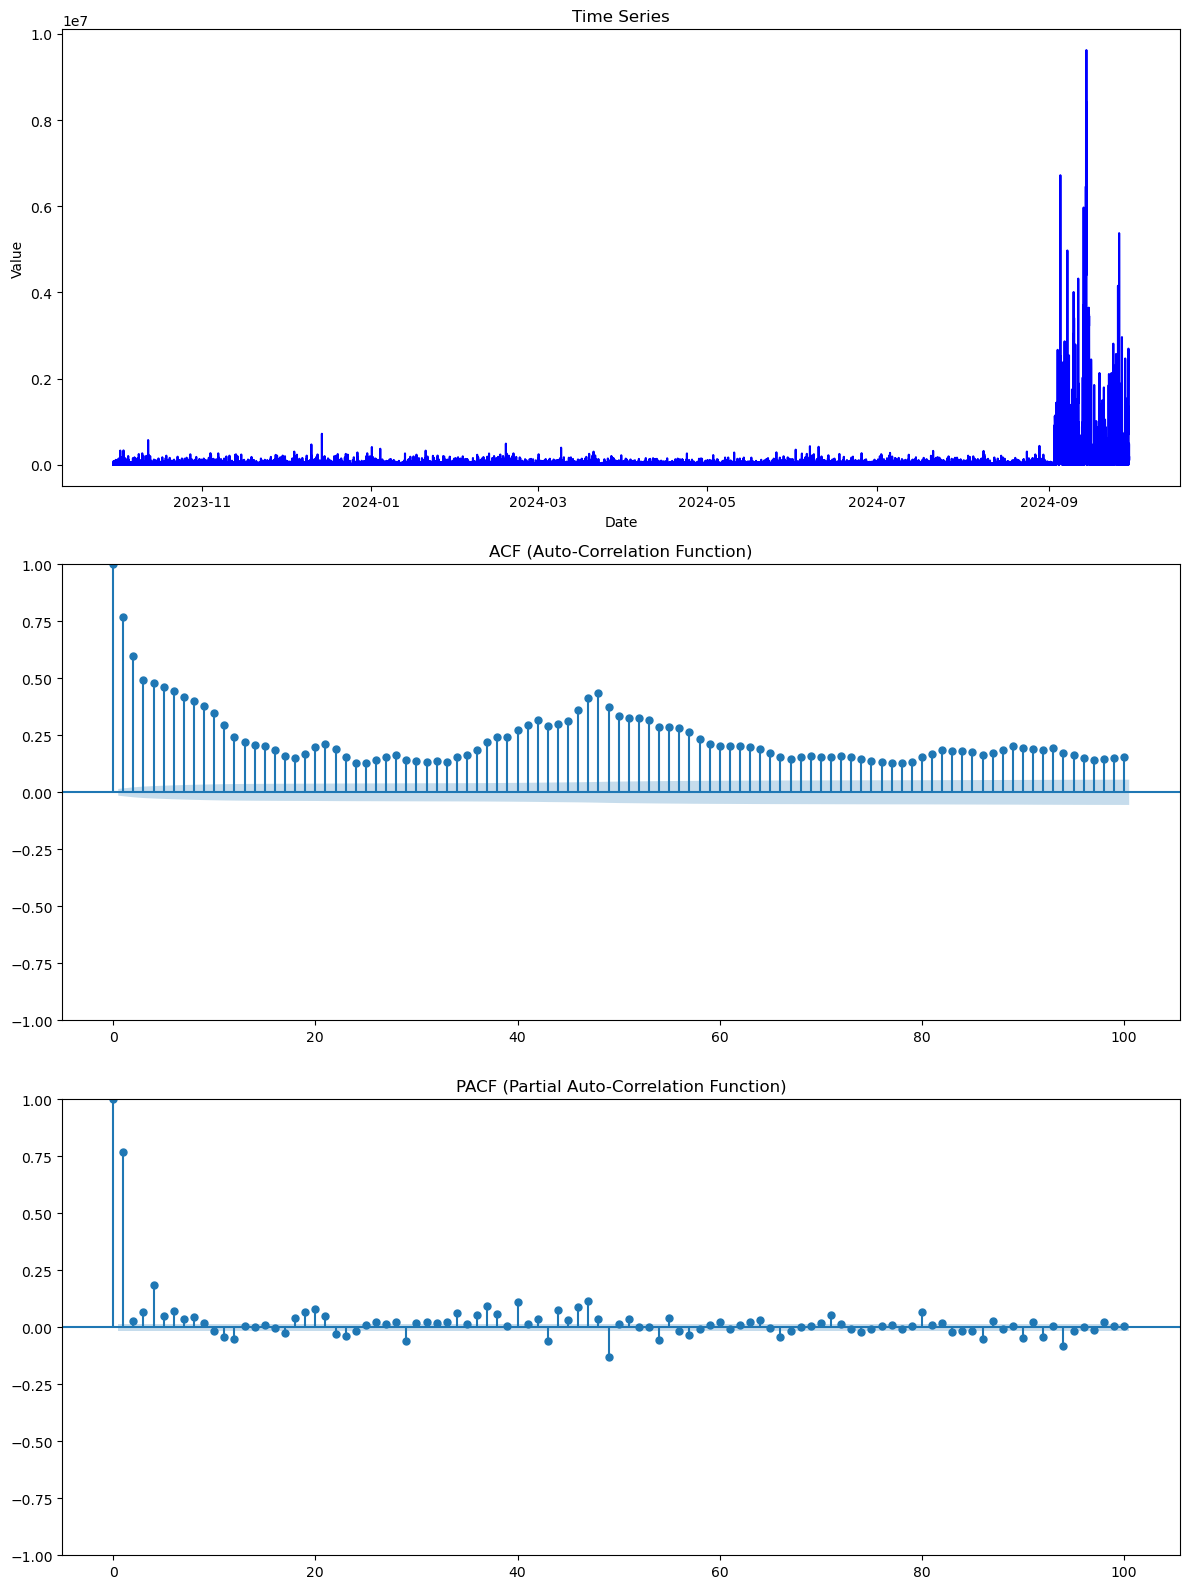

In [440]:
ACF_PACF(residuals**2)

# GARCH to model the ARMA in the squares of the residuals

In [448]:
def garch(residuals, alpha, horizon):
    test_stat, p_value, _, _ = het_arch(residuals.dropna())
    if p_value < 0.05:
        print("There are benefits of using an ARCH / GARCH model")
        garch_model = arch_model(residuals, vol='Garch', p=1, q=1)  # ,dist="StudentsT"
        garch_fit = garch_model.fit(disp="off")
        # print("\nBest Model:", garch_model.summary())
        # print(f"\nAIC: {garch_model.aic}")
        # Forecast GARCH variance (get predicted standard deviation for each time step)
        garch_forecast_var = garch_fit.forecast(horizon=horizon)
        garch_std_forward = np.sqrt(garch_forecast_var.variance.values[-1])  # This gives the volatility (std deviation) forecast

        # Get historical volatility (conditional standard deviation) on the fitted data
        garch_std_historical = garch_fit.conditional_volatility

        # Get residuals
        residuals = garch_fit.resid

        # Standardized residuals
        standardized_residuals = residuals / garch_fit.conditional_volatility
        
        # Define a scaling factor for the GARCH adjustment, if needed
        alpha = alpha

        # GARCH forecasts for error
        garch_forecast_error = alpha * standardized_residuals

        return garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals
    else:
        print("There are no benefits of using an ARCH / GARCH model")
        return None, residuals

There are benefits of using an ARCH / GARCH model


c:\Users\ruben\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.947e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




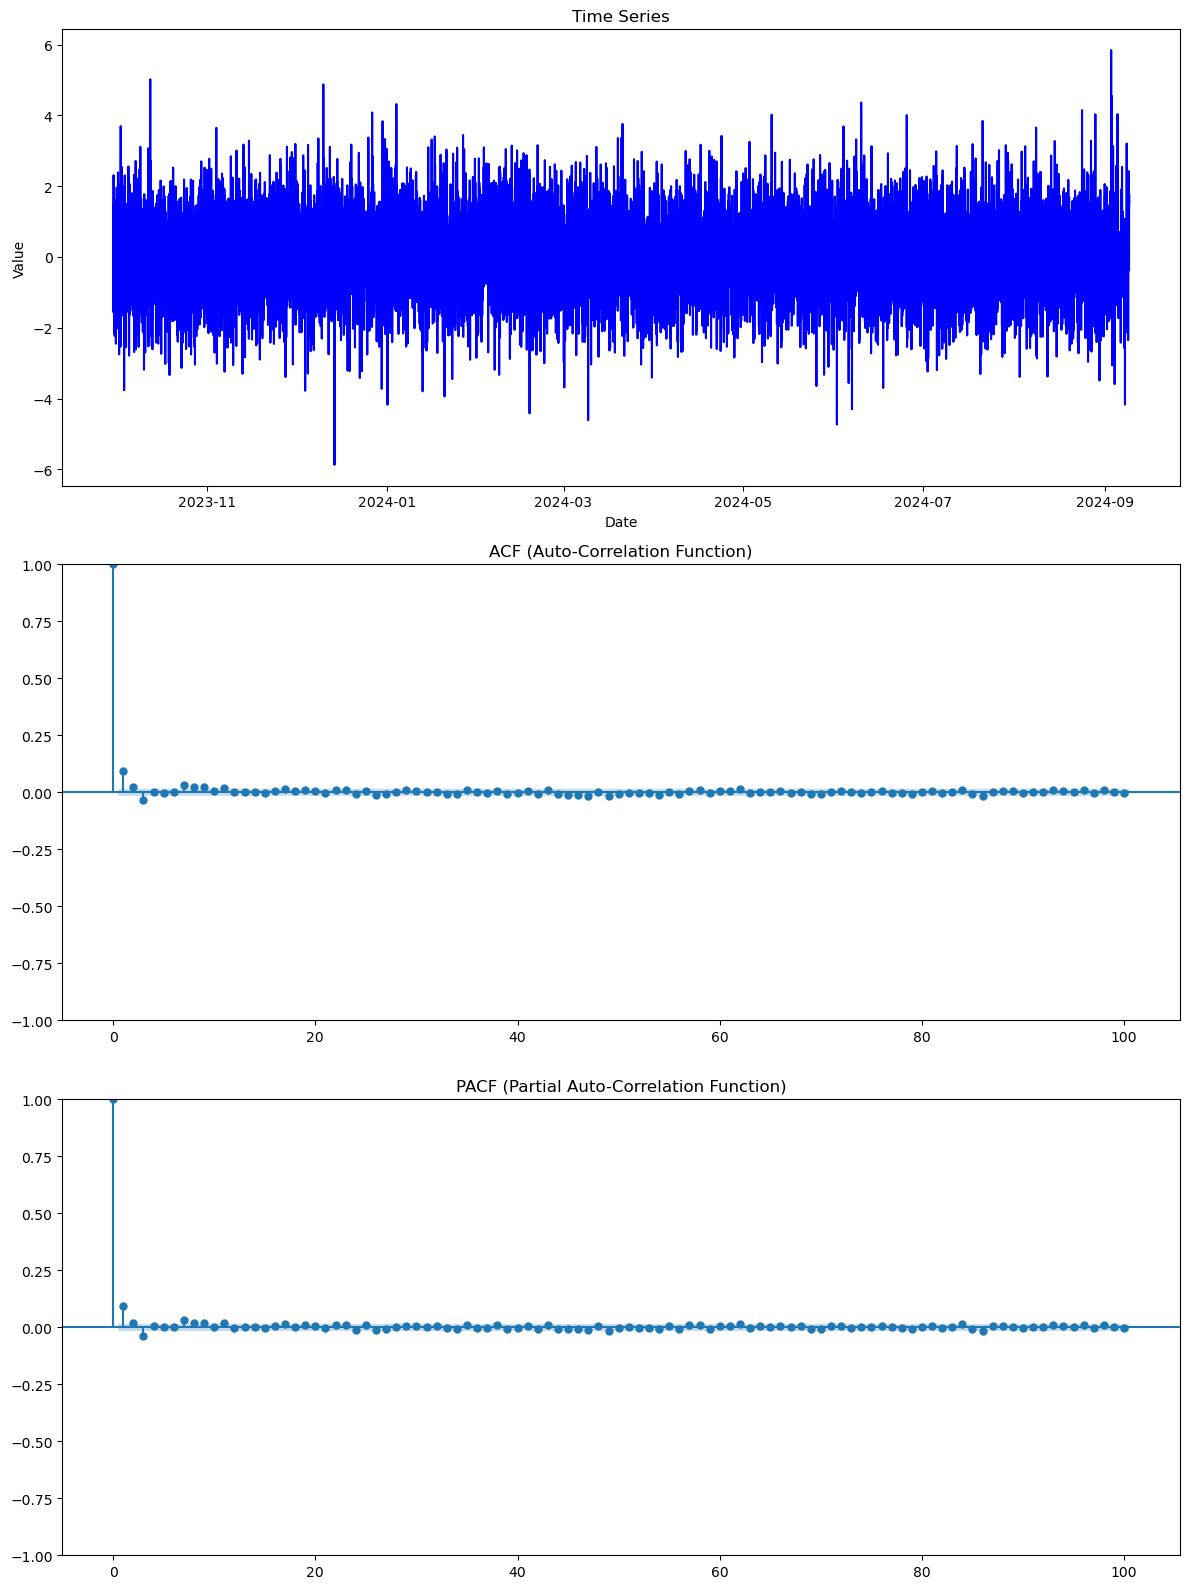

In [449]:
garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals = garch(residuals, 1, len_preds)

ACF_PACF(standardized_residuals)

In [452]:
upper_bound = XGB_y_pred[1:] + 1.96 * garch_std_forward
lower_bound = XGB_y_pred[1:] - 1.96 * garch_std_forward

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(XGB_y_pred.index, XGB_y_pred, label="Predictions", color="blue")
plt.fill_between(XGB_y_pred.index, lower_bound, upper_bound, color="lightblue", alpha=0.5, label="95% Confidence Interval")
plt.title("Predictions with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 2000x1000 with 0 Axes>

In [454]:
upper_bound = pd.Series(upper_bound)
lower_bound = pd.Series(lower_bound)
upper_bound.to_csv("upper_bound_NIV.csv")
lower_bound.to_csv("lower_bound_NIV.csv")

# Next, we perform predictions for System Price

In [337]:
target = "System_Price"

# Linear Model


Linear Regression Coefficients:
                            Feature  Coefficient
8                        BSAD_Total   526.882521
4                  Fossil_Hard_Coal     0.007713
12             Hydro_Pumped_Storage     0.003750
2                           Biomass     0.003492
3                        Fossil_Gas     0.001435
0                        Total_Load     0.000538
10                    Wind_Offshore     0.000172
1                    Demand_Outturn    -0.000335
7              EPEX_Intraday_Volume    -0.000946
14                          Nuclear    -0.001436
15                            Solar    -0.001702
9                      Wind_Onshore    -0.002648
13  Hydro_Run-of-River_and_Poundage    -0.008538
11                      NIV_Outturn    -0.044381
6                    BSAD_Turn_Down  -526.879085
5                      BSAD_Turn_Up  -526.885742
Mean Absolute Error (MAE): 21.729566316507672
Mean Squared Error (MSE): 615.1829388152066
Root Mean Squared Error (RMSE): 24.802881663

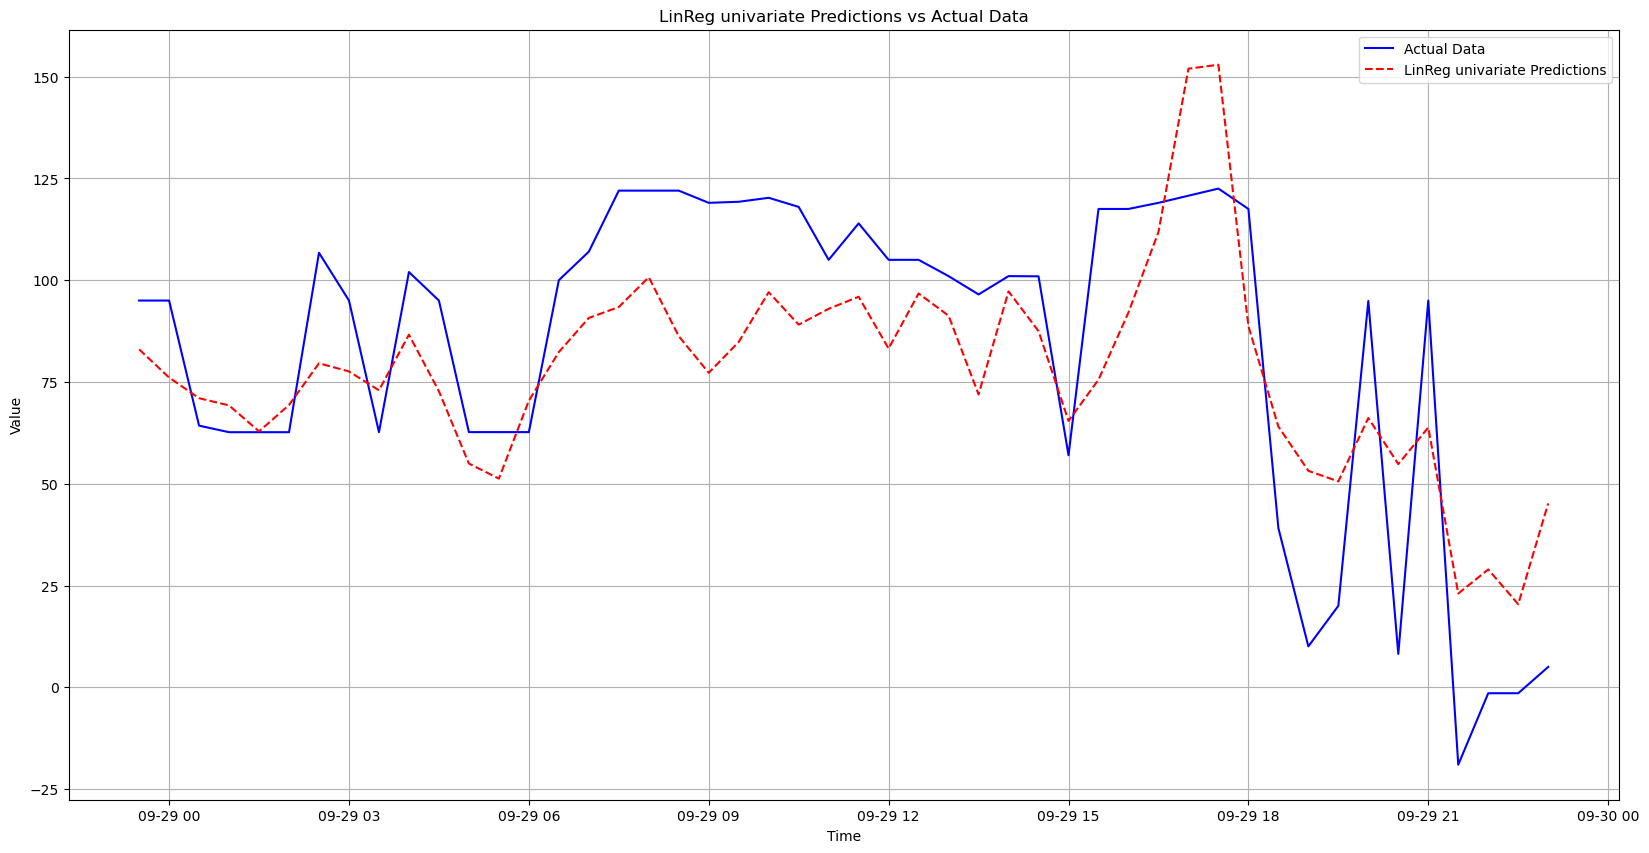

In [338]:
LinReg_predictions = Linear_Regresson(merged_df_2024, 48, target, not_predicted_columns)

In [339]:
LinReg_predictions

array([ 83.0206253 ,  76.08657214,  71.01388023,  69.24539551,
        62.85745529,  69.33517391,  79.58471365,  77.58587803,
        72.95205061,  86.61854632,  72.71647843,  54.95381946,
        51.26151104,  70.41093434,  82.34576259,  90.725695  ,
        93.41200544, 100.7232959 ,  86.23676325,  77.25015075,
        84.84282804,  97.05494446,  89.07797527,  92.97898379,
        95.92438906,  83.2097692 ,  96.73228375,  91.2820472 ,
        71.93586394,  97.24233979,  87.48589829,  65.43918872,
        75.55084796,  92.08906124, 111.83040051, 151.94814157,
       152.92630032,  88.69787914,  64.05028968,  53.17475471,
        50.57301059,  66.15054802,  54.82738157,  63.82175816,
        23.02833188,  28.95276569,  20.40312347,  45.18064024])

calculator score for the model is 35.28931701, still a ways to go

# XGBoost 

### We first prepare the data, so that it is in the right format

In [ ]:
pred_length = 48
to_drop_SP = not_predicted_columns + ["Loss_of_Load_Prob", "Loss_of_Load_Prob_diff", "Fossil_Oil", "Fossil_Oil_diff", "NIV_Outturn", "NIV_Outturn_lag_2", "System_Price_lag_1", "System_Price_lag_2", "BSAD_Turn_Down", "BSAD_Turn_Up", "EPEX_Intraday_Volume", "Fossil_Gas", "Biomass", "Fossil_Hard_Coal"] + [col for col in df_with_preds.columns if not col.endswith("diff")]
X_train, X_test, X_val, y_val, y_train, y_test, dtrain, dval, dtest, column_names = XGBoost_preparing_data(df_with_preds, pred_length, to_drop_SP, target)

### Run the XGBoost

In [385]:
XGB_final_model = XGBoost_optimization(dtrain, dval, y_val, column_names)
XGB_y_pred, XGB_y_preds_in_sample, XGB_residuals = XGBoost_optimized_predict(XGB_final_model, dtrain, dtest, dval, y_train, y_val)

[I 2024-12-05 13:33:02,657] A new study created in memory with name: no-name-0d81087d-2269-439c-a374-04caa73d1294
[W 2024-12-05 13:33:02,666] Trial 0 failed with parameters: {'learning_rate': 0.007820838808037824, 'subsample': 0.4773565685031349, 'max_depth': 10, 'min_child_weight': 5.83884051432338, 'colsample_bytree': 0.3965717226950084, 'gamma': 3.335220400606844} because of the following error: XGBoostError('[13:33:02] C:\\buildkite-agent\\builds\\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\\xgboost\\xgboost-ci-windows\\src\\learner.cc:764: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?').
Traceback (most recent call last):
  File "c:\Users\ruben\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_23152\3589718328.py", line 52, in objective
    model = xg

XGBoostError: [13:33:02] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:764: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

In [ ]:
XGB_y_pred

array([77.07537 , 94.006195, 96.21596 , 88.03293 , 88.618034, 96.8567  ,
       97.50625 , 83.34998 , 78.941635, 88.36346 , 90.63805 , 84.43463 ,
       74.993965, 83.027504, 83.39432 , 81.62793 , 76.91852 , 68.756294,
       64.44173 , 68.039986, 71.835075, 67.498985, 62.862217, 74.45646 ,
       84.0694  , 87.08793 , 88.95741 , 89.92125 , 85.279175, 97.29741 ,
       81.788635, 86.11867 , 88.34142 , 93.1431  , 92.93063 , 94.21709 ,
       85.27517 , 90.73156 , 87.19542 , 85.14815 , 80.61389 , 78.27307 ,
       82.61432 , 75.617455, 78.84459 , 83.79543 , 85.64587 , 80.29458 ,
       73.97509 ], dtype=float32)

the calculator result is 38.14317168

### We try to make sequential predictions for XGBoost, updating each row with each prediction

Mean Absolute Error (MAE): 1.9022824
Mean Squared Error (MSE): 7.2856336
Root Mean Squared Error (RMSE): 2.6991913
R-squared (R2): 0.9928156137466431


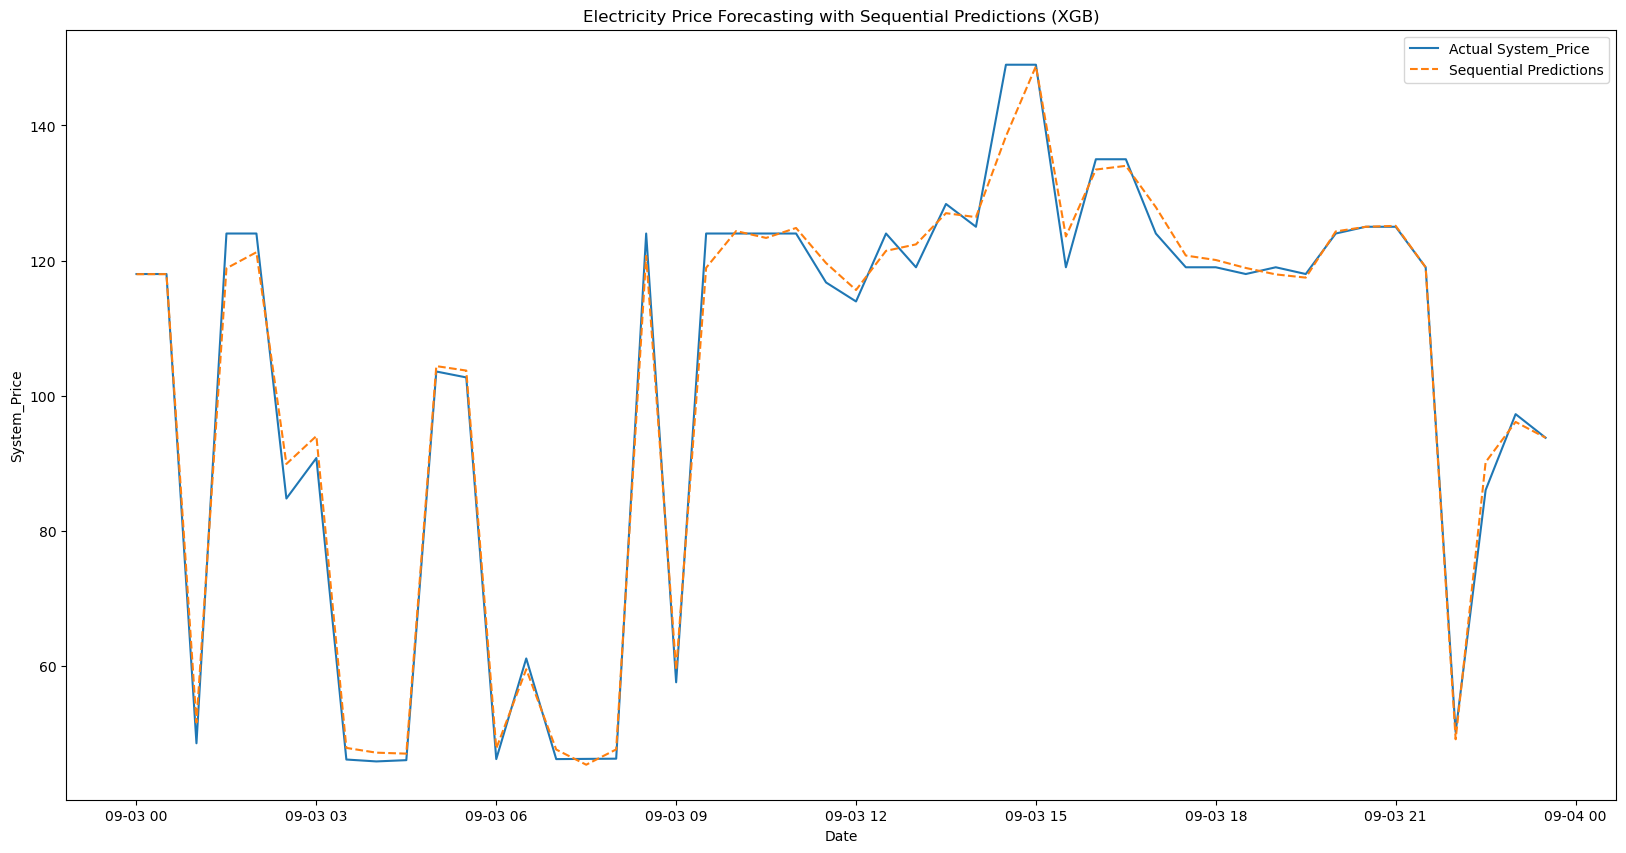

In [353]:
XGB_seq_in_sample_preds, XGB_sequential_preds, XGB_seq_residuals = XGBoost_optimized_sequential_predictions(XGB_final_model, dtrain, dval, X_test, X_val, y_test, y_train, y_val, 49, target)

In [354]:
XGB_sequential_preds

Datetime
2024-10-01 00:00:00    21.022482
2024-10-01 00:30:00    16.562290
2024-10-01 01:00:00    14.332684
2024-10-01 01:30:00    14.491687
2024-10-01 02:00:00    13.132725
2024-10-01 02:30:00    12.518863
2024-10-01 03:00:00    11.241859
2024-10-01 03:30:00    12.887136
2024-10-01 04:00:00    13.400975
2024-10-01 04:30:00    17.101126
2024-10-01 05:00:00    20.102791
2024-10-01 05:30:00    22.808231
2024-10-01 06:00:00    22.569731
2024-10-01 06:30:00    17.547985
2024-10-01 07:00:00    11.547184
2024-10-01 07:30:00     9.061297
2024-10-01 08:00:00     6.028640
2024-10-01 08:30:00     7.133217
2024-10-01 09:00:00    11.250724
2024-10-01 09:30:00    14.880549
2024-10-01 10:00:00    16.637899
2024-10-01 10:30:00    18.645563
2024-10-01 11:00:00    20.331558
2024-10-01 11:30:00    22.516657
2024-10-01 12:00:00    20.766846
2024-10-01 12:30:00    20.954742
2024-10-01 13:00:00    22.719296
2024-10-01 13:30:00    23.038078
2024-10-01 14:00:00    23.460409
2024-10-01 14:30:00    25.006594
2

The calculator gives a really bad score

# LGBM

In [ ]:
LGBM_final_model = LGBM_optimization(X_train, X_test, y_train, y_test)
LGBM_in_sample_preds, LGBM_final_predictions, LGBM_residuals = LGBM_optimized_predictions(LGBM_final_model, X_train, X_val, X_test, y_val, y_train)

[I 2024-12-05 13:00:55,531] A new study created in memory with name: no-name-188c7f4d-05db-41c6-88b3-abd6a280f62e
[I 2024-12-05 13:01:09,703] Trial 0 finished with value: 67.36186483098017 and parameters: {'learning_rate': 0.0016603873393424356, 'num_leaves': 146, 'max_depth': 5, 'colsample_bytree': 0.4763278605341278, 'subsample': 0.5820815555548393, 'max_bin': 174}. Best is trial 0 with value: 67.36186483098017.
[I 2024-12-05 13:01:13,418] Trial 1 finished with value: 69.26103071180934 and parameters: {'learning_rate': 0.001287129078842184, 'num_leaves': 219, 'max_depth': 2, 'colsample_bytree': 0.3072093854288892, 'subsample': 0.5286753594422069, 'max_bin': 143}. Best is trial 0 with value: 67.36186483098017.
[I 2024-12-05 13:02:37,643] Trial 2 finished with value: 77.1525181190675 and parameters: {'learning_rate': 0.0030465776348520537, 'num_leaves': 194, 'max_depth': 15, 'colsample_bytree': 0.3078668044372902, 'subsample': 0.6756844912857805, 'max_bin': 221}. Best is trial 0 with v

Best hyperparameters: {'learning_rate': 0.0016603873393424356, 'num_leaves': 146, 'max_depth': 5, 'colsample_bytree': 0.4763278605341278, 'subsample': 0.5820815555548393, 'max_bin': 174}
Best RMSE: 67.36186483098017


TypeError: LGBM_optimized_predictions() missing 1 required positional argument: 'y_train'

Final RMSE: 25.143573576954825


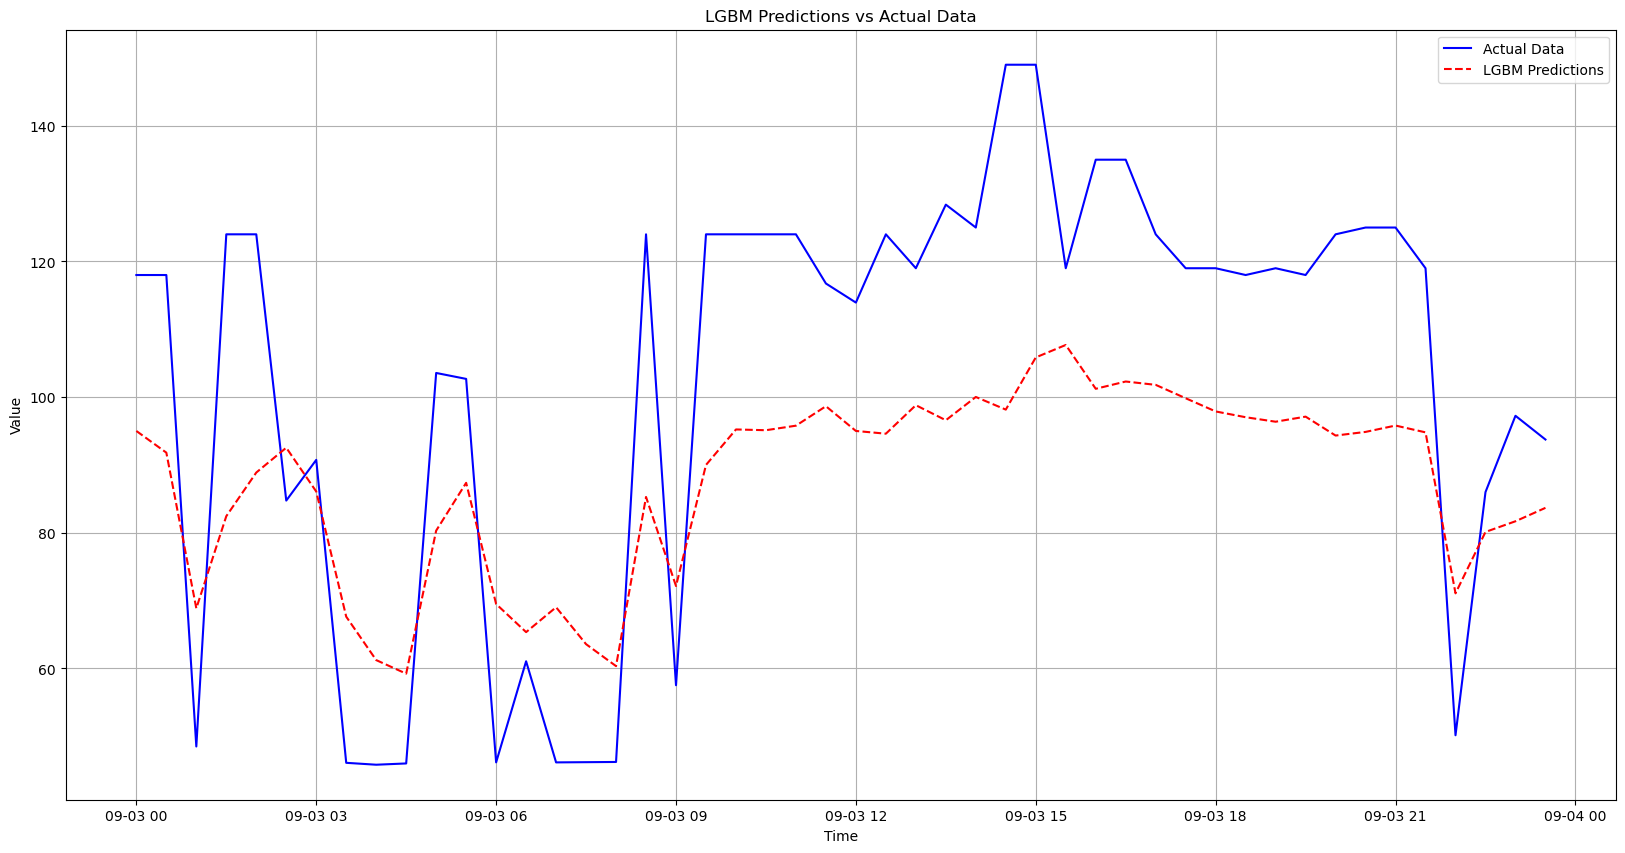

In [356]:
LGBM_in_sample_preds, LGBM_final_predictions, LGBM_residuals = LGBM_optimized_predictions(LGBM_final_model, X_train, X_val, X_test, y_val, y_train)

In [357]:
LGBM_final_predictions

array([68.03839255, 71.50552734, 72.9487524 , 73.00439661, 73.06643632,
       72.95516837, 73.00706447, 72.9996508 , 73.48234095, 73.69034948,
       74.0101644 , 74.49527729, 75.08542222, 75.20114794, 75.11224904,
       75.08741784, 75.08741784, 75.17281876, 75.17281876, 74.86374104,
       74.52742548, 74.49648493, 74.50471488, 74.34719794, 74.3427705 ,
       74.30086789, 74.46578464, 74.73188243, 75.02071499, 75.83661469,
       75.91350301, 75.96272778, 75.97922014, 75.88940992, 75.82968483,
       75.61008355, 75.41046371, 75.37550902, 75.18653679, 74.92039221,
       74.73513807, 74.42300825, 74.10024213, 73.86017916, 73.76204271,
       73.68309401, 73.32535217, 73.18945474, 72.59245655])

With this model, we get a score of 31.747781

# LSTM

In [ ]:
time_step = 96
pred_length = 48 + 1  # Due to the way the function is set up
target_scaler, X_train, X_test, exog_X_train, exog_X_test, y_train, y_test, index = LSTM_prepare_data(df_with_preds, time_step, pred_length, [], target)  # [f"{target}_lag_1", f"{target}_lag_2", f"{target}_diff"]
LSTM_final_train_preds, LSTM_final_test_preds, LSTM_train_residuals = LSTM_predictions(time_step, X_train, X_test, y_train, y_test, target_scaler, index, target)



# Metamodel

#### We dont end up using this

In [ ]:
X_meta_train, X_meta_test, y_meta_train, y_meta_test = Prepare_data_Metamodel(LSTM_final_train_preds, LGBM_in_sample_preds, XGB_seq_in_sample_preds, Day_Ahead_Price_lag_48, LSTM_final_test_preds, LGBM_final_predictions, XGB_sequential_preds, target)
meta_predictions, residuals = Metamodel_predictions(X_meta_train, y_meta_train, y_meta_test, X_meta_test, target)

# Residual Analysis

In [490]:
actual = df_with_preds["System_Price"].dropna()
predicted_full = pd.read_csv("System_Price_Preds_full.csv")
predicted_full = predicted_full["Day_Ahead_Price_lag_48"]

In [491]:
predicted = predicted_full[:-48]
predicted = predicted[48:]
actual = actual[48:-48]
actual = pd.Series(actual)
predicted.index = actual.index
predicted = pd.Series(predicted)

In [474]:
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

# 3. Residual Analysis
def residual_analysis(actual, predicted):
    residuals = actual - predicted

    # Residual Histogram
    fig_hist = px.histogram(residuals, nbins=30, title='Histogram of Residuals', labels={'value': 'Residuals'})
    fig_hist.show()

    # Residuals vs. Actual
    fig_scatter = px.scatter(x=actual, y=residuals, title='Residuals vs Actual',
                             labels={'x': 'Actual', 'y': 'Residuals'})
    fig_scatter.add_hline(y=0, line_dash="dash", line_color="red")
    fig_scatter.show()
residual_analysis(actual, predicted)

ValueError: All arguments should have the same length. The length of argument `y` is 35040, whereas the length of  previously-processed arguments ['x'] is 17520

## **Scatter Plot of Predicted vs Actual**

In [ ]:
def scatter_predicted_vs_actual(actual, predicted):
    fig = px.scatter(x=actual, y=predicted, title='Predicted vs Actual',
                     labels={'x': 'Actual', 'y': 'Predicted'})
    fig.add_shape(type='line', x0=min(actual), x1=max(actual), y0=min(actual), y1=max(actual),
                  line=dict(color='red', dash='dash'))
    fig.show()
scatter_predicted_vs_actual(actual, predicted)

## **Cumulative Error Plot**

In [ ]:
def cumulative_error_plot(actual, predicted):
    residuals = actual - predicted
    cumulative_error = np.cumsum(residuals)
    fig = px.line(x=range(len(cumulative_error)), y=cumulative_error,
                  title='Cumulative Error Plot', labels={'x': 'Index', 'y': 'Cumulative Error'})
    fig.show()
cumulative_error_plot(actual, predicted)

## **QQ Plot of Residuals**

In [ ]:
def qq_plot_residuals(actual, predicted):
    """
    Generates a QQ Plot for the residuals of actual vs. predicted values.
    
    Parameters:
    - actual: pd.Series or np.array of actual values
    - predicted: pd.Series or np.array of predicted values
    
    Returns:
    - Displays the QQ plot.
    """
    residuals = actual - predicted
    
    # Create the QQ Plot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Residual Quantiles")
    plt.grid(True)
    plt.show()

In [ ]:
qq_plot_residuals(actual, predicted)

### ACF PACF on the resduals

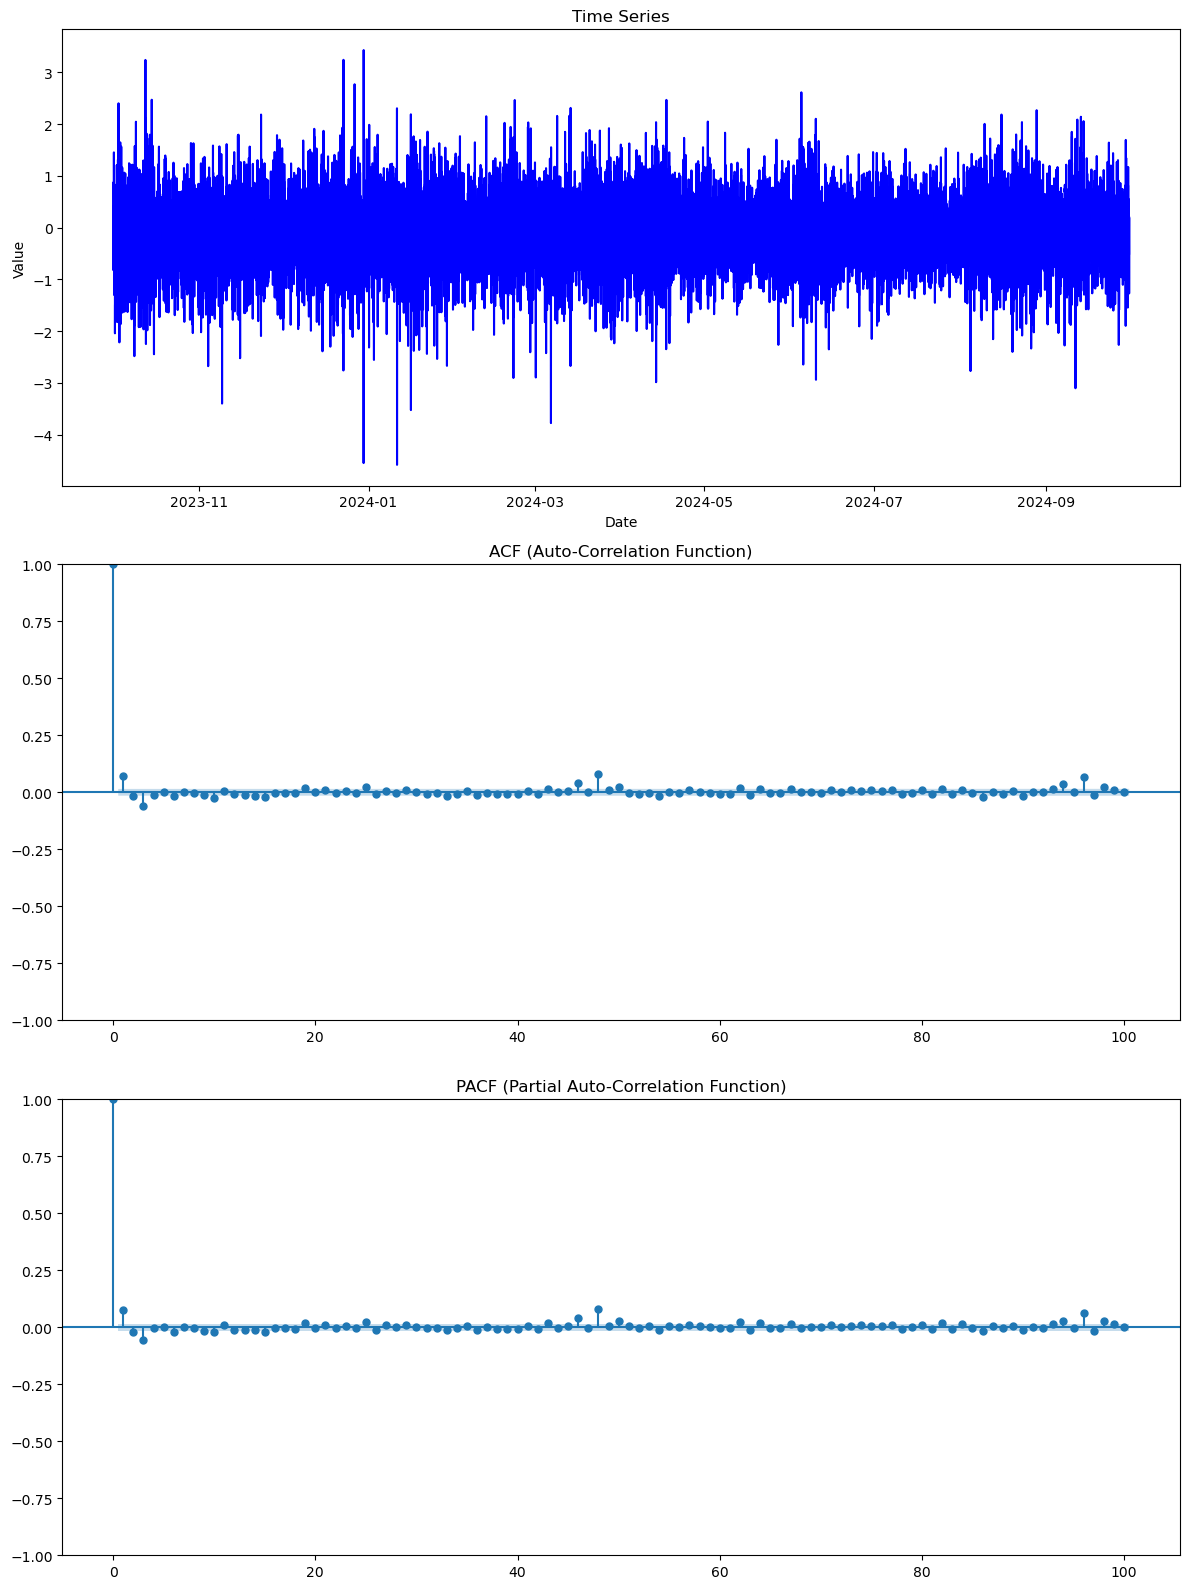

In [ ]:
residuals = predicted - actual
future_predictions = predicted_full[-48:]

ACF_PACF(residuals)

In [ ]:
# Perform the Ljung-Box test
print(acorr_ljungbox(residuals, lags=[20*48], return_df=True))

len_preds = 48
arima_preds = statsforecast_arima(residuals, len_preds)
# Score the model
metrics(residuals, arima_preds[:-len_preds])

#

Mean Absolute Error (MAE): 0.46873463408463095
Mean Squared Error (MSE): 0.38012931846250086
Root Mean Squared Error (RMSE): 0.6165462824983221
R-squared (R2): -0.0036768060034984007


0.6165462824983221

The R-squared on the seen data is bad, as such, using ARIMA to predict residuals will not be useful for the future values
This means that our prediction of the mean ends here

### ACF PACF for the residuals squared

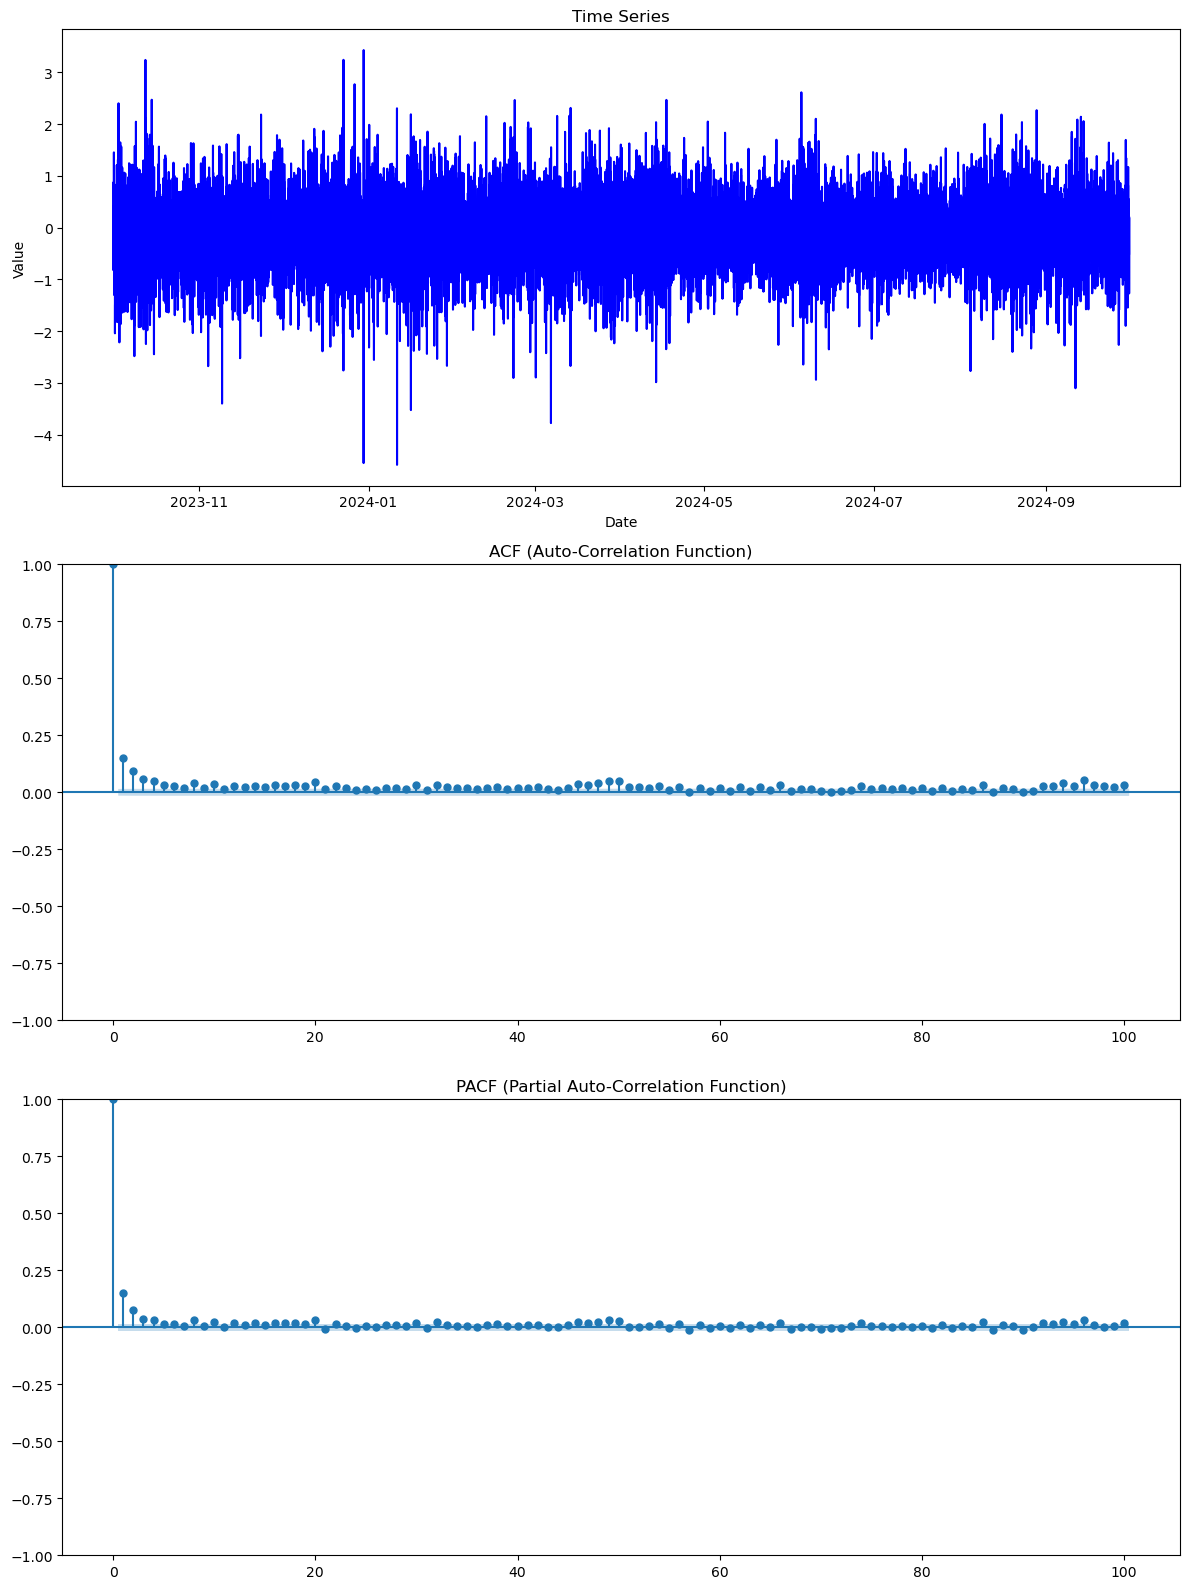

In [ ]:
ACF_PACF(residuals**2)

# GARCH to model the ARMA in the squares of the residuals

In [495]:
def garch(residuals, alpha, horizon):
    test_stat, p_value, _, _ = het_arch(residuals.dropna())
    if p_value < 0.05:
        print("There are benefits of using an ARCH / GARCH model")
        garch_model = arch_model(residuals, vol='Garch', p=1, q=1)  # ,dist="StudentsT"
        garch_fit = garch_model.fit(disp="off")
        # print("\nBest Model:", garch_model.summary())
        # print(f"\nAIC: {garch_model.aic}")
        # Forecast GARCH variance (get predicted standard deviation for each time step)
        garch_forecast_var = garch_fit.forecast(horizon=horizon)
        garch_std_forward = np.sqrt(garch_forecast_var.variance.values[-1])  # This gives the volatility (std deviation) forecast

        # Get historical volatility (conditional standard deviation) on the fitted data
        garch_std_historical = garch_fit.conditional_volatility

        # Get residuals
        residuals = garch_fit.resid

        # Standardized residuals
        standardized_residuals = residuals / garch_fit.conditional_volatility
        
        # Define a scaling factor for the GARCH adjustment, if needed
        alpha = alpha

        # GARCH forecasts for error
        garch_forecast_error = alpha * standardized_residuals

        return garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals
    else:
        print("There are no benefits of using an ARCH / GARCH model")
        return None, residuals

There are benefits of using an ARCH / GARCH model


c:\Users\ruben\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.947e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




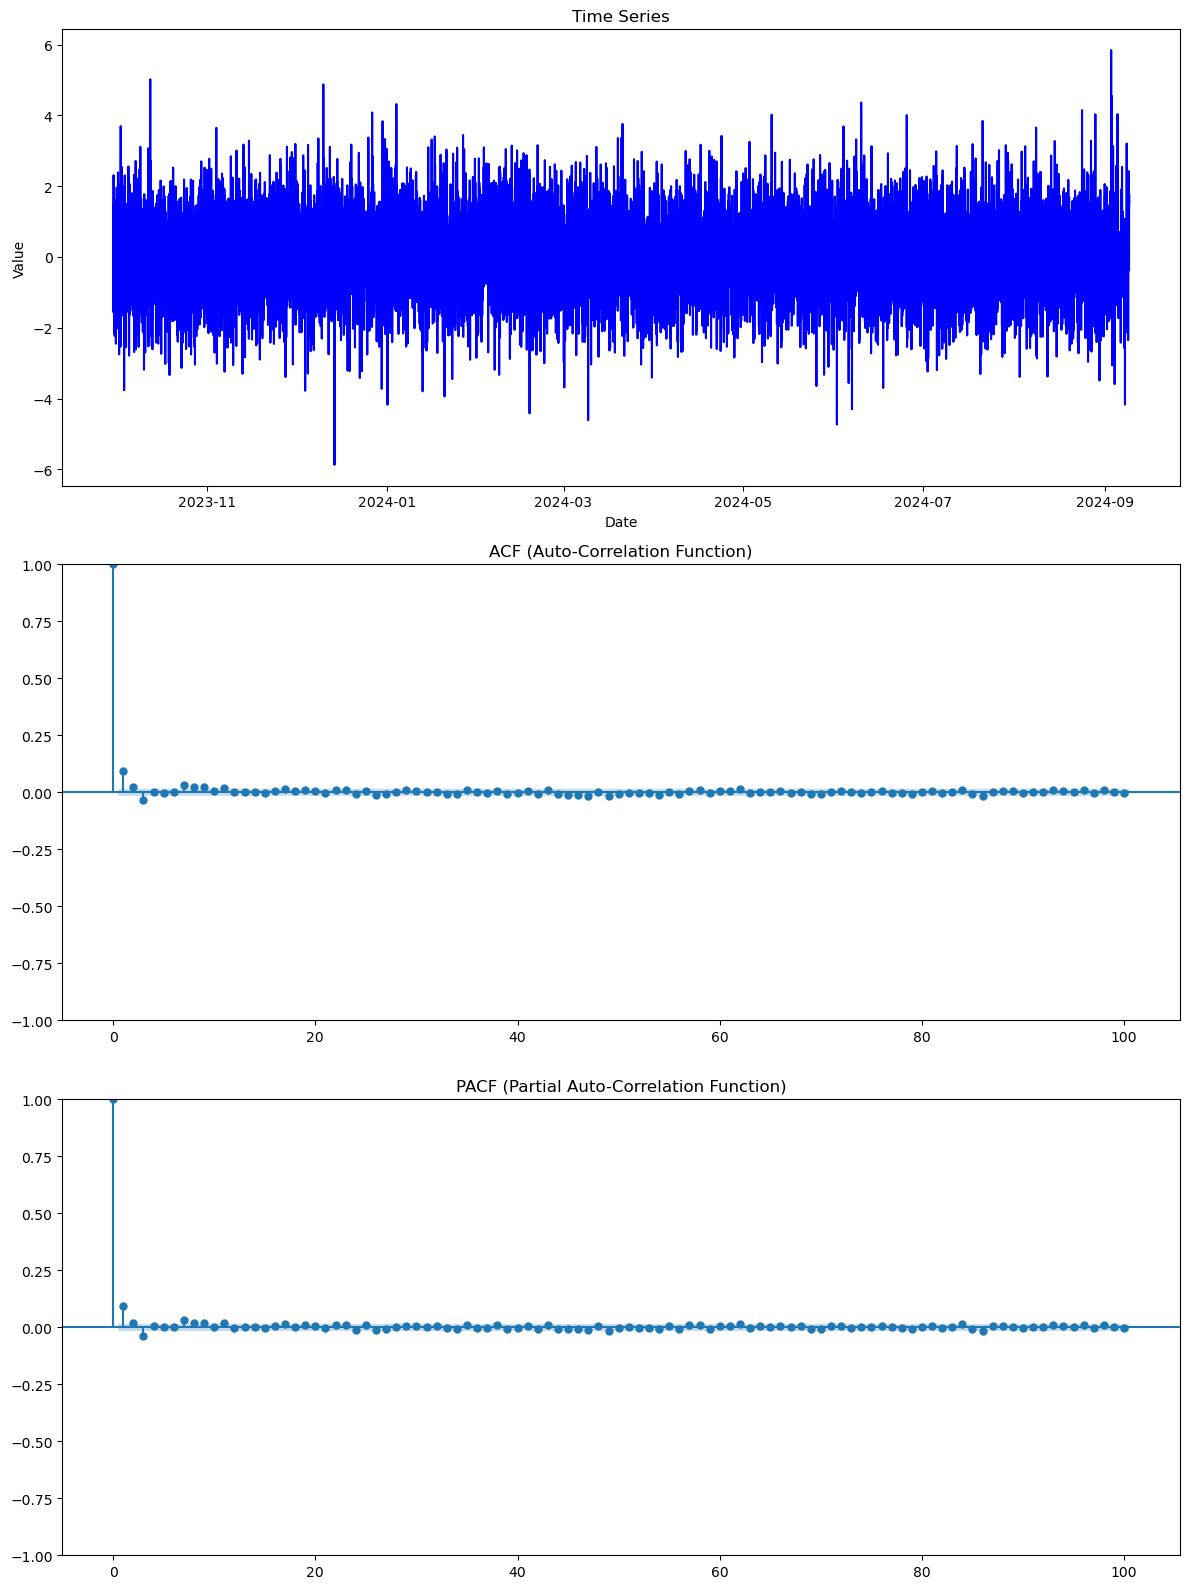

In [496]:
garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals = garch(residuals, 1, len_preds)

ACF_PACF(standardized_residuals)

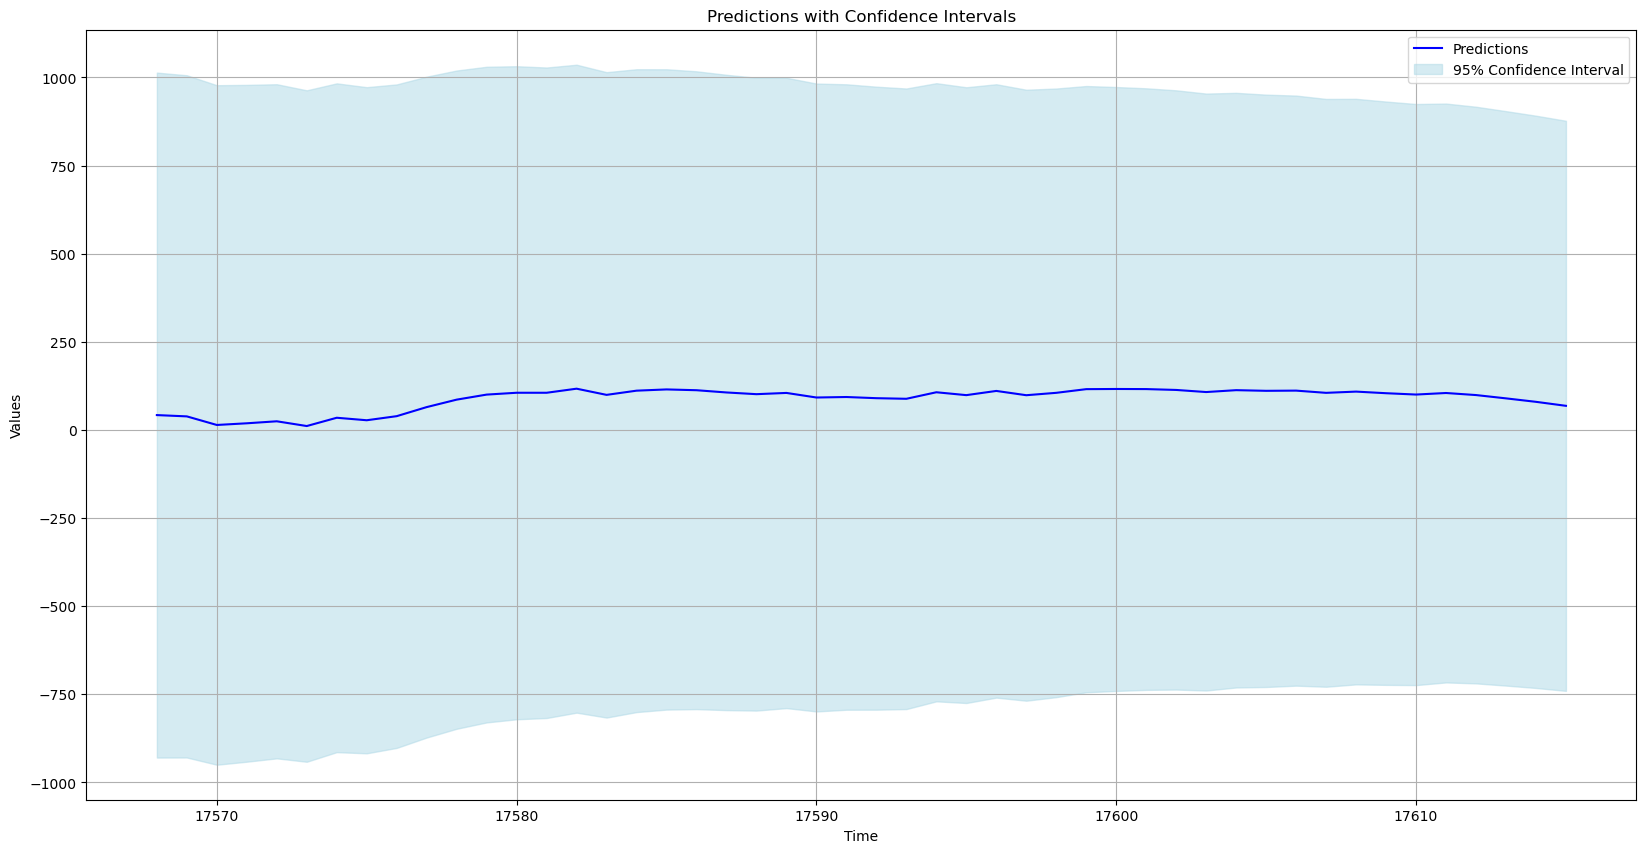

In [498]:
future_predictions = predicted_full[-48:]
upper_bound = future_predictions + 1.96 * garch_std_forward
lower_bound = future_predictions - 1.96 * garch_std_forward

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(future_predictions.index, future_predictions, label="Predictions", color="blue")
plt.fill_between(future_predictions.index, lower_bound, upper_bound, color="lightblue", alpha=0.5, label="95% Confidence Interval")
plt.title("Predictions with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

upper_bound = pd.Series(upper_bound)
lower_bound = pd.Series(lower_bound)
upper_bound.to_csv("upper_bound_SP.csv")
lower_bound.to_csv("lower_bound_SP.csv")

### ACF PACF on the resduals

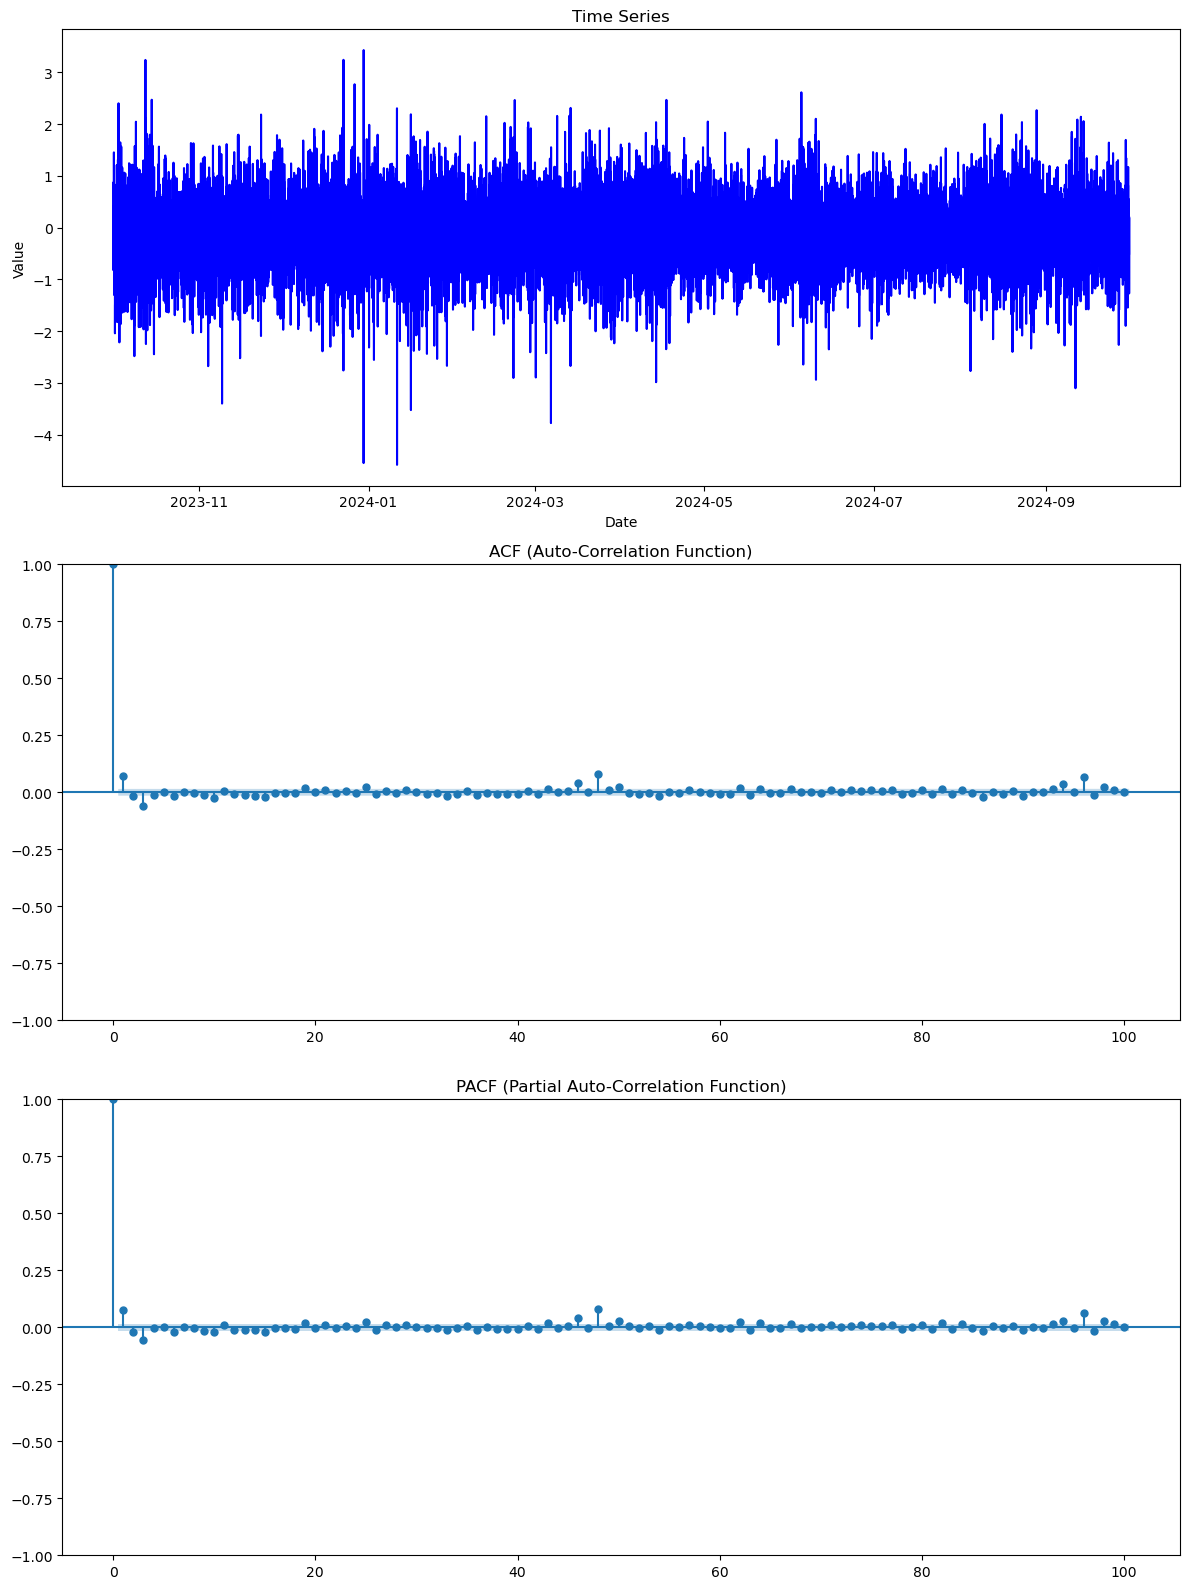

In [ ]:
residuals = actual - predicted

ACF_PACF(residuals)

In [ ]:
# Perform the Ljung-Box test
print(acorr_ljungbox(residuals, lags=[20*48], return_df=True))

len_preds = 48
arima_preds = statsforecast_arima(residuals, len_preds)
# Score the model
metrics(residuals, arima_preds[:-len_preds])

#

Mean Absolute Error (MAE): 0.46873463408463095
Mean Squared Error (MSE): 0.38012931846250086
Root Mean Squared Error (RMSE): 0.6165462824983221
R-squared (R2): -0.0036768060034984007


0.6165462824983221

The R-squared on the seen data is bad, as such, using ARIMA to predict residuals will not be useful for the future values
This means that our prediction of the mean ends here

### ACF PACF for the residuals squared

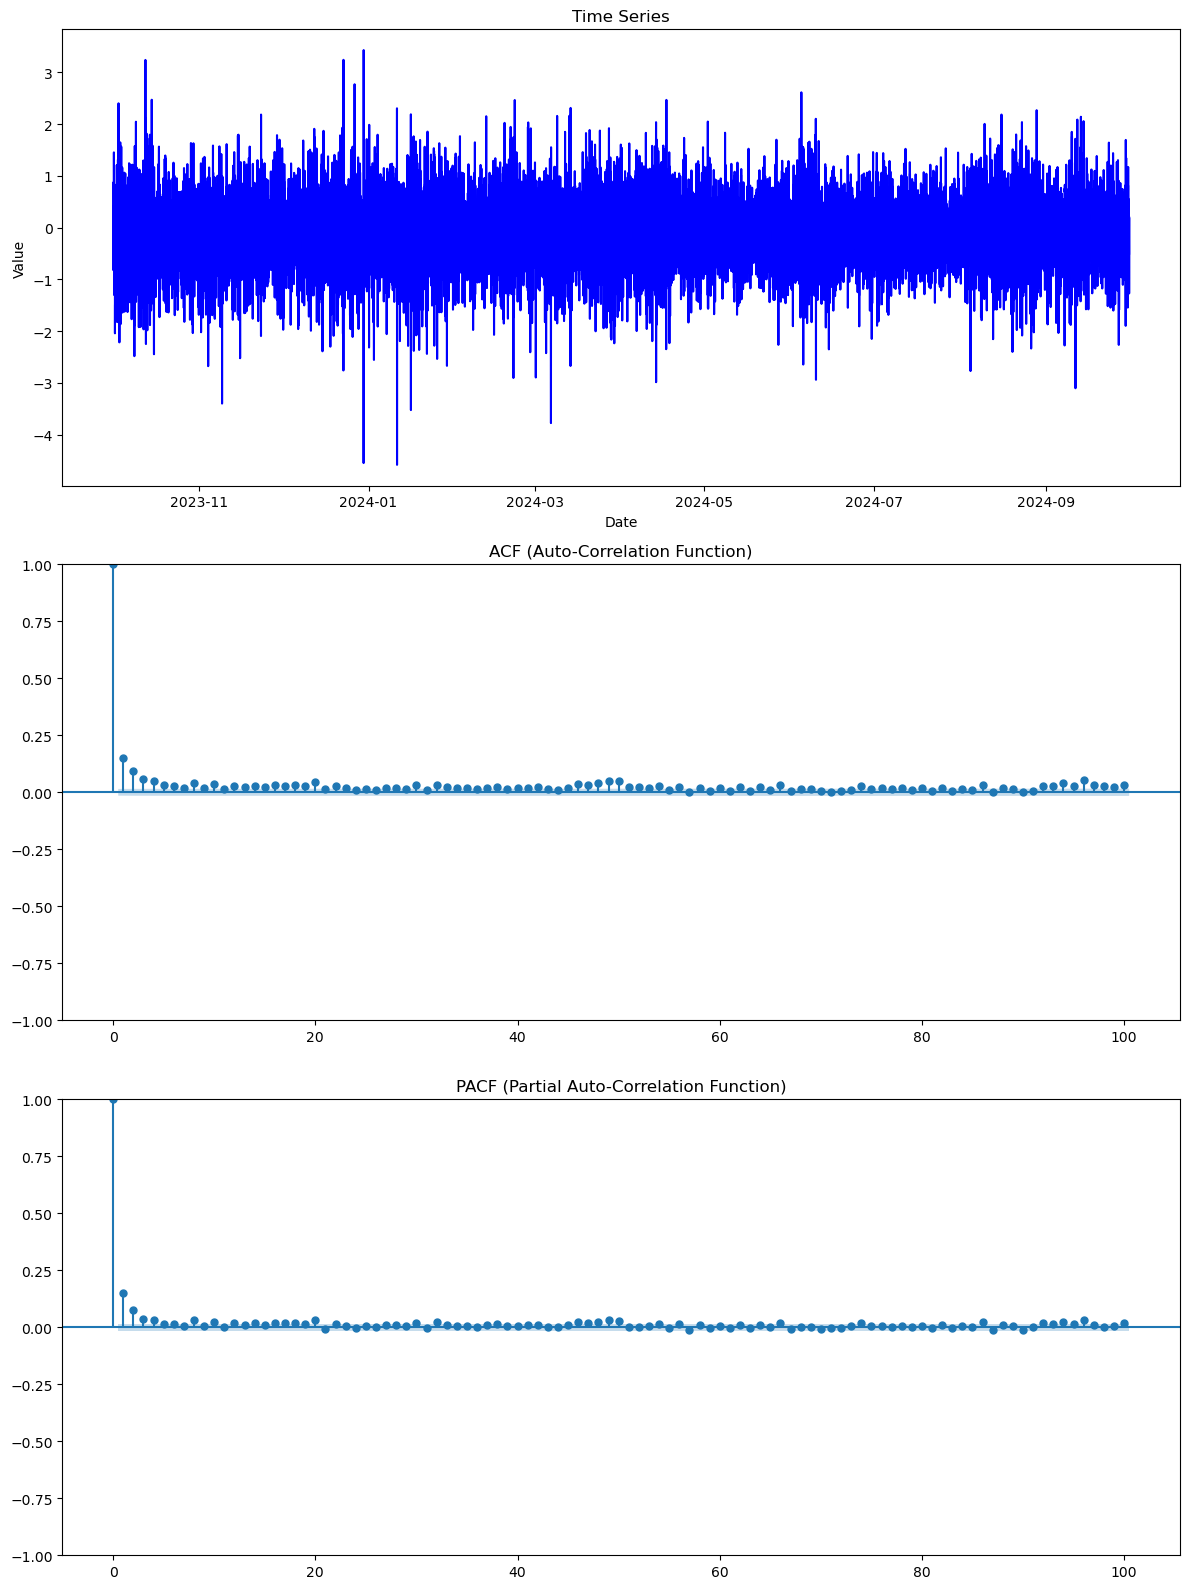

In [ ]:
ACF_PACF(residuals**2)

# GARCH to model the ARMA in the squares of the residuals

In [ ]:
def garch(residuals, alpha, horizon):
    test_stat, p_value, _, _ = het_arch(residuals.dropna())
    if p_value < 0.05:
        print("There are benefits of using an ARCH / GARCH model")
        garch_model = arch_model(residuals, vol='Garch', p=1, q=1)  # ,dist="StudentsT"
        garch_fit = garch_model.fit(disp="off")
        print("\nBest Model:", garch_model.summary())
        print(f"\nAIC: {garch_model.aic}")
        # Forecast GARCH variance (get predicted standard deviation for each time step)
        garch_forecast_var = garch_fit.forecast(horizon=horizon)
        garch_std_forward = np.sqrt(garch_forecast_var.variance.values[-1])  # This gives the volatility (std deviation) forecast

        # Get historical volatility (conditional standard deviation) on the fitted data
        garch_std_historical = garch_fit.conditional_volatility

        # Get residuals
        residuals = garch_fit.resid

        # Standardized residuals
        standardized_residuals = residuals / garch_fit.conditional_volatility
        
        # Define a scaling factor for the GARCH adjustment, if needed
        alpha = alpha

        # GARCH forecasts for error
        garch_forecast_error = alpha * standardized_residuals

        return garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals
    else:
        print("There are no benefits of using an ARCH / GARCH model")
        return None, residuals

In [ ]:
garch_std_forward, garch_std_historical, garch_forecast_error, standardized_residuals = garch(residuals, 1, len_preds)

ACF_PACF(standardized_residuals)

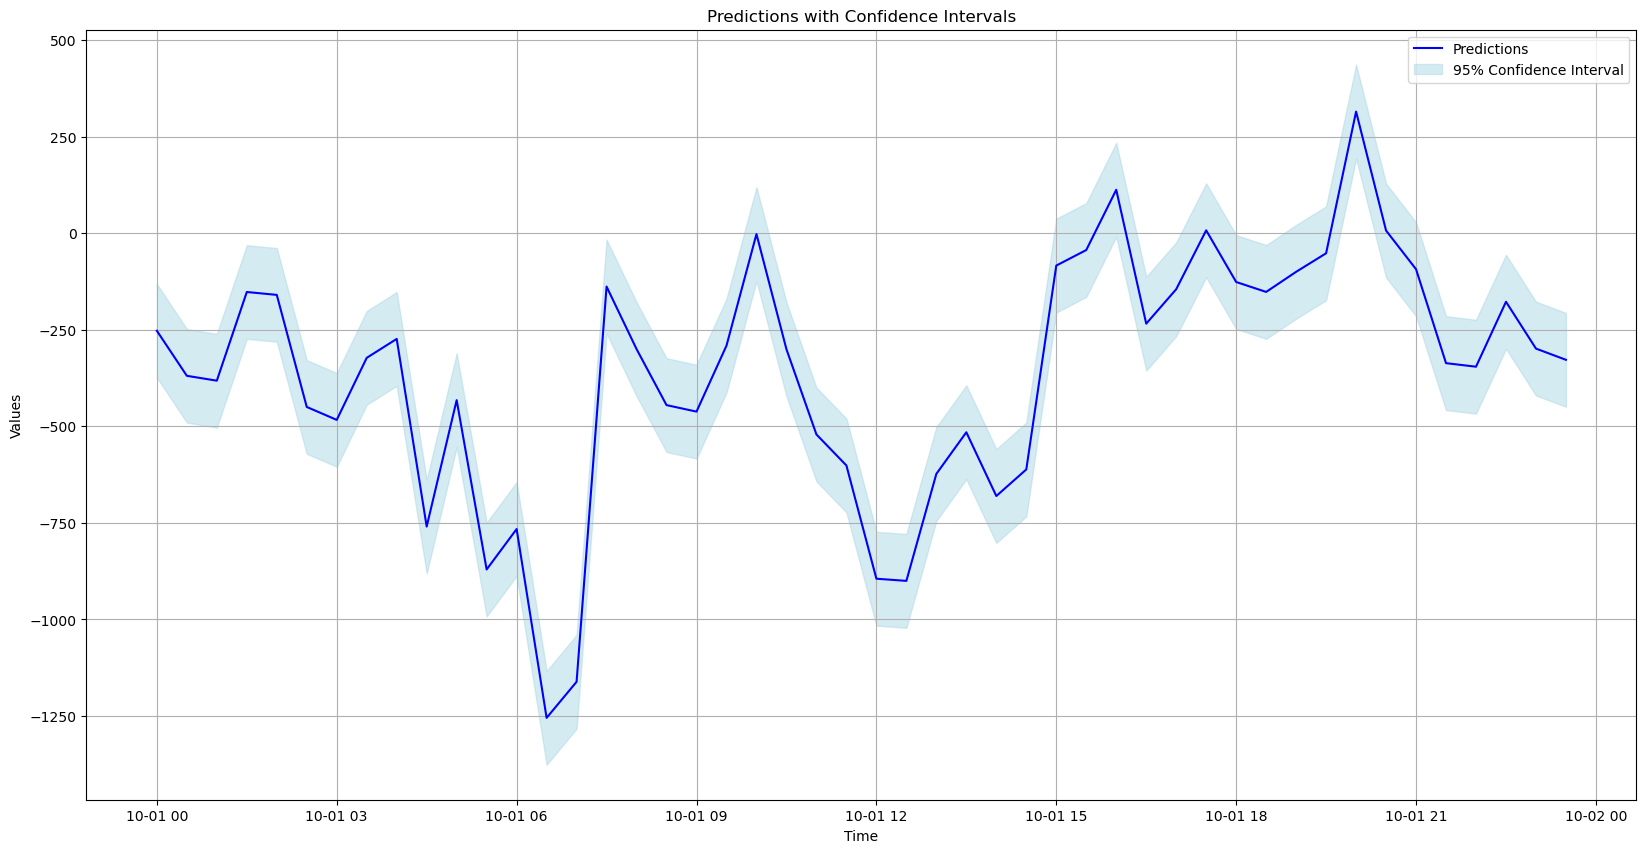

In [ ]:
upper_bound = future_predictions + 1.96 * garch_std_forward
lower_bound = future_predictions - 1.96 * garch_std_forward

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(future_predictions.index, future_predictions, label="Predictions", color="blue")
plt.fill_between(future_predictions.index, lower_bound, upper_bound, color="lightblue", alpha=0.5, label="95% Confidence Interval")
plt.title("Predictions with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()